# Imports

In [1]:
import os
os.getcwd()
import anndata
import pandas as pd
import omicverse as ov
ov.ov_plot_set()
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scanpy as sc
import decoupler as dc
import gseapy as gp
from gseapy.plot import gseaplot
# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

In [ ]:
import matplotlib.pyplot as plt

# Set global rcParams for consistent formatting
plt.rcParams['figure.facecolor'] = 'white'  # White background for the figure
plt.rcParams['axes.facecolor'] = 'white'  # White background for the axes
plt.rcParams['savefig.facecolor'] = 'white'  # White background for saved figures
plt.rcParams['legend.frameon'] = True  # Show legend frame
plt.rcParams['legend.edgecolor'] = 'black'  # Black legend border
plt.rcParams['legend.labelcolor'] = 'black'  # Black legend text
plt.rcParams['legend.fontsize'] = 12  # Legend font size
plt.rcParams['axes.labelcolor'] = 'black'  # Axis labels color
plt.rcParams['xtick.color'] = 'black'  # X-axis ticks color
plt.rcParams['ytick.color'] = 'black'  # Y-axis ticks color
plt.rcParams['text.color'] = 'black'  # Default text color

# Read data 

## Sample metadata

In [3]:
#Open the sample metadata from GCF
sample_metadata = pd.read_table(filepath_or_buffer=r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/GCF-2024-926_samplesheet.tsv")

# Create the mapping between wrongfuly named R1_52, R1_44 and R1_52 from GCF. See issue on Notion titled "Issues with GCF data (R1/44, R1/52, etc)"
mapping_dict_R_ids = {
	"R1_44":"R1_05",
	"R1_52":"R1_07",
	"R1_45":"R1_01"
}
sample_metadata["Sample_ID"] = sample_metadata["Sample_ID"].replace(mapping_dict_R_ids)
# Open Pal's file with added clinical information for each sample
sample_file_txt = open("/mnt/work/RO_src/Projects/THORA/DataProcessing/data/raw/SampleSheet.txt", "r")
sample_sheet_file = pd.read_table(sample_file_txt)
# Replace / with _ in Box.ID.RNA so that we can merge both files
sample_sheet_file["Box.ID.RNA"] = sample_sheet_file["Box.ID.RNA"].replace("/", "_", regex=True)
# Merge on the Sample_ID (R1_52, etc)
sample_metadata = sample_metadata.merge(sample_sheet_file, left_on="Sample_ID", right_on="Box.ID.RNA", how="left")
# Reorder columns for easier reading
cols_to_reoder = ["ID_Sample","StudyID","Sample_ID","Box.ID.RNA","External_ID","Organ","SampleType","Diagnosis","Stage","AnyPlasma","Arm"]
sample_metadata = sample_metadata[cols_to_reoder + [col for col in sample_metadata.columns if col not in cols_to_reoder]]
# Drop unnecessary columns
sample_metadata.drop(columns=["Included.in.Filipe.s.list"], inplace=True)
# Set the sample_ID as index for future merging
sample_metadata.set_index("Sample_ID",inplace=True)
# Standardize naming convention from Sample_Biosource
mapp_dict = {
	"Lung": ["Lung","Bronchus","Bronchus/lung","Bronchial mucosa","Lymph node, 4R","Lymph node, station 7","lung, left lower lobe"],
	"Lymph Node" : ["Lymph node","EBUS lymph 4R","Lymph node, 11R","Lymph node 4R","Lymph node stasjon 7"],
	"Unknown": ["unknown locality"],
	"Subcutaneous": ["subcutaneous tissue"]
}
n_mapp_dict = {v:k for k, l in mapp_dict.items() for v in l}
sample_metadata.replace({"Organ":n_mapp_dict}, inplace=True)


## Gene info

In [4]:
gene_info = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/gene_info.tsv")
gene_info.drop(columns=["Unnamed: 0"], inplace=True)
gene_info.set_index("gene_id",inplace=True)
gene_info["gene_name"] = gene_info["gene_name"].str.upper()
gene_info['gene_name'] = gene_info['gene_name'].fillna(gene_info.index.to_series())
transcript_counts = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/transcript_counts.tsv")

gene_counts = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/gene_counts.tsv")
gene_counts.set_index(["Unnamed: 0"], inplace=True)
gene_counts.index.rename("ENSG", inplace=True)
gene_counts = gene_counts.round(0).astype(int)
# Count all the zeros
df_zeros = (gene_counts == 0).all(axis=1)
# Subset the gene_counts to remove all of the rows that only have zeros in them
gene_counts = gene_counts[~df_zeros]
#Confirm that the subset was done correctly
gene_counts.shape[0] - df_zeros.sum() == gene_counts.shape[0]
gene_counts = gene_counts.rename(columns=mapping_dict_R_ids)
gene_counts

R1_28  R1_79  R2_07  R2_22  R2_30  R1_74  R1_19  R2_29  \
ENSG                                                                      
ENSG00000000003    105    171    288     48    151    226     36     57   
ENSG00000000419    423    476    753    271    313    226    179    247   
ENSG00000000457     55    198    549    113     80     88     66     30   
ENSG00000000460     99    393    956    222    365    121    311    138   
ENSG00000000938      4     27     13     14     16      8    435     18   
...                ...    ...    ...    ...    ...    ...    ...    ...   
ENSG00000291313      8      0     18     41      0      0      0      4   
ENSG00000291314      0      0      0      0      0      0      0      0   
ENSG00000291315      0      5      6      0      0      0      0      0   
ENSG00000291316      0      0      0     11      1      0      0      5   
ENSG00000291317      5     28     37     30      0     25    165     36   

                 R2_60  R1_81  ...  R1_26  R2_06  R2_02  R2_08  R2_56  R2_12  \
ENSG                           ...                                             
ENSG00000000003     95    117  ...    212    137     21     44    143     66   
ENSG00000000419    211    201  ...    481    765    210    165    331    134   
ENSG00000000457     85     98  ...    150    213    180     46    127    140   
ENSG00000000460     72    108  ...    160    110     53     33     78    129   
ENSG00000000938     17      6  ...      6   1494     36      2     52     48   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
ENSG00000291313      0      0  ...      1    157     54      0      0      0   
ENSG00000291314      0      0  ...      0      0      0      0      0      0   
ENSG00000291315      0      0  ...      0      0      0      0      2      0   
ENSG00000291316      0      0  ...      0      0     27      0     16      0   
ENSG00000291317      0     23  ...     32     50     55     18     35     15   

                 R2_33  R2_36  R2_68  R1_62  
ENSG                                         
ENSG00000000003    206    177    249    105  
ENSG00000000419    328    250    529    286  
ENSG00000000457    162    131    249     53  
ENSG00000000460    315    300    504     37  
ENSG00000000938     12     23     15    188  
...                ...    ...    ...    ...  
ENSG00000291313     17     51     11      0  
ENSG00000291314      0      0      0      0  
ENSG00000291315      1      0      0      0  
ENSG00000291316      0      0      0      0  
ENSG00000291317     25     17     67     22  

[51620 rows x 95 columns]

## Create adata

### Load clinical data

In [5]:
seq_files_df_with_clinical = pd.read_excel(r"/mnt/work/RO_src/Projects/THORA/DataProcessing/data/processed/selected_clinical_data_v2.xlsx")
seq_files_df_with_clinical.drop(columns=["Unnamed: 0"],inplace=True)

In [6]:
seq_files_df_with_clinical

pasnr THORA_ID Unique Sample ID                                 hospital  \
0       5    TH005            TB-90  Universitetssykehuset Nord-Norge Tromsø   
1       6    TH006            TB-43            Haukeland Universitetssykehus   
2       6    TH006            TB-44            Haukeland Universitetssykehus   
3       7    TH007            TB-25        Oslo Universitetssykehus, Ullevål   
4       8    TH008            TB-91                          Ålesund sykehus   
..    ...      ...              ...                                      ...   
90    166    TH166            TB-19             Universitetssjukhuset i Lund   
91    168    TH168            TB-81                       Sykehuset Levanger   
92    169    TH169            TB-87        Universitetssykehuset i Stavanger   
93    171    TH171            TB-83                         Sykehuset Namsos   
94    173    TH173            TB-27        Oslo Universitetssykehus, Ullevål   

     ID_Sample Box.ID.RNA birth_date radio_arm Stage tnm_staging  ...  \
0     SFH75/21      R2/60 1949-07-15     45 Gy    LD         IIB  ...   
1   SFH26/23.1      R2/33 1943-04-28     60 Gy    LD        IIIA  ...   
2   SFH26/23.2      R2/34 1943-04-28     60 Gy    LD        IIIA  ...   
3    SFH175/20      R2/67 1943-02-20     60 Gy    LD        IIIB  ...   
4     SFH76/23      R2/21 1934-03-11     45 Gy    LD        IIIA  ...   
..         ...        ...        ...       ...   ...         ...  ...   
90   SFH168/21      R1/70 1965-01-28     60 Gy    LD        IIIA  ...   
91    SFH66/23      R2/39 1945-05-02     45 Gy    LD         IIB  ...   
92    SFH72/21      R2/28 1957-09-28     45 Gy    LD         IIA  ...   
93    SFH67/23      R2/19 1952-01-19     60 Gy    LD        IIIB  ...   
94   SFH177/20      R1/72 1959-10-13     45 Gy    LD        IIIA  ...   

   start_strale_2  date_biopsy middle_strale time_since_t0  rt_dosage  \
0      2014-08-11   2014-06-25            No             0        0.0   
1      2014-09-29   2014-08-18            No             0        0.0   
2      2014-09-29   2017-03-07            No           917       60.0   
3      2014-10-13   2014-09-09            No             0        0.0   
4             NaT   2014-10-07            No             0        NaN   
..            ...          ...           ...           ...        ...   
90     2018-04-17   2018-03-02            No             0        0.0   
91     2018-05-08   2018-03-01            No             0        0.0   
92     2018-05-22   2018-04-16            No             0        0.0   
93     2018-05-28   2018-04-05            No             0        0.0   
94     2018-05-25   2018-04-19            No             0        0.0   

   chemo_dosage chemo_radiotherapy after_progression  age_at_sample  \
0             0           Baseline        -10.085414             64   
1             0           Baseline        -14.717477             71   
2             4              Other         15.900131             73   
3             0           Baseline               NaN             71   
4             0              Other         -6.406045             80   
..          ...                ...               ...            ...   
90            0           Baseline               NaN             53   
91            0           Baseline               NaN             72   
92            0           Baseline         -7.260184             60   
93            0           Baseline               NaN             66   
94            0           Baseline        -11.399474             58   

    before_after_progression  
0                          0  
1                          0  
2                          1  
3                          0  
4                          0  
..                       ...  
90                         0  
91                         0  
92                         0  
93                         0  
94                         0  

[95 rows x 80 columns]

In [7]:

# df = seq_files_df_with_clinical.copy()


# # Extract visit number from 'visit_corr'
# df['visit_number'] = df['visit_corr'].str.extract(r'(\d{2})')[0]
# columns_to_pivot = ['provedato_corr','error','rt_dosage', 'chemo_dosage', 'chemo_radiotherapy', 'age_at_sample', 'after_progression','signaled_in_ppt','time_since_t0','before_after_progression']
# # Pivot the DataFrame
# df_pivot = df.pivot_table(index=['studieid'], 
#                           columns='visit_number', 
#                           values=columns_to_pivot, 
#                           aggfunc='first').reset_index()


# # Flatten the MultiIndex columns for pivoted data
# df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
# df_pivot.rename(columns={'studieid_': 'studieid'}, inplace=True)

# # Aggregate the other columns (keeping the first value)
# df_agg = df.groupby(by='studieid').agg(lambda x: x.iloc[0]).reset_index()

# # Drop the columns that have been pivoted from the aggregated dataframe
# df_agg = df_agg.drop(columns=columns_to_pivot + ['visit_corr', 'visit_number'])

# # Merge the aggregated columns with the pivoted columns
# df_final = pd.merge(df_agg, df_pivot, left_on='studieid', right_on="studieid")


### Load mapping dataframe between sequence ID and clinical ID

In [8]:
# Fill NaNs from column "Box.ID.RNA" with the values from the index of the same row
sample_metadata["Box.ID.RNA"] = sample_metadata["Box.ID.RNA"].fillna(sample_metadata.index.to_series().map(str))
seq_files_df_with_clinical["Box.ID.RNA"] = seq_files_df_with_clinical["Box.ID.RNA"].replace("/","_")
seq_files_df_with_clinical.set_index("Box.ID.RNA",inplace=True)
seq_files_df_with_clinical.index = seq_files_df_with_clinical.index.str.replace("/","_")
seq_files_df_with_clinical.rename_axis("Sample_ID", inplace=True)
original_index = sample_metadata.index

In [9]:
seq_files_df_with_clinical.rename(columns={"Unique Sample ID":"External_ID","THORA_ID":"StudyID"},inplace=True)

In [10]:
# Perform the second merge operation
merged_df_with_clinical = sample_metadata.merge(
    right=seq_files_df_with_clinical,
	left_on = ["StudyID","External_ID","ID_Sample"],
    right_on = ["StudyID","External_ID","ID_Sample"],
    how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [11]:
merged_df_with_clinical.to_excel("/mnt/work/RO_src/Pipelines/DataEngineering/final_sample_with_clinical.xlsx")

In [12]:


merged_df_with_clinical.set_index("Box.ID.RNA", inplace=True)
# Remove the row in which "Box.ID.RNA" is equal to "R2_64". NOTE: R2_64 is not in the GCF sample sheet.

merged_df_with_clinical = merged_df_with_clinical.loc[merged_df_with_clinical.index != "R2_64"]

# Remove any duplicate index
merged_df_with_clinical = merged_df_with_clinical[~merged_df_with_clinical.index.duplicated(keep='first')]

In [13]:
adata = anndata.AnnData(X=gene_counts.T)
adata.var = gene_info.loc[adata.var_names]
adata.obs = merged_df_with_clinical.loc[adata.obs_names]
adata.obs["batch"] = "mRNA"
adata.var.reset_index(inplace=True)
adata.var.set_index(keys="gene_name",inplace=True)
# adata.obs.index = adata.obs.index + '_' + adata.obs['Organ'].astype(str)

for i, (g_name, ensg) in enumerate(zip(adata.var.index, adata.var["ENSG"])):
	if pd.isna(g_name):
		adata.var.index.values[i] = ensg
	else:
		continue

raw_data=adata.to_df().T

adata.var_names = adata.var_names.str.upper()
adata.var.index = adata.var.index.str.upper()
adata.var_names_make_unique()

# # Subset the adata to just have the obs in which the col "id_i_database" is not null
# adata = adata[~adata.obs["id_i_database"].isnull()]

# # Also remove the TH061 from the adata as it has 1500 day difference between sample taken and diagnosis
# adata = adata[~(adata.obs["studieid"] == "TH061")]

# # Subset to just those that are either Lung or Lymh node on the column "Organ"
adata = adata[adata.obs["Organ"].isin(["Lung","Lymph Node"])]


In [14]:
adata.obs["Organ"].value_counts()
adata.obs["Arm"].value_counts()
adata.obs["tnm_staging"].value_counts()

IIIA    38
IIIB    31
IIA     10
IIB      7
IA       2
Name: tnm_staging, dtype: int64

In [15]:
adata.obs.to_excel(r"/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/adata_sample_and_clinical_metadata.xlsx")

# QC and Normalization

In [16]:
# TODO: mean across each sample, not across all samples

In [17]:
# dc.plot_filter_by_expr(adata=adata, min_count=1)

In [18]:
# Save the current adata to raw
adata.raw = adata.copy()

# Filter by RPM > 1. NOTE: This has to be done on the raw counts, not log normalized first. 
genes = dc.filter_by_expr(adata,lib_size=1e6, min_count=1)
len(genes)

# Subset adata with the filtered genes
adata = adata[:, genes].copy()

# Save the raw counts as a layer
adata.layers["raw_counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=10e6) 
# Logarithmize the data
sc.pp.log1p(adata)
adata.layers["lognormalized_counts"] = adata.X.copy()

# NOTE: Not needed, but required for the 2nd use case for the GARD score.
# sc.pp.scale(adata, zero_center=True, max_value=None)
# adata.layers["scaled_lognormalized_counts"] = adata.X.copy()

# Revert back adata.X to the raw counts
adata.X = adata.layers["raw_counts"].copy()


normalizing counts per cell
    finished (0:00:00)


# Count matrix

In [19]:
count_matrix = pd.DataFrame(adata.X, adata.obs.index, adata.var_names).T
count_matrix.index.name = None

In [20]:
count_matrix_unt = pd.DataFrame(adata.X, adata.obs.index, adata.var_names)


# Preprocessing and Clustering


## Highly variable genes

In [54]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="Arm", layer="raw_counts",flavor="seurat_v3")


extracting highly variable genes


TypeError: '<' not supported between instances of 'float' and 'str'

computing neighbors
    using 'X_pca' with n_pcs = 35
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)


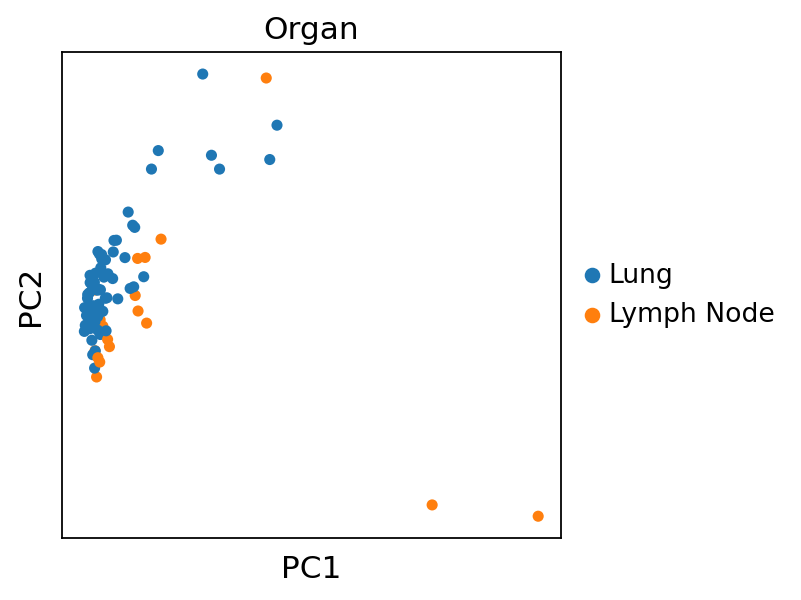

In [ ]:
adata.X = adata.layers["lognormalized_counts"].copy()
sc.pp.neighbors(adata,n_pcs=35)
sc.tl.umap(adata)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca(adata, color="Organ", size=100)

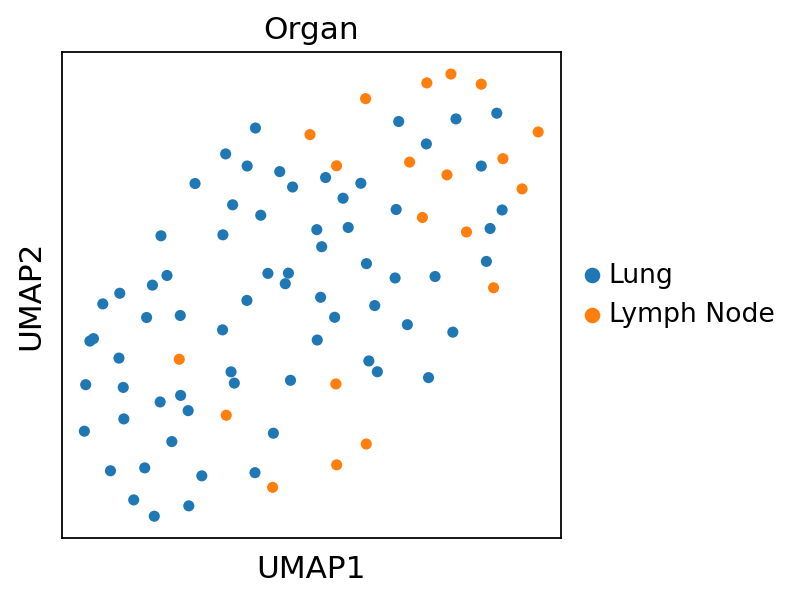

In [ ]:
sc.pl.umap(
    adata,
    color="Organ",
    # Setting a smaller point size to get prevent overlap
    size=100,
)

In [ ]:
# Leiden clustering
sc.tl.leiden(adata,resolution=1.5, key_added="leiden")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
sc.tl.dendrogram(adata, groupby = "leiden")


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [ ]:
# top_20_hvg = adata.var[adata.var["highly_variable"] == True][["highly_variable","means","dispersions","dispersions_norm"]].sort_values(by="means", ascending=False).head(20).index


In [ ]:
top_30_hvg = adata.var["highly_variable_rank"].sort_values(ascending=False).head(30).index

In [ ]:
hvgs = adata.var[adata.var["highly_variable"] == True].head(100).index

In [ ]:
hvgs

Index(['CFH', 'CFTR', 'LAP3', 'CD99', 'TMEM176A', 'CYP26B1', 'SLC7A2', 'PDK4',
       'YBX2', 'CACNA1G', 'DLX6', 'ETV1', 'SCIN', 'PROM1', 'DNAH9', 'GAS7',
       'CACNA2D2', 'BAIAP3', 'DLEC1', 'MMP25', 'TENM1', 'DYRK4', 'SEMA3G',
       'STAB1', 'CD4', 'MRC2', 'ANOS1', 'SYT7', 'DCN', 'TYROBP', 'KDM5D',
       'SLC7A14', 'CLDN11', 'GPRC5A', 'NPC1L1', 'ISL1', 'IL20RA', 'CNTN1',
       'SLC11A1', 'WWTR1', 'ATP1A2', 'CYP24A1', 'SYT13', 'CD74', 'HGF',
       'ADGRA2', 'SAMD4A', 'PLEKHB1', 'NRXN3', 'FHL1', 'ABCC2', 'NR1H3',
       'TYMP', 'VIM', 'CD44', 'SLAMF7', 'GRN', 'ARHGAP31', 'DEPDC1B',
       'SLC18A1', 'TUBG2', 'FLT4', 'MSR1', 'DNAH5', 'RAB27B', 'TNC', 'CAPG',
       'TG', 'ADAM28', 'ZIC2', 'LCP2', 'EPHA3', 'PREX2', 'ARAP2', 'CP',
       'ARHGAP6', 'ROS1', 'HDAC9', 'LMO3', 'CELF2', 'LTBP1', 'ELN', 'NEXMIF',
       'DKK3', 'ARHGEF5', 'PTGER3', 'FSTL4', 'LAMA3', 'ENTPD2', 'PTPRN',
       'FOXC1', 'KCNH2', 'MCOLN3', 'IL17RB', 'CAMK2B', 'DGKG', 'SLC2A3', 'PSD',
       'PTPRU', 'BCAT1'],


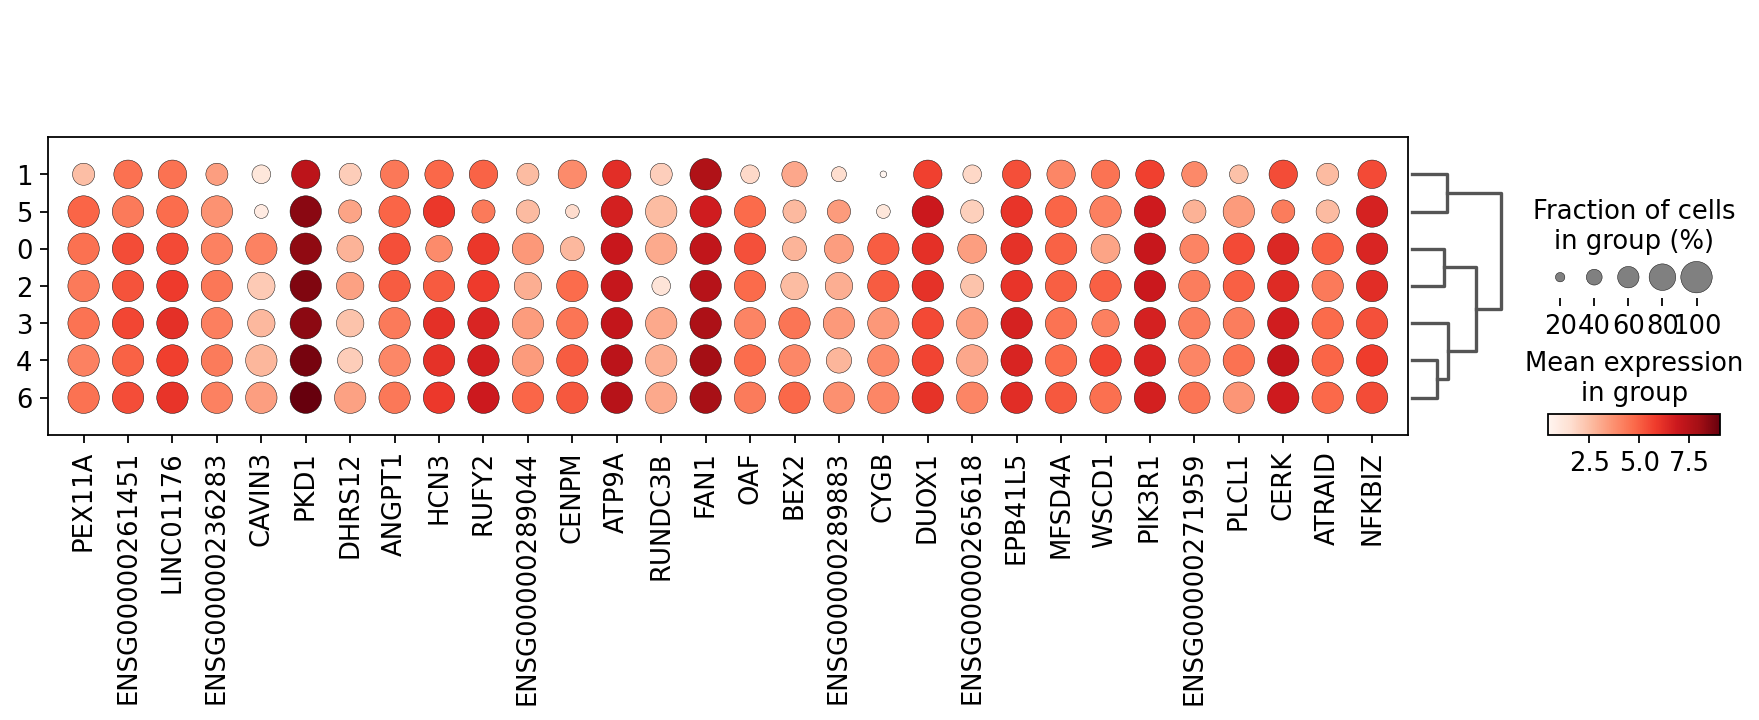

In [ ]:
sc.pl.dotplot(adata, top_30_hvg, groupby='leiden', dendrogram=True)


# Differential Expression Analysis

## Establish groups/conditions

In [ ]:
# ctrl=adata.obs[adata.obs["stage_tnm7_taha"].isin(["IIIA","IIIB"])].index
# trt=adata.obs[adata.obs["stage_tnm7_taha"].isin(["IIA","IIB"])].index

# ctrl=adata.obs[adata.obs["stage_tnm7_taha"].isin(["45 Gy/30 fraksjoner"])].index
# trt=adata.obs[adata.obs["stage_tnm7_taha"].isin(["60 Gy/40 fraksjoner"])].index


In [ ]:
ctrl=adata.obs[adata.obs["Arm"].isin(["45 Gy/30 fraksjoner"])].index
trt=adata.obs[adata.obs["Arm"].isin(["60 Gy/40 fraksjoner"])].index

In [ ]:
trt=adata.obs[adata.obs["Organ"].isin(values=["Lung"])].index


In [ ]:
ctrl=adata.obs[adata.obs["Organ"].isin(values=["Lymph Node"])].index


## Omicverse (wrapper of pydeseq2)

In [ ]:

dds=ov.bulk.pyDEG(count_matrix)
dds.drop_duplicates_index()
dds.normalize()
result=dds.deg_analysis(group1=trt,group2=ctrl,method='ttest')

In [ ]:
result.head()


pvalue    qvalue  FoldChange   MaxBaseMean      BaseMean  \
MALAT1  0.861057  0.968707    0.976629  97310.612945  96173.469263   
RN7SK   0.321768  0.849350    0.807976  37470.841226  33872.880521   
RN7SL2  0.428836  0.861443    0.733247  37079.037935  32133.133818   
NEAT1   0.480298  0.869908    0.800401  35829.982942  32253.841152   
RN7SL1  0.660722  0.917402    0.855562  25651.998590  23799.198475   

        log2(BaseMean)    log2FC  abs(log2FC)      size  -log(pvalue)  \
MALAT1       16.553351 -0.034117     0.034117  0.097663      0.064968   
RN7SK        15.047843 -0.307615     0.307615  0.080798      0.492458   
RN7SL2       14.971774 -0.447629     0.447629  0.073325      0.367709   
NEAT1        14.977183 -0.321205     0.321205  0.080040      0.318489   
RN7SL1       14.538625 -0.225056     0.225056  0.085556      0.179981   

        -log(qvalue)     sig  
MALAT1      0.013807  normal  
RN7SK       0.070913  normal  
RN7SL2      0.064773  normal  
NEAT1       0.060527  normal  
RN7SL1      0.037440  normal

In [ ]:
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=6)

... Fold change threshold: 0.8439902364693461


In [ ]:
# dds.plot_volcano(title='DEG Analysis',figsize=(20,20),
#                  plot_genes_num=15,plot_genes_fontsize=12,)

(<Figure size 960x960 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

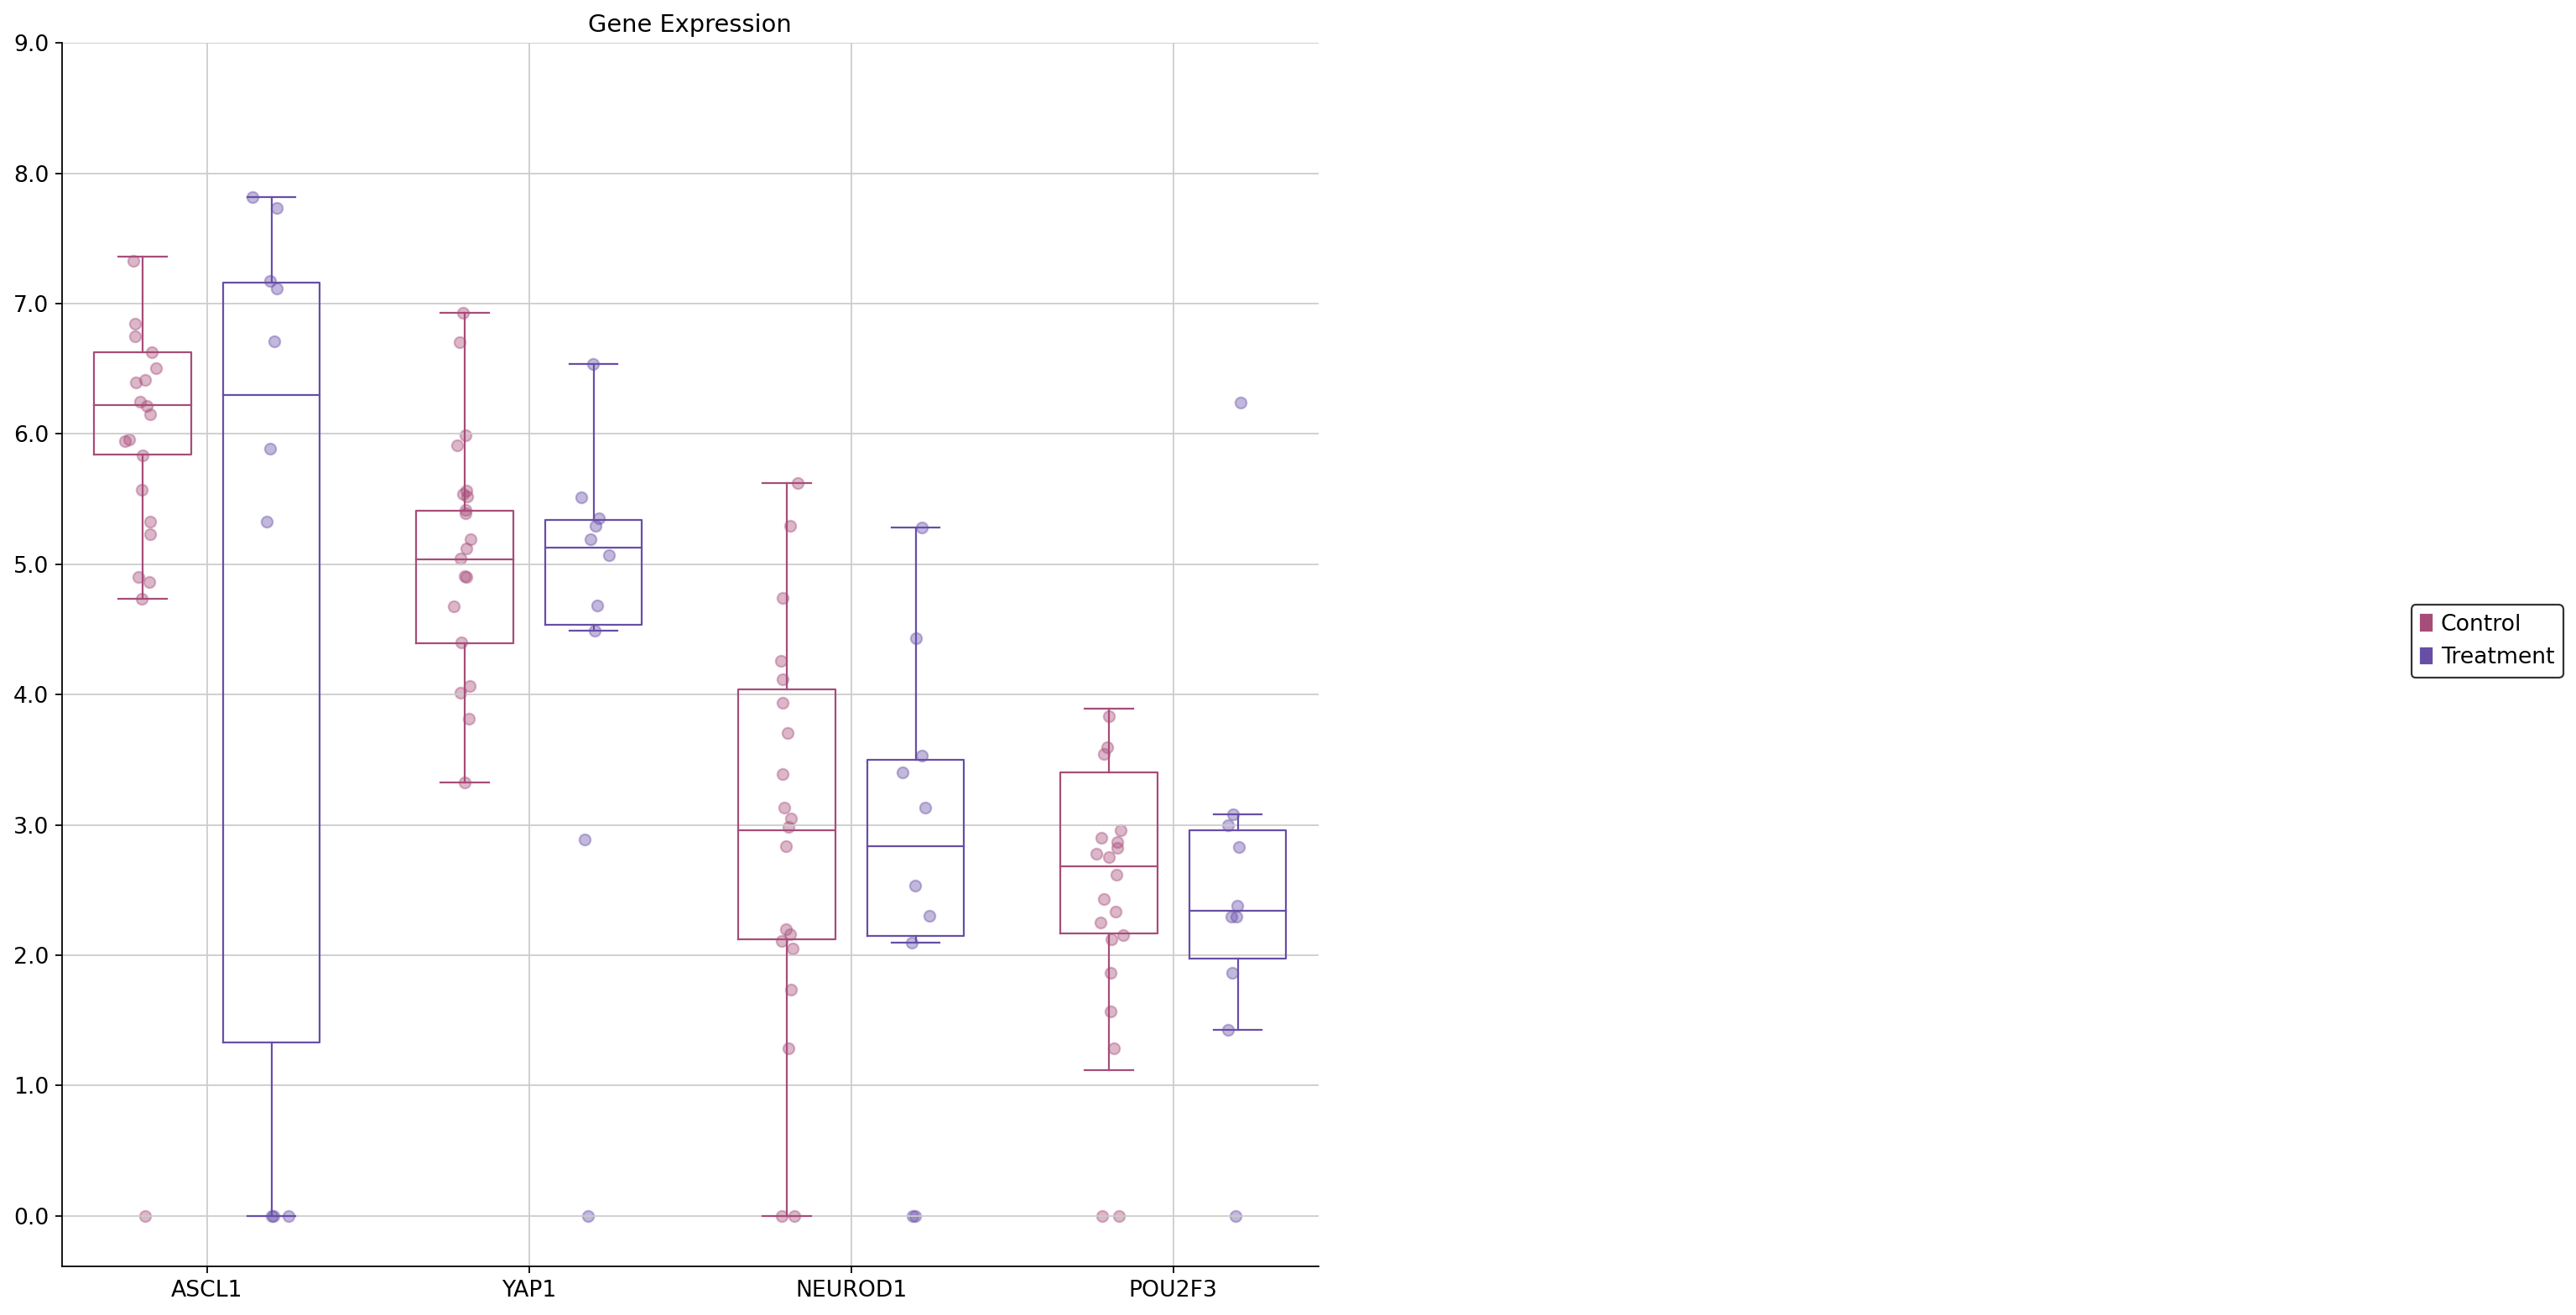

In [ ]:
dds.plot_boxplot(genes=['NEUROD1','POU2F3',"ASCL1","YAP1"],treatment_groups=trt,
    control_groups=ctrl,fontsize=12,figsize=(12,12),
        legend_bbox=(2,0.55))  

## pyDESeq2

In [ ]:
adata.X= adata.layers["raw_counts"].copy()

In [ ]:
dds = DeseqDataSet(
    adata=adata,
    design_factors='Organ',
    refit_cooks=True,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between Lung and Lymph node  
results_df = DeseqStats(
    dds,
    contrast=["Organ", "Lung", "Lymph Node"],
)


# Compute the wald test
results_df.summary()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 2.05 seconds.

Fitting dispersion trend curve...
... done in 8.49 seconds.

Fitting MAP dispersions...
... done in 2.24 seconds.

Fitting LFCs...
... done in 2.86 seconds.

Refitting 848 outliers.

Fitting dispersions...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 0.45 seconds.

Fitting LFCs...
... done in 0.39 seconds.

Running Wald tests...
... done in 2.07 seconds.



Log2 fold change & Wald test p-value: Organ Lung vs Lymph Node


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6           151.737393        0.220871  0.216319  1.021043  0.307234   
DPM1             357.653045       -0.287021  0.109272 -2.626672  0.008622   
SCYL3            152.611171       -0.188544  0.155858 -1.209716  0.226388   
C1ORF112         207.011107        0.256549  0.247714  1.035670  0.300356   
FGR               35.650672        0.998331  0.486167  2.053471  0.040027   
...                     ...             ...       ...       ...       ...   
ENSG00000291283    8.180575       -0.456561  0.507108 -0.900322  0.367949   
ENSG00000291288   11.692837       -0.981858  0.380145 -2.582850  0.009799   
ENSG00000291290   19.186707       -0.791601  0.439071 -1.802898  0.071404   
ENSG00000291299  191.861761       -0.055971  0.144887 -0.386306  0.699270   
TMEM276           33.194538        0.211616  0.317004  0.667551  0.504420   

                     padj  
TSPAN6           0.605064  
DPM1             0.075620  
SCYL3            0.520295  
C1ORF112         0.597893  
FGR              0.197510  
...                   ...  
ENSG00000291283  0.661821  
ENSG00000291288  0.082208  
ENSG00000291290  0.278022  
ENSG00000291299  0.872022  
TMEM276          0.761196  

[22624 rows x 6 columns]

In [ ]:
# dds = DeseqDataSet(
#     adata=adata,
#     design_factors='stage-tnm7-taha',
#     refit_cooks=True,
# )

# # Compute LFCs
# dds.deseq2()

# # Extract contrast between Lung and Lymph node  
# res_IIIA_vs_IIIB = DeseqStats(
#     dds,
#     contrast=["stage-tnm7-taha", "IIIA", "IIIB"],
# )

# res_IIIA_vs_IIA = DeseqStats(
#     dds,
#     contrast=["stage-tnm7-taha", "IIIA", "IIA"],
# )

# res_IIB_vs_IIIA = DeseqStats(
#     dds,
#     contrast=["stage-tnm7-taha", "IIB", "IIIA"],
# )
# # Compute the wald test
# res_IIB_vs_IIIA.summary()

Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 1.70 seconds.

Fitting dispersion trend curve...
... done in 6.40 seconds.

Fitting MAP dispersions...
... done in 2.08 seconds.

Fitting LFCs...
... done in 2.30 seconds.

Refitting 287 outliers.

Fitting dispersions...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.20 seconds.

Fitting LFCs...
... done in 0.24 seconds.

Running Wald tests...
... done in 1.65 seconds.



Log2 fold change & Wald test p-value: stage-tnm7-taha IIB vs IIIA


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                   
TSPAN6           134.703735        0.665454  0.429447  1.549562  0.121247   
DPM1             318.472355       -0.167391  0.283552 -0.590336  0.554965   
SCYL3            123.738630        0.325504  0.453818  0.717255  0.473217   
C1ORF112         152.454985        0.522456  0.614935  0.849611  0.395541   
FGR               54.789513       -2.947632  1.183766 -2.490047  0.012773   
...                     ...             ...       ...       ...       ...   
ENSG00000291272  151.967804        0.027611  0.576124  0.047925  0.961776   
ENSG00000291275   62.077722       -0.343175  0.672129 -0.510579  0.609646   
ENSG00000291282   20.645171       -0.471547  0.762321 -0.618568  0.536201   
ENSG00000291299  161.750014       -0.221905  0.375224 -0.591393  0.554257   
TMEM276           28.449223       -1.226434  0.773842 -1.584863  0.112997   

                     padj  
gene_name                  
TSPAN6           0.811498  
DPM1             0.956715  
SCYL3            0.941779  
C1ORF112         0.927295  
FGR              0.601967  
...                   ...  
ENSG00000291272  0.993849  
ENSG00000291275  0.966716  
ENSG00000291282  0.954258  
ENSG00000291299  0.956709  
TMEM276          0.808837  

[20544 rows x 6 columns]

In [ ]:
print(dds.design_factors)


['Organ']


In [ ]:
res_IIIA_vs_IIA.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: stage-tnm7-taha IIIA vs IIA


... done in 1.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                   
TSPAN6           134.703735        0.067105  0.385994  0.173849  0.861984   
DPM1             318.472355       -0.122984  0.252192 -0.487660  0.625791   
SCYL3            123.738630       -0.122890  0.405160 -0.303312  0.761652   
C1ORF112         152.454985        0.639565  0.549028  1.164903  0.244058   
FGR               54.789513        0.801396  1.027968  0.779593  0.435631   
...                     ...             ...       ...       ...       ...   
ENSG00000291272  151.967804        0.456601  0.511711  0.892303  0.372231   
ENSG00000291275   62.077722       -0.289635  0.596044 -0.485929  0.627017   
ENSG00000291282   20.645171        0.741517  0.688905  1.076371  0.281761   
ENSG00000291299  161.750014        0.563332  0.336890  1.672153  0.094494   
TMEM276           28.449223        1.097918  0.694557  1.580746  0.113936   

                     padj  
gene_name                  
TSPAN6           0.994342  
DPM1             0.982595  
SCYL3            0.991528  
C1ORF112         0.909208  
FGR              0.963942  
...                   ...  
ENSG00000291272  0.951356  
ENSG00000291275  0.982595  
ENSG00000291282  0.926415  
ENSG00000291299  0.786619  
TMEM276          0.816863  

[20544 rows x 6 columns]

In [ ]:
res_IIIA_vs_IIA.results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                   
TSPAN6           134.703735        0.067105  0.385994  0.173849  0.861984   
DPM1             318.472355       -0.122984  0.252192 -0.487660  0.625791   
SCYL3            123.738630       -0.122890  0.405160 -0.303312  0.761652   
C1ORF112         152.454985        0.639565  0.549028  1.164903  0.244058   
FGR               54.789513        0.801396  1.027968  0.779593  0.435631   
...                     ...             ...       ...       ...       ...   
ENSG00000291272  151.967804        0.456601  0.511711  0.892303  0.372231   
ENSG00000291275   62.077722       -0.289635  0.596044 -0.485929  0.627017   
ENSG00000291282   20.645171        0.741517  0.688905  1.076371  0.281761   
ENSG00000291299  161.750014        0.563332  0.336890  1.672153  0.094494   
TMEM276           28.449223        1.097918  0.694557  1.580746  0.113936   

                     padj  
gene_name                  
TSPAN6           0.994342  
DPM1             0.982595  
SCYL3            0.991528  
C1ORF112         0.909208  
FGR              0.963942  
...                   ...  
ENSG00000291272  0.951356  
ENSG00000291275  0.982595  
ENSG00000291282  0.926415  
ENSG00000291299  0.786619  
TMEM276          0.816863  

[20544 rows x 6 columns]

In [ ]:
res_IIIA_vs_IIIB.summary()

Running Wald tests...
... done in 1.52 seconds.



Log2 fold change & Wald test p-value: stage-tnm7-taha IIIA vs IIIB


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                   
TSPAN6           134.703735       -0.330333  0.278120 -1.187735  0.234938   
DPM1             318.472355       -0.038744  0.182849 -0.211893  0.832191   
SCYL3            123.738630       -0.051422  0.293608 -0.175138  0.860972   
C1ORF112         152.454985       -0.500188  0.397272 -1.259056  0.208010   
FGR               54.789513        0.522748  0.752183  0.694975  0.487071   
...                     ...             ...       ...       ...       ...   
ENSG00000291272  151.967804        0.045336  0.372035  0.121859  0.903011   
ENSG00000291275   62.077722       -0.636959  0.431682 -1.475528  0.140071   
ENSG00000291282   20.645171        1.038450  0.494070  2.101828  0.035568   
ENSG00000291299  161.750014        0.474002  0.242456  1.955000  0.050583   
TMEM276           28.449223        0.571685  0.494105  1.157011  0.247268   

                     padj  
gene_name                  
TSPAN6           0.981465  
DPM1             0.992882  
SCYL3            0.993200  
C1ORF112         0.972467  
FGR              0.986340  
...                   ...  
ENSG00000291272  0.998048  
ENSG00000291275  0.959086  
ENSG00000291282  0.871479  
ENSG00000291299  0.879166  
TMEM276          0.981465  

[20544 rows x 6 columns]

In [ ]:
res_IIB_vs_IIIA_df = res_IIB_vs_IIIA.results_df
res_IIIA_vs_IIA_df = res_IIIA_vs_IIA.results_df
res_IIIA_vs_IIIB_df = res_IIIA_vs_IIIB.results_df


In [ ]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [ ]:
results_df = results_df.results_df
ranking = results_df[["stat"]].dropna().sort_values("stat",ascending=False)
ranking['stat'] = pd.to_numeric(ranking['stat'], errors='coerce').astype(float)
ranking["Symbol"] = ranking.index.copy()
# Ensure 'Symbol' column is properly formatted as a string
ranking['Symbol'] = ranking['Symbol'].astype(str).str.strip()
ranking["Symbol"] = ranking["Symbol"].str.upper()
gene_list = ranking['Symbol'].tolist()

In [ ]:
ranking = ranking.head(50)

In [ ]:
gene_list = gene_list[0:100]

In [ ]:
gene_list

['ITGB6',
 'MMP2',
 'ZNF319',
 'TGFBI',
 'MXRA5',
 'SPON1',
 'MMP14',
 'C4B',
 'NRP2',
 'SHISA5',
 'TRIP10',
 'C1S',
 'CD109',
 'RBPMS',
 'RYR2',
 'LRRC37A4P',
 'C1RL',
 'ARHGAP23',
 'RPS6KA2',
 'HMCN1',
 'SNHG8',
 'A2M',
 'SULF1',
 'CFB',
 'COL12A1',
 'ZNF781-1',
 'CCL2',
 'RGPD1',
 'ITPRIPL2',
 'IGFBP4',
 'BCL6B',
 'PECAM1',
 'FBLN2',
 'EGFL7',
 'IER3',
 'GIT1',
 'HAS2',
 'EPDR1',
 'RIC1',
 'NDST1',
 'MOXD1',
 'HEG1',
 'CRIM1',
 'PCOLCE',
 'SERPINA1',
 'BLTP2',
 'CDH5',
 'TGFA',
 'SLC17A9',
 'WNT5A',
 'POFUT1',
 'VDR',
 'TRPM2',
 'KIF16B',
 'LAMA4',
 'CMTM3',
 'SLC30A7',
 'COL15A1',
 'NBPF20',
 'GJA1',
 'EMILIN1',
 'FLNA',
 'NOSTRIN',
 'SH2B3',
 'COL5A2',
 'COL18A1',
 'CARMN',
 'NES',
 'HTRA3',
 'MYLK',
 'SMYD5',
 'TSPAN18',
 'LGALS1',
 'MPZL2',
 'AUP1',
 'CARD10',
 'PLCL1',
 'TNXB',
 'SFXN3',
 'KAT2A',
 'AGRN',
 'TMED9',
 'IGHMBP2',
 'RAPGEF3',
 'VEGFC',
 'HSPA7',
 'PTGDS',
 'MRC2',
 'THBS2',
 'RARRES2',
 'HDLBP',
 'C11ORF96',
 'ADAMTS12',
 'CD274',
 'COL1A2',
 'AOC3',
 'MXRA8',
 'E

In [ ]:
pre_res = gp.prerank(
    rnk=ranking, 
    gene_sets="DisGeNET", 
    seed=6, 
    permutation_num=100,
    min_size=5,   # Allow very small gene sets
    verbose=True
)


In [ ]:
enrich_res = gp.enrichr(
    gene_list=gene_list,
    gene_sets="DisGeNET", 
    organism='Human',  # Specify organism if necessary
    outdir='enrichr_output',  # Specify output directory
    cutoff=0.05  # Adjust cutoff for significance
)

In [ ]:
enrich_res.res2d

Gene_set                            Term  Overlap       P-value  \
0     DisGeNET      Degenerative polyarthritis   22/976  2.144823e-09   
1     DisGeNET              Tumor Angiogenesis   16/511  4.872204e-09   
2     DisGeNET                 Liver Cirrhosis   17/683  4.532555e-08   
3     DisGeNET                Breast Carcinoma  50/4963  4.737731e-08   
4     DisGeNET          Ehlers-Danlos Syndrome    8/105  5.498704e-08   
...        ...                             ...      ...           ...   
3041  DisGeNET                 Cognitive delay    3/966  8.673737e-01   
3042  DisGeNET            Retinitis Pigmentosa    1/410  8.746306e-01   
3043  DisGeNET                  Leukemogenesis    2/730  8.843775e-01   
3044  DisGeNET    Mental and motor retardation   3/1021  8.908456e-01   
3045  DisGeNET  Congenital chromosomal disease    1/497  9.197579e-01   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0             0.000007            0                     0    5.601408   
1             0.000007            0                     0    7.467051   
2             0.000029            0                     0    5.915156   
3             0.000029            0                     0    3.050478   
4             0.000029            0                     0   17.752577   
...                ...          ...                   ...         ...   
3041          0.868514            0                     0    0.608183   
3042          0.875493            0                     0    0.481366   
3043          0.884959            0                     0    0.537452   
3044          0.891138            0                     0    0.573654   
3045          0.919758            0                     0    0.395161   

      Combined Score                                              Genes  
0         111.805281  SPON1;COL15A1;TNXB;VDR;RARRES2;MMP2;WNT5A;VEGF...  
1         142.917270  CD274;COL18A1;NRP2;MMP2;LAMA4;WNT5A;VEGFC;TGFA...  
2         100.021711  CD274;SERPINA1;VDR;RARRES2;MMP2;TGFA;PCOLCE;MM...  
3          51.446690  COL18A1;NRP2;SERPINA1;COL12A1;HDLBP;NBPF20;MYL...  
4         296.755070  COL1A2;TNXB;SERPINA1;C1S;COL5A2;COL12A1;FLNA;MYLK  
...              ...                                                ...  
3041        0.086536                                   NDST1;WNT5A;FLNA  
3042        0.064481                                            COL18A1  
3043        0.066037                                        WNT5A;SH2B3  
3044        0.066305                                   NDST1;WNT5A;FLNA  
3045        0.033053                                             COL1A2  

[3046 rows x 10 columns]

In [ ]:
go_mf = gp.get_library(name='DSigDB', organism='Human')

In [ ]:
pre_res = gp.prerank(
    rnk=ranking, 
    gene_sets="DSigDB", 
    seed=6, 
    permutation_num=100,
    min_size=0,   # Allow very small gene sets
    max_size=1000, # Further increase the maximum size
    verbose=True
)


In [ ]:
dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])

In [ ]:
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6           134.703735       -0.095599  0.252101 -0.379210  0.704532   
DPM1             318.472355        0.083080  0.158933  0.522737  0.601158   
SCYL3            123.738630       -0.135807  0.256769 -0.528908  0.596869   
C1ORF112         152.454985       -0.600608  0.354486 -1.694307  0.090207   
FGR               54.789513       -1.132186  0.671057 -1.687169  0.091571   
...                     ...             ...       ...       ...       ...   
ENSG00000291272  151.967804        0.392568  0.321407  1.221405  0.221933   
ENSG00000291275   62.077722       -0.130148  0.391764 -0.332211  0.739730   
ENSG00000291282   20.645171        0.223955  0.452686  0.494724  0.620795   
ENSG00000291299  161.750014       -0.010898  0.222954 -0.048880  0.961015   
TMEM276           28.449223        0.018321  0.453980  0.040356  0.967809   

                     padj  
TSPAN6           0.991787  
DPM1             0.991787  
SCYL3            0.991787  
C1ORF112         0.923472  
FGR              0.927171  
...                   ...  
ENSG00000291272  0.966790  
ENSG00000291275  0.991787  
ENSG00000291282  0.991787  
ENSG00000291299  0.997529  
TMEM276          0.997864  

[20544 rows x 6 columns]

In [ ]:
sigs = results_df[(results_df["padj"] < 0.05) & (abs(results_df["log2FoldChange"]) > 0.5)]


In [ ]:
dds_sig = dds[:,sigs.index]
dds_sig

View of AnnData object with n_obs × n_vars = 40 × 1394
    obs: 'ID_Sample', 'StudyID', 'Box.ID.RNA', 'External_ID', 'Organ', 'SampleType', 'Diagnosis', 'Stage', 'AnyPlasma', 'Arm', 'Project_ID', 'Organism', 'Sample_Biosource', 'RIN', 'Concentration', 'Flowcell_Name', 'Flowcell_ID', 'R1', 'R1_md5sum', 'R2', 'R2_md5sum', 'Elution.volume..uL.', 'RNA.con.ng.uL', 'Isolation.kit', 'BiopsyVsBehstart', 'studieid', 'input', 'ID_sample', 'id_i_database', 'inclusion_site', 'provedato', 'id_corr', 'country', 'pasnr', 'lane', 'library_prep_plate', 'id_person_corr', 'id_person_visit_corr', 'sykehus', 'randomisering_arm', 'f_dato', 'sex', 'ink_1', 'dato_behstart', 'stage_tnm7_taha', 'ps_2023', 'kur1', 'kur2', 'kur3', 'kur4', 'start_strale', 'end_strale', 'n_kurer', 'tot_straledose', 'dodsdato_taha2', 'status_os_taha2', 'os_k24', 'progresjon', 'progdato_taha2', 'last_pfsassessment_taha2', 'status_pfs_taha2', 'status_ttp_taha2', 'ttp_2023_taha', 'ttp_05_24', 'pfs_2023_taha', 'pfs_date_corr', 'ttp_date

In [ ]:
grapher = pd.DataFrame(dds_sig.layers["lognormalized_counts"].T, index=dds_sig.var_names, columns=dds_sig.obs_names)

In [ ]:
import seaborn as sns

In [ ]:
lung_columns = [col for col in grapher.columns if col.endswith('_Lung')]
lymph_node_columns = [col for col in grapher.columns if col.endswith('_Lymph Node')]
sorted_columns = lung_columns + lymph_node_columns

# Reorder the DataFrame
grapher_sorted = grapher[sorted_columns]

In [ ]:
grapher

R1_79     R1_19     R2_29     R1_81     R2_35     R1_67  \
LASP1            6.703149  7.394491  6.729467  6.488073  6.367259  7.158772   
TFPI             6.406413  6.901136  6.478047  6.899625  6.701017  6.593556   
PLXND1           6.726432  7.860242  7.834568  6.570539  7.253323  7.130976   
RBM6             5.779248  6.696362  6.880311  6.412555  6.319525  6.082035   
LAMP2            6.508751  6.782335  6.819245  6.934077  6.528354  7.337760   
...                   ...       ...       ...       ...       ...       ...   
NPEPPSP1-2       5.679490  6.058977  5.833547  5.365776  6.151316  5.831946   
ENSG00000291089  5.028208  4.720963  5.591789  4.809659  4.950702  5.225671   
SVIL-AS1-1       5.802706  6.650435  5.942443  5.937820  6.899692  6.097999   
ENSG00000291149  3.515583  5.232271  4.071325  4.315928  0.000000  4.955416   
ENSG00000291174  5.077285  5.619619  5.158502  5.550701  5.228559  3.487738   

                    R2_53     R1_68     R1_60     R1_07  ...     R1_71  \
LASP1            0.000000  6.825207  7.151823  6.708773  ...  6.870850   
TFPI             0.000000  6.540071  8.151983  6.085427  ...  6.350417   
PLXND1           0.000000  7.097070  7.274894  6.741886  ...  7.652460   
RBM6             0.000000  5.935139  6.702130  6.727304  ...  6.490487   
LAMP2            8.075949  6.873883  7.296112  7.173160  ...  6.643196   
...                   ...       ...       ...       ...  ...       ...   
NPEPPSP1-2       0.000000  5.892694  5.572546  6.524449  ...  5.803126   
ENSG00000291089  0.000000  5.408909  5.373590  5.038829  ...  5.824205   
SVIL-AS1-1       0.000000  6.678430  6.177667  5.859359  ...  6.536548   
ENSG00000291149  0.000000  3.969746  5.952899  3.632029  ...  3.736211   
ENSG00000291174  0.000000  5.318364  5.490857  4.698983  ...  5.794569   

                    R1_05     R1_59     R1_70     R1_64     R2_47     R2_31  \
LASP1            6.976720  6.234179  7.011420  6.771742  6.907537  7.001483   
TFPI             6.664052  6.625259  7.237502  6.085491  7.065538  6.603767   
PLXND1           7.732161  7.010562  7.869298  7.435006  7.678030  7.421192   
RBM6             6.568310  6.590506  6.644674  6.204295  6.829908  6.568257   
LAMP2            6.839616  6.506217  7.179836  7.525926  6.985345  7.498964   
...                   ...       ...       ...       ...       ...       ...   
NPEPPSP1-2       5.704986  6.103329  5.820737  6.026441  5.569730  5.181657   
ENSG00000291089  5.129510  4.827099  5.254767  5.461015  5.183769  6.245803   
SVIL-AS1-1       5.819693  6.385641  6.173949  6.020339  5.900012  5.975255   
ENSG00000291149  3.981003  4.151626  4.840571  3.889269  4.194806  4.511932   
ENSG00000291174  4.840919  5.350358  5.341343  5.089222  5.092500  4.399920   

                    R2_08     R2_56     R1_62  
LASP1            6.691534  6.633095  7.638171  
TFPI             7.138254  6.622527  6.763700  
PLXND1           7.466423  7.460675  7.683935  
RBM6             6.408654  5.636819  6.797950  
LAMP2            6.713295  6.363213  6.494301  
...                   ...       ...       ...  
NPEPPSP1-2       6.194638  4.109358  4.954331  
ENSG00000291089  5.162903  3.365808  2.041763  
SVIL-AS1-1       5.757143  5.340801  5.607709  
ENSG00000291149  3.851762  0.000000  5.678916  
ENSG00000291174  5.517859  5.992424  5.257855  

[1394 rows x 40 columns]

In [ ]:
sns.clustermap(grapher_sorted, z_score=0, cmap="RdYlBu_r",col_cluster=False, row_cluster=True)

In [ ]:
sns.clustermap(grapher_sorted, z_score=0, cmap="RdYlBu_r",col_cluster=True, row_cluster=True)

In [ ]:
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6           146.674774        0.114409  0.224153  0.510409  0.609765   
DPM1             346.873559       -0.389263  0.116197 -3.350035  0.000808   
SCYL3            147.033076       -0.126942  0.175449 -0.723524  0.469358   
C1orf112         192.452222        0.249136  0.246210  1.011882  0.311595   
FGR               37.267476        1.210276  0.518415  2.334571  0.019566   
...                     ...             ...       ...       ...       ...   
ENSG00000291288   11.240830       -1.023261  0.429015 -2.385142  0.017073   
ENSG00000291290   18.969014       -0.979190  0.466265 -2.100072  0.035723   
ENSG00000291299  186.061476        0.004276  0.158382  0.026996  0.978463   
ENSG00000291313   10.088910       -0.838987  1.117065 -0.751064  0.452614   
TMEM276           33.197971        0.098720  0.357273  0.276315  0.782306   

                     padj  
TSPAN6           0.856587  
DPM1             0.016314  
SCYL3            0.771370  
C1orf112         0.652558  
FGR              0.153292  
...                   ...  
ENSG00000291288  0.140770  
ENSG00000291290  0.220646  
ENSG00000291299  0.995528  
ENSG00000291313  0.761548  
TMEM276          0.929361  

[23219 rows x 6 columns]

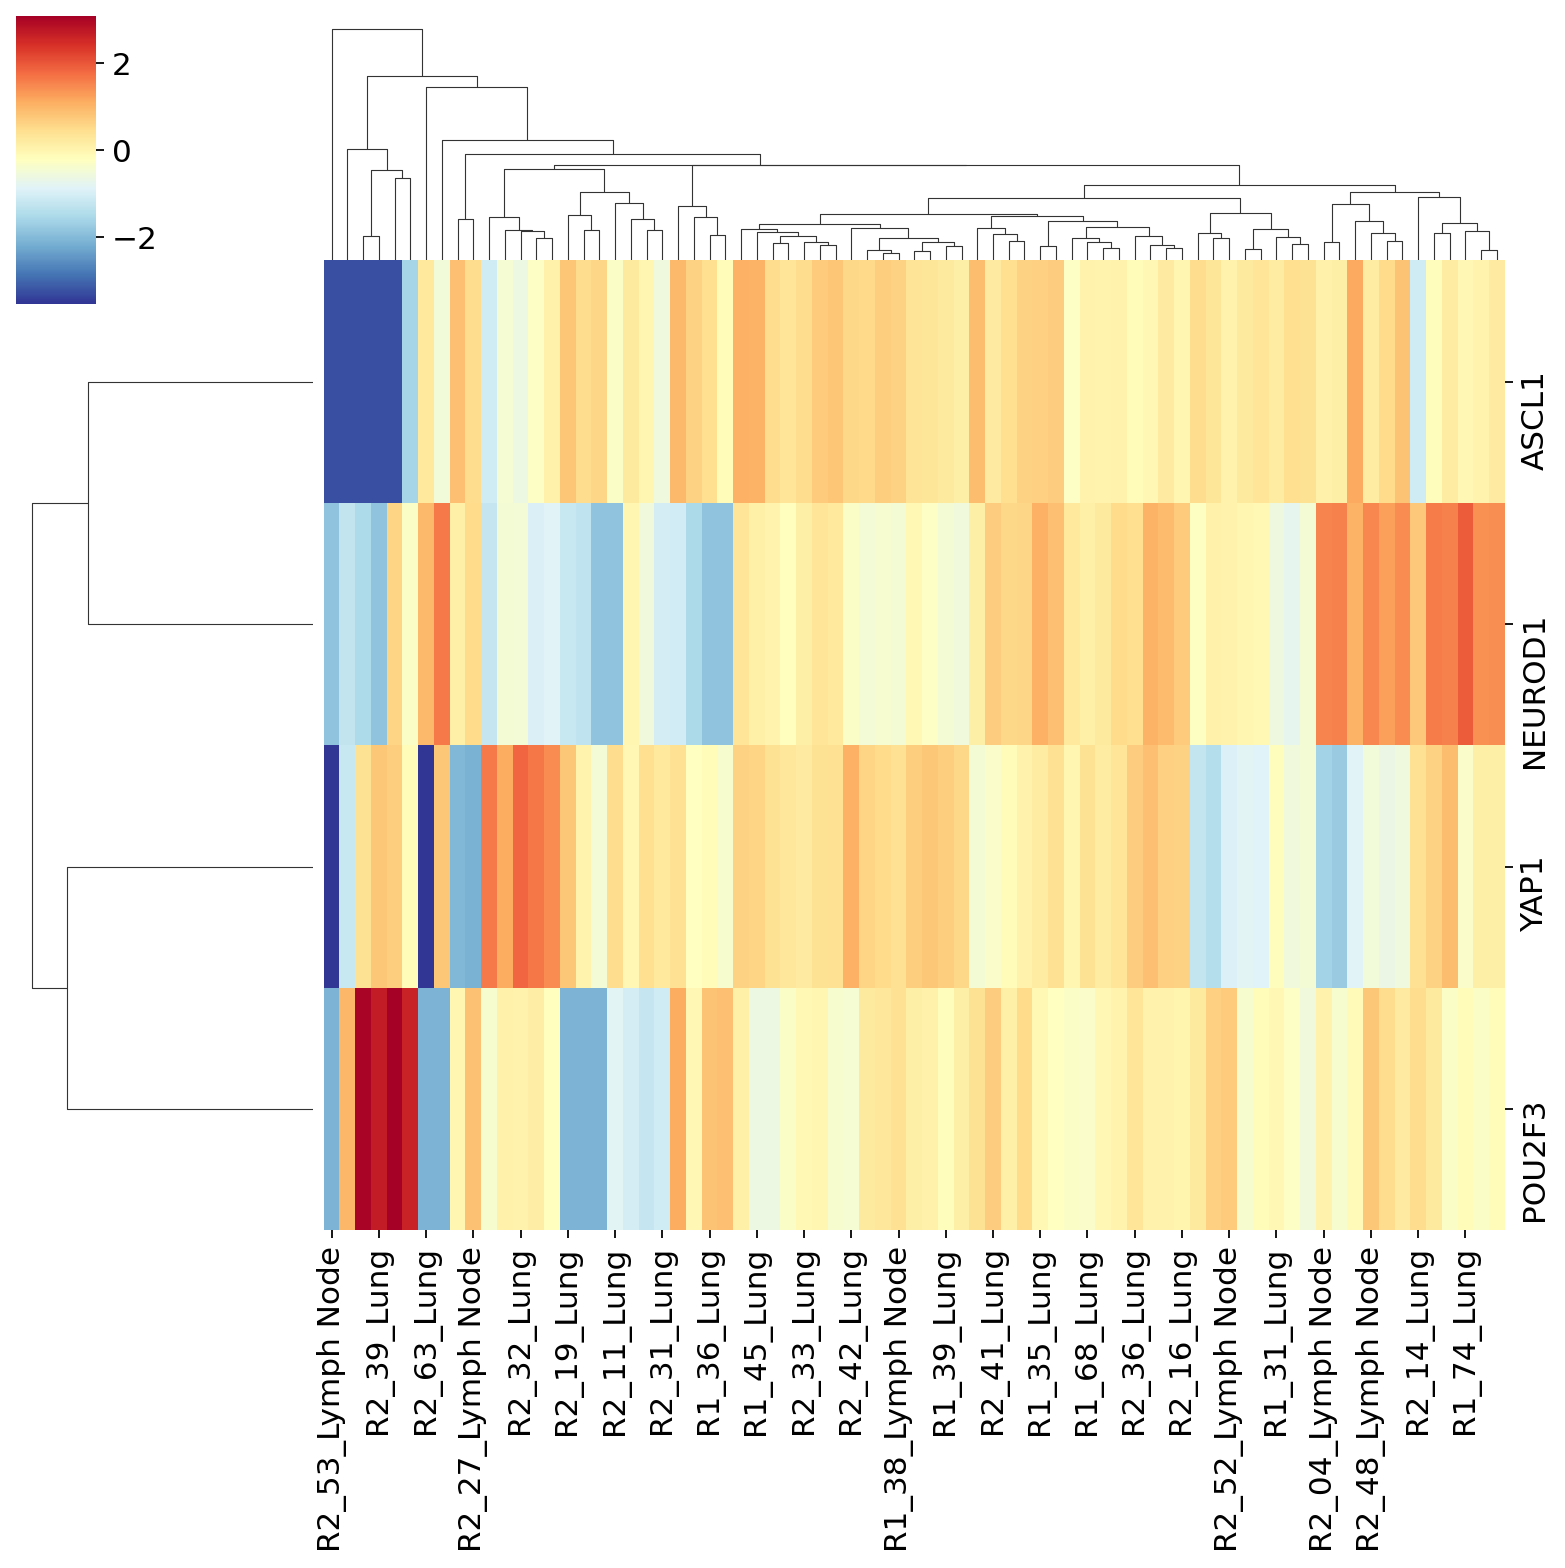

In [ ]:
dds_sub = dds[:, results_df[results_df.index.isin(["ASCL1","NEUROD1","POU2F3","YAP1"])].index]
grapher = pd.DataFrame(dds_sub.layers["log1p"].T, index=dds_sub.var_names, columns=dds_sub.obs_names)
grapher_sorted = grapher[sorted_columns]
sns.clustermap(grapher_sorted, z_score=0, cmap="RdYlBu_r",col_cluster=True)

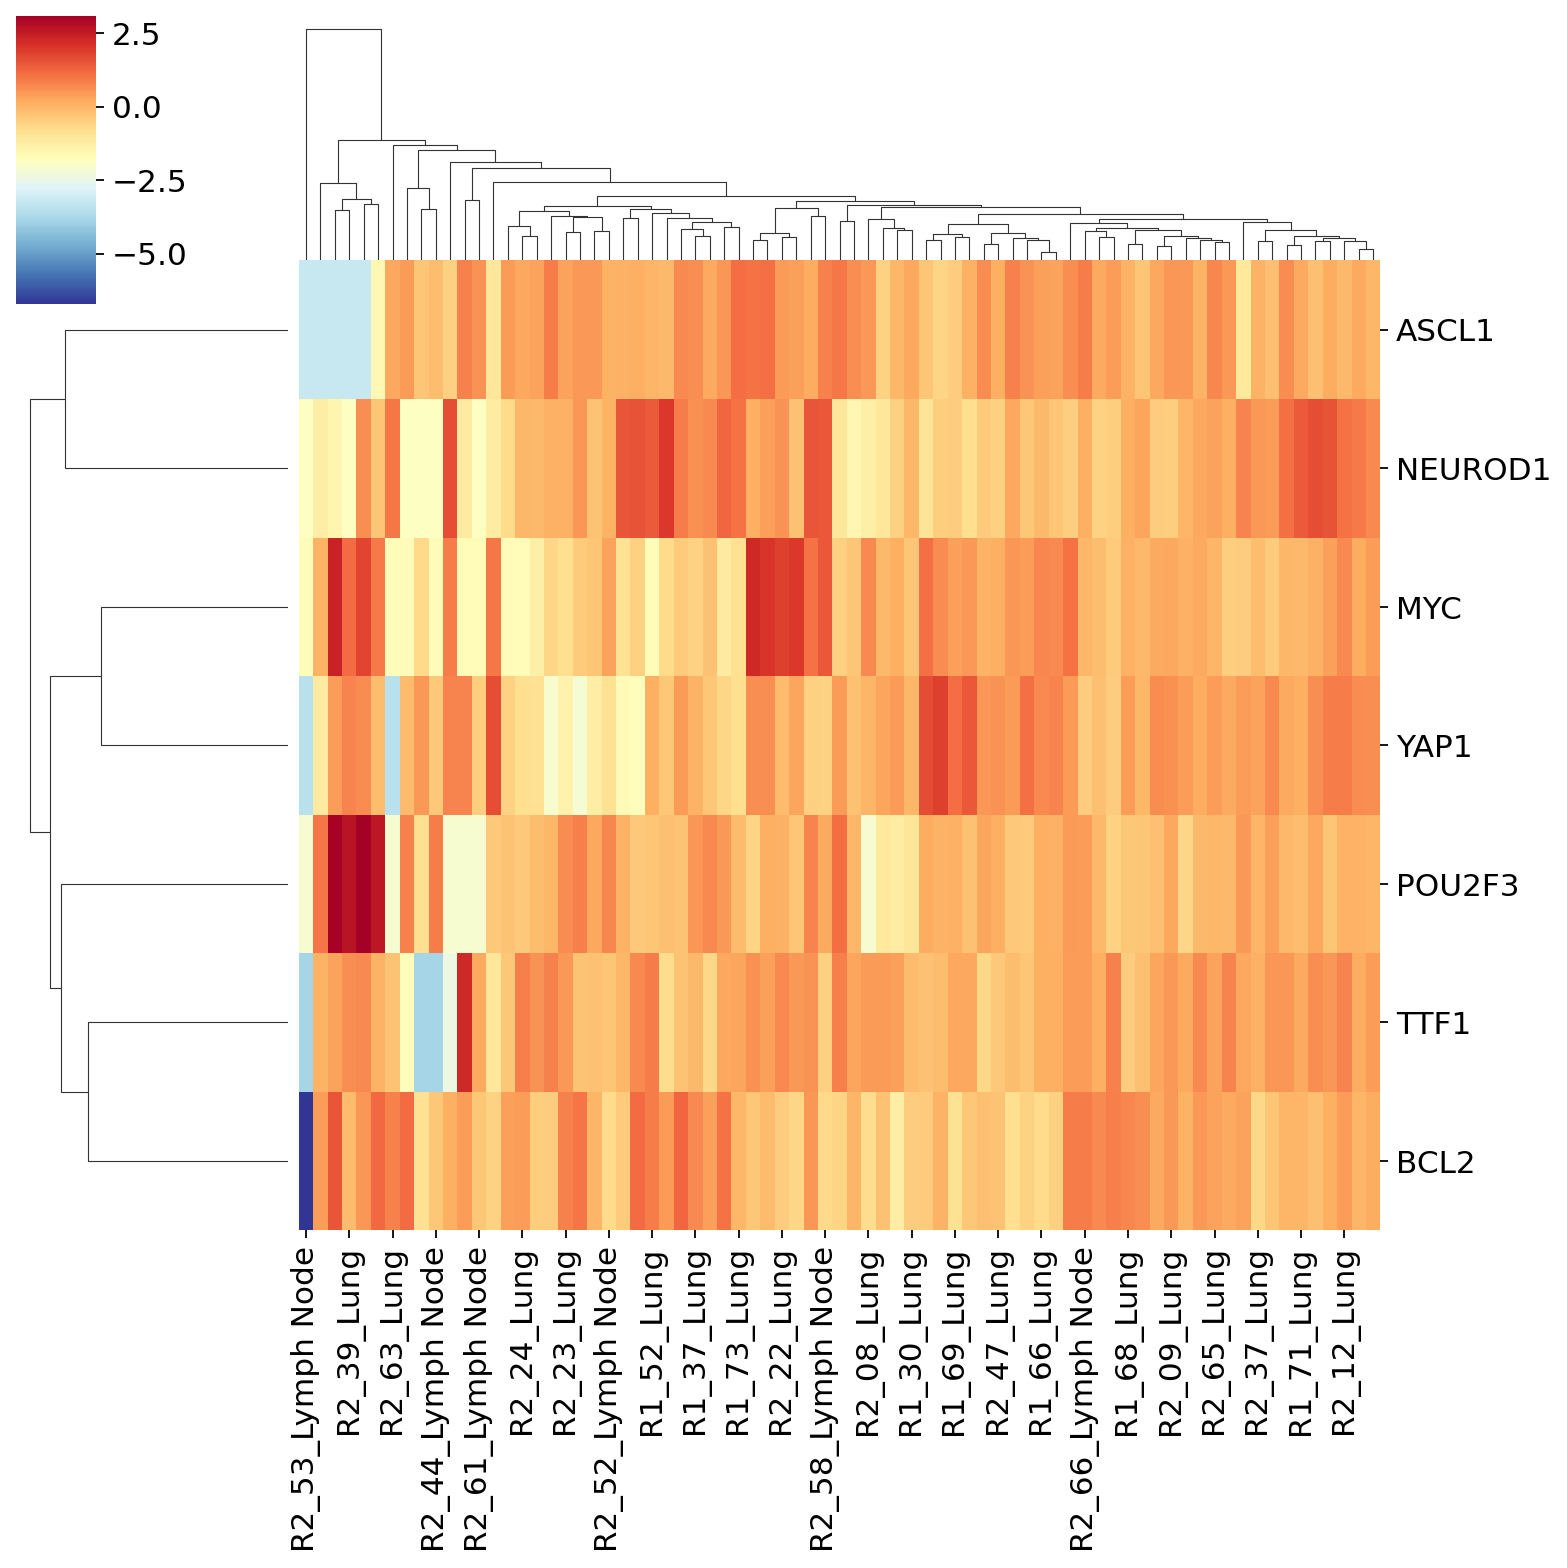

In [ ]:
sns.clustermap(grapher_sorted, z_score=0, cmap="RdYlBu_r",col_cluster=True)

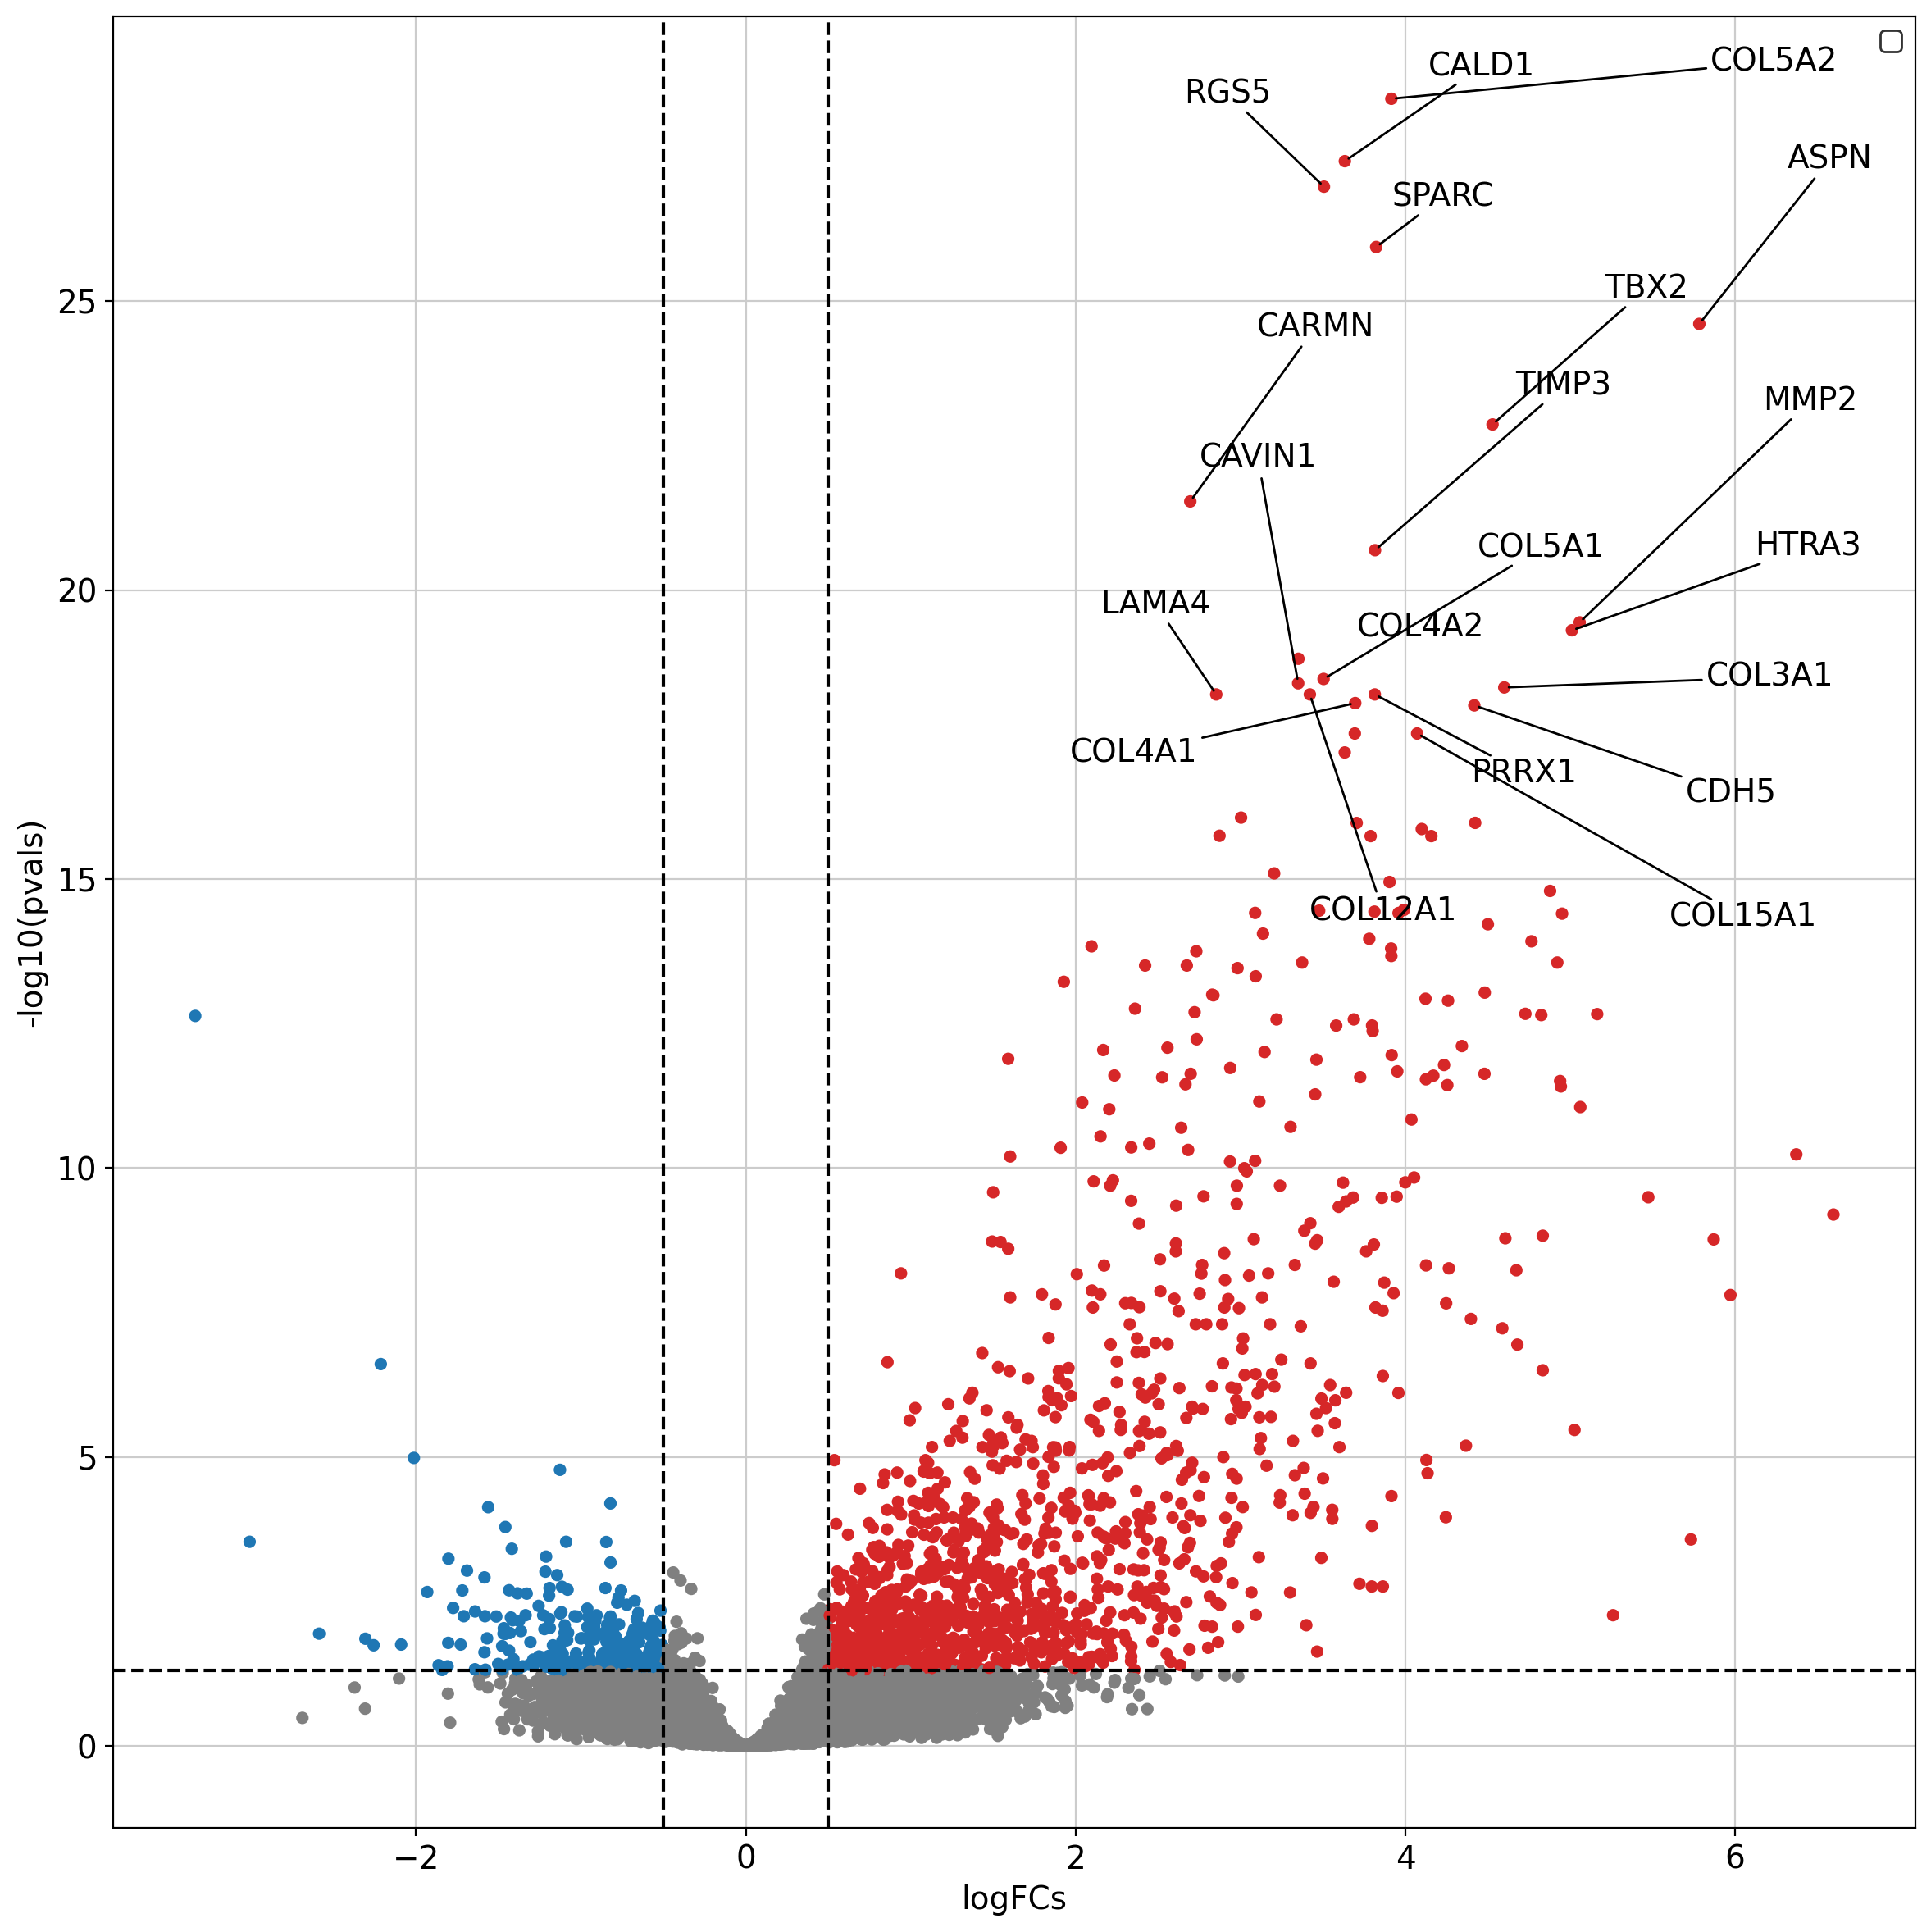

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
    )
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 12)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [ ]:
mat = results_df[['stat']].T.rename(index={'stat': 'Lung.vs.LymphNode'})
mat

TSPAN6      DPM1     SCYL3  C1orf112       FGR       CFH  \
Lung.vs.LymphNode  0.510409 -3.350035 -0.723524  1.011882  2.334571  3.566941   

                      FUCA2      GCLC      NFYA     STPG1  ...  \
Lung.vs.LymphNode  1.592982  0.769151  2.009626  0.492182  ...   

                   ENSG00000291275  ENSG00000291276  ANKRD20A11P-1  \
Lung.vs.LymphNode        -1.499804        -2.070219       0.400443   

                   ENSG00000291282  ENSG00000291283  ENSG00000291288  \
Lung.vs.LymphNode         1.448278        -1.255188        -2.385142   

                   ENSG00000291290  ENSG00000291299  ENSG00000291313   TMEM276  
Lung.vs.LymphNode        -2.100072         0.026996        -0.751064  0.276315  

[1 rows x 23219 columns]

# Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [ ]:
adata.write_h5ad("/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/qced_adata.h5ad")

TypeError: Can't implicitly convert non-string objects to strings

In [ ]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png" />

We can run `ulm` with a one-liner:

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts 	

Running ulm on mat with 1 samples and 23219 targets for 701 sources.


ABL1       AHR      AHRR       AIP      AIRE  \
Lung.vs.LymphNode -0.272535  4.693959 -1.958587  0.412649  1.851745   

                         AP1     APEX1        AR    ARID1A    ARID3A  ...  \
Lung.vs.LymphNode  11.203584  1.173592  7.515489  0.836594 -0.849808  ...   

                     ZNF362    ZNF382    ZNF384    ZNF395    ZNF436    ZNF699  \
Lung.vs.LymphNode  2.957221 -1.170319  4.424486  0.289466 -2.052598  2.176449   

                      ZNF76   ZNF804A     ZNF91      ZXDC  
Lung.vs.LymphNode  0.231242 -0.275438  4.088609  2.218354  

[1 rows x 701 columns]

In [ ]:
tf_acts

ABL1       AHR      AHRR       AIP      AIRE  \
Lung.vs.LymphNode -0.272535  4.693959 -1.958587  0.412649  1.851745   

                         AP1     APEX1        AR    ARID1A    ARID3A  ...  \
Lung.vs.LymphNode  11.203584  1.173592  7.515489  0.836594 -0.849808  ...   

                     ZNF362    ZNF382    ZNF384    ZNF395    ZNF436    ZNF699  \
Lung.vs.LymphNode  2.957221 -1.170319  4.424486  0.289466 -2.052598  2.176449   

                      ZNF76   ZNF804A     ZNF91      ZXDC  
Lung.vs.LymphNode  0.231242 -0.275438  4.088609  2.218354  

[1 rows x 701 columns]

Let us plot the obtained scores for the top active/inactive transcription factors:

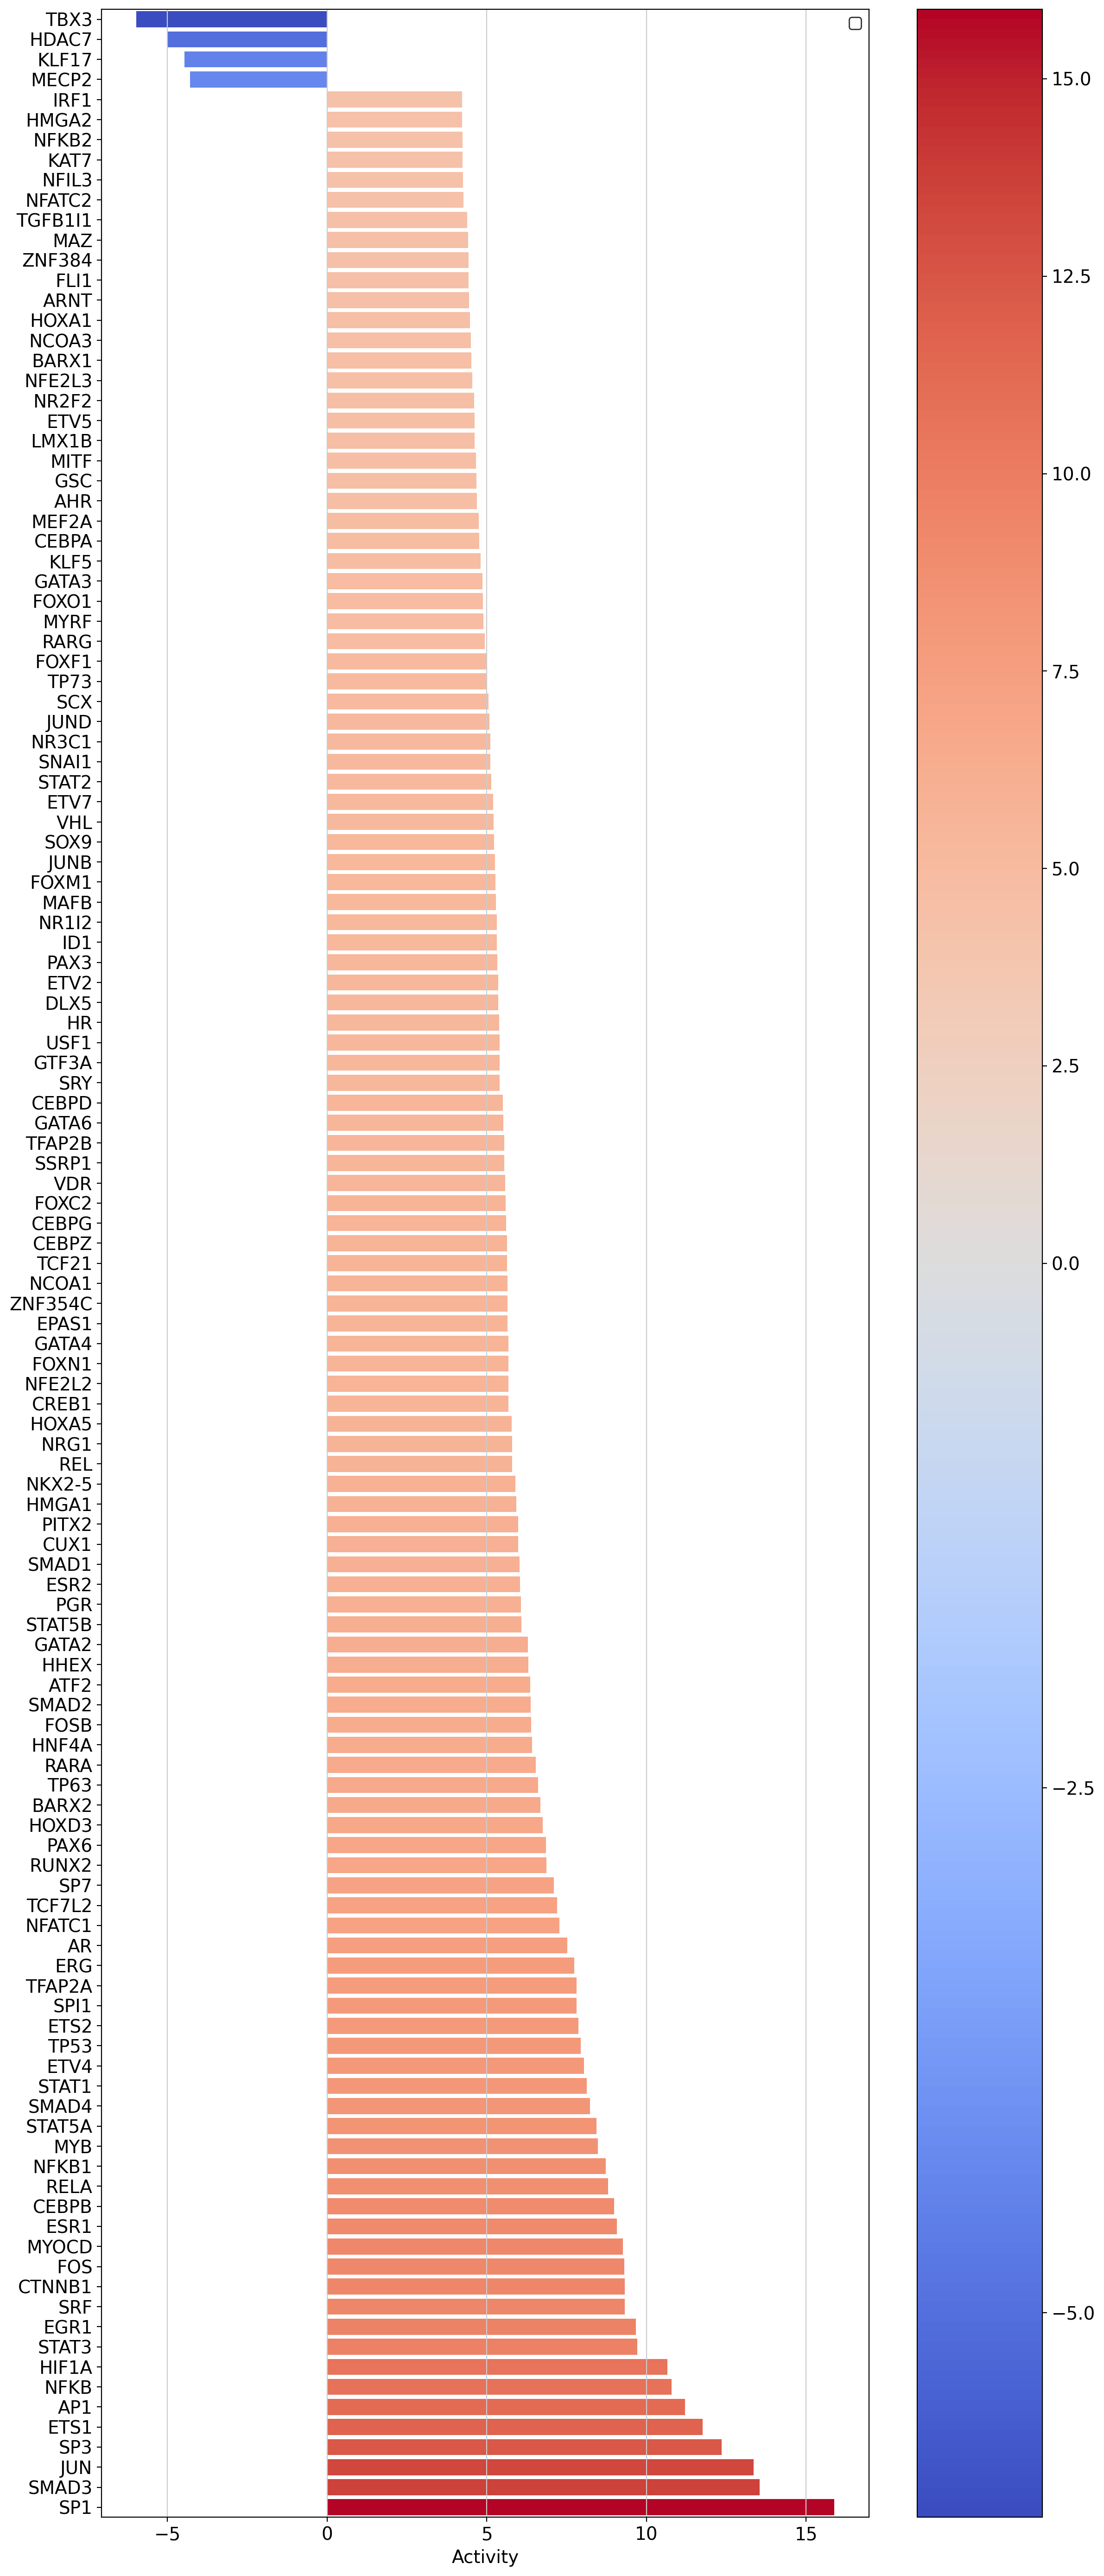

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(
		acts=tf_acts,
		contrast='Lung.vs.LymphNode',
		top=125,
		vertical=True,
	)
		
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 28)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

MYOCD SRF and JUNB seem to be the most activated in this treatment while IRF1, KLF11 AND ARID1A seem to be inactivated.

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

In [ ]:
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

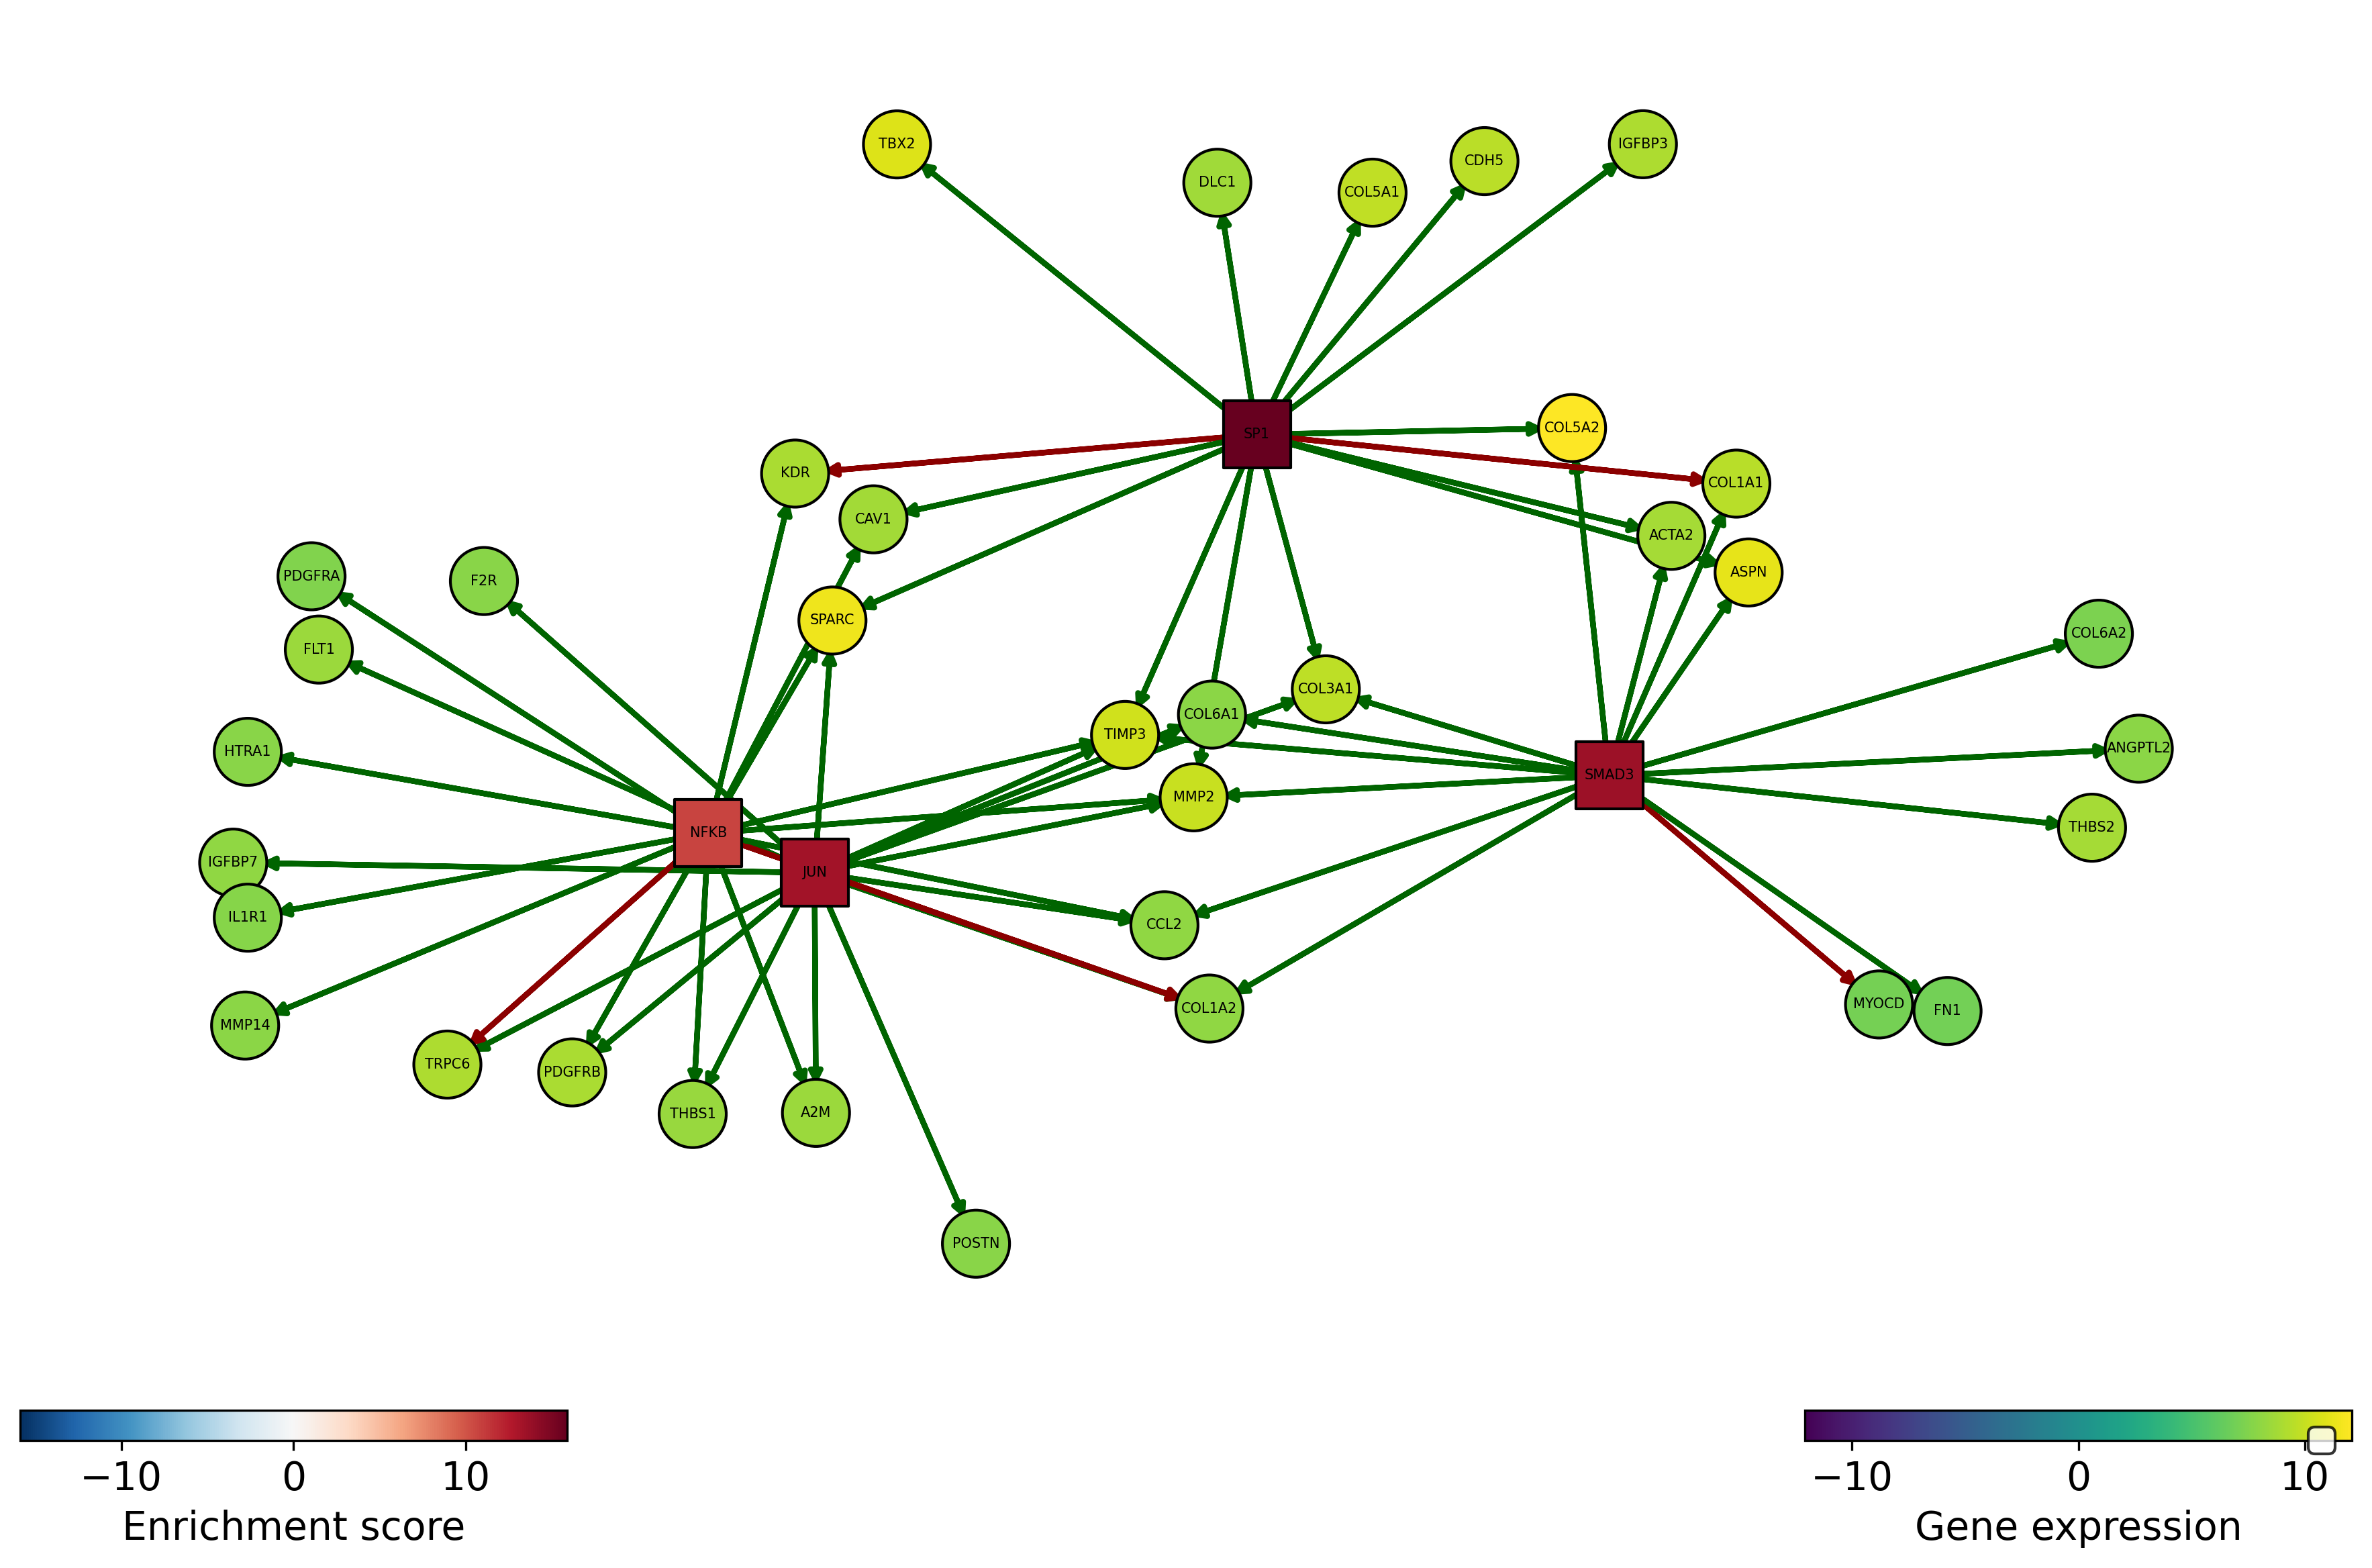

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_network(
		net=collectri,
		obs=mat,
		act=tf_acts,
		n_sources=['SP1', 'SMAD3', 'JUN', 'NFKB'],
		n_targets=15,
		node_size=100,
		figsize=(10, 10),
		c_pos_w='darkgreen',
		c_neg_w='darkred',
		vcenter=True
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

SRF seems to be active in treated cells since their positive targets are up-regulated.

If needed, we can also look at a volcano plot of the target genes:

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Lung.vs.LymphNode'})
pvals = results_df[['padj']].T.rename(index={'padj': 'Lung.vs.LymphNode'})

# Plot


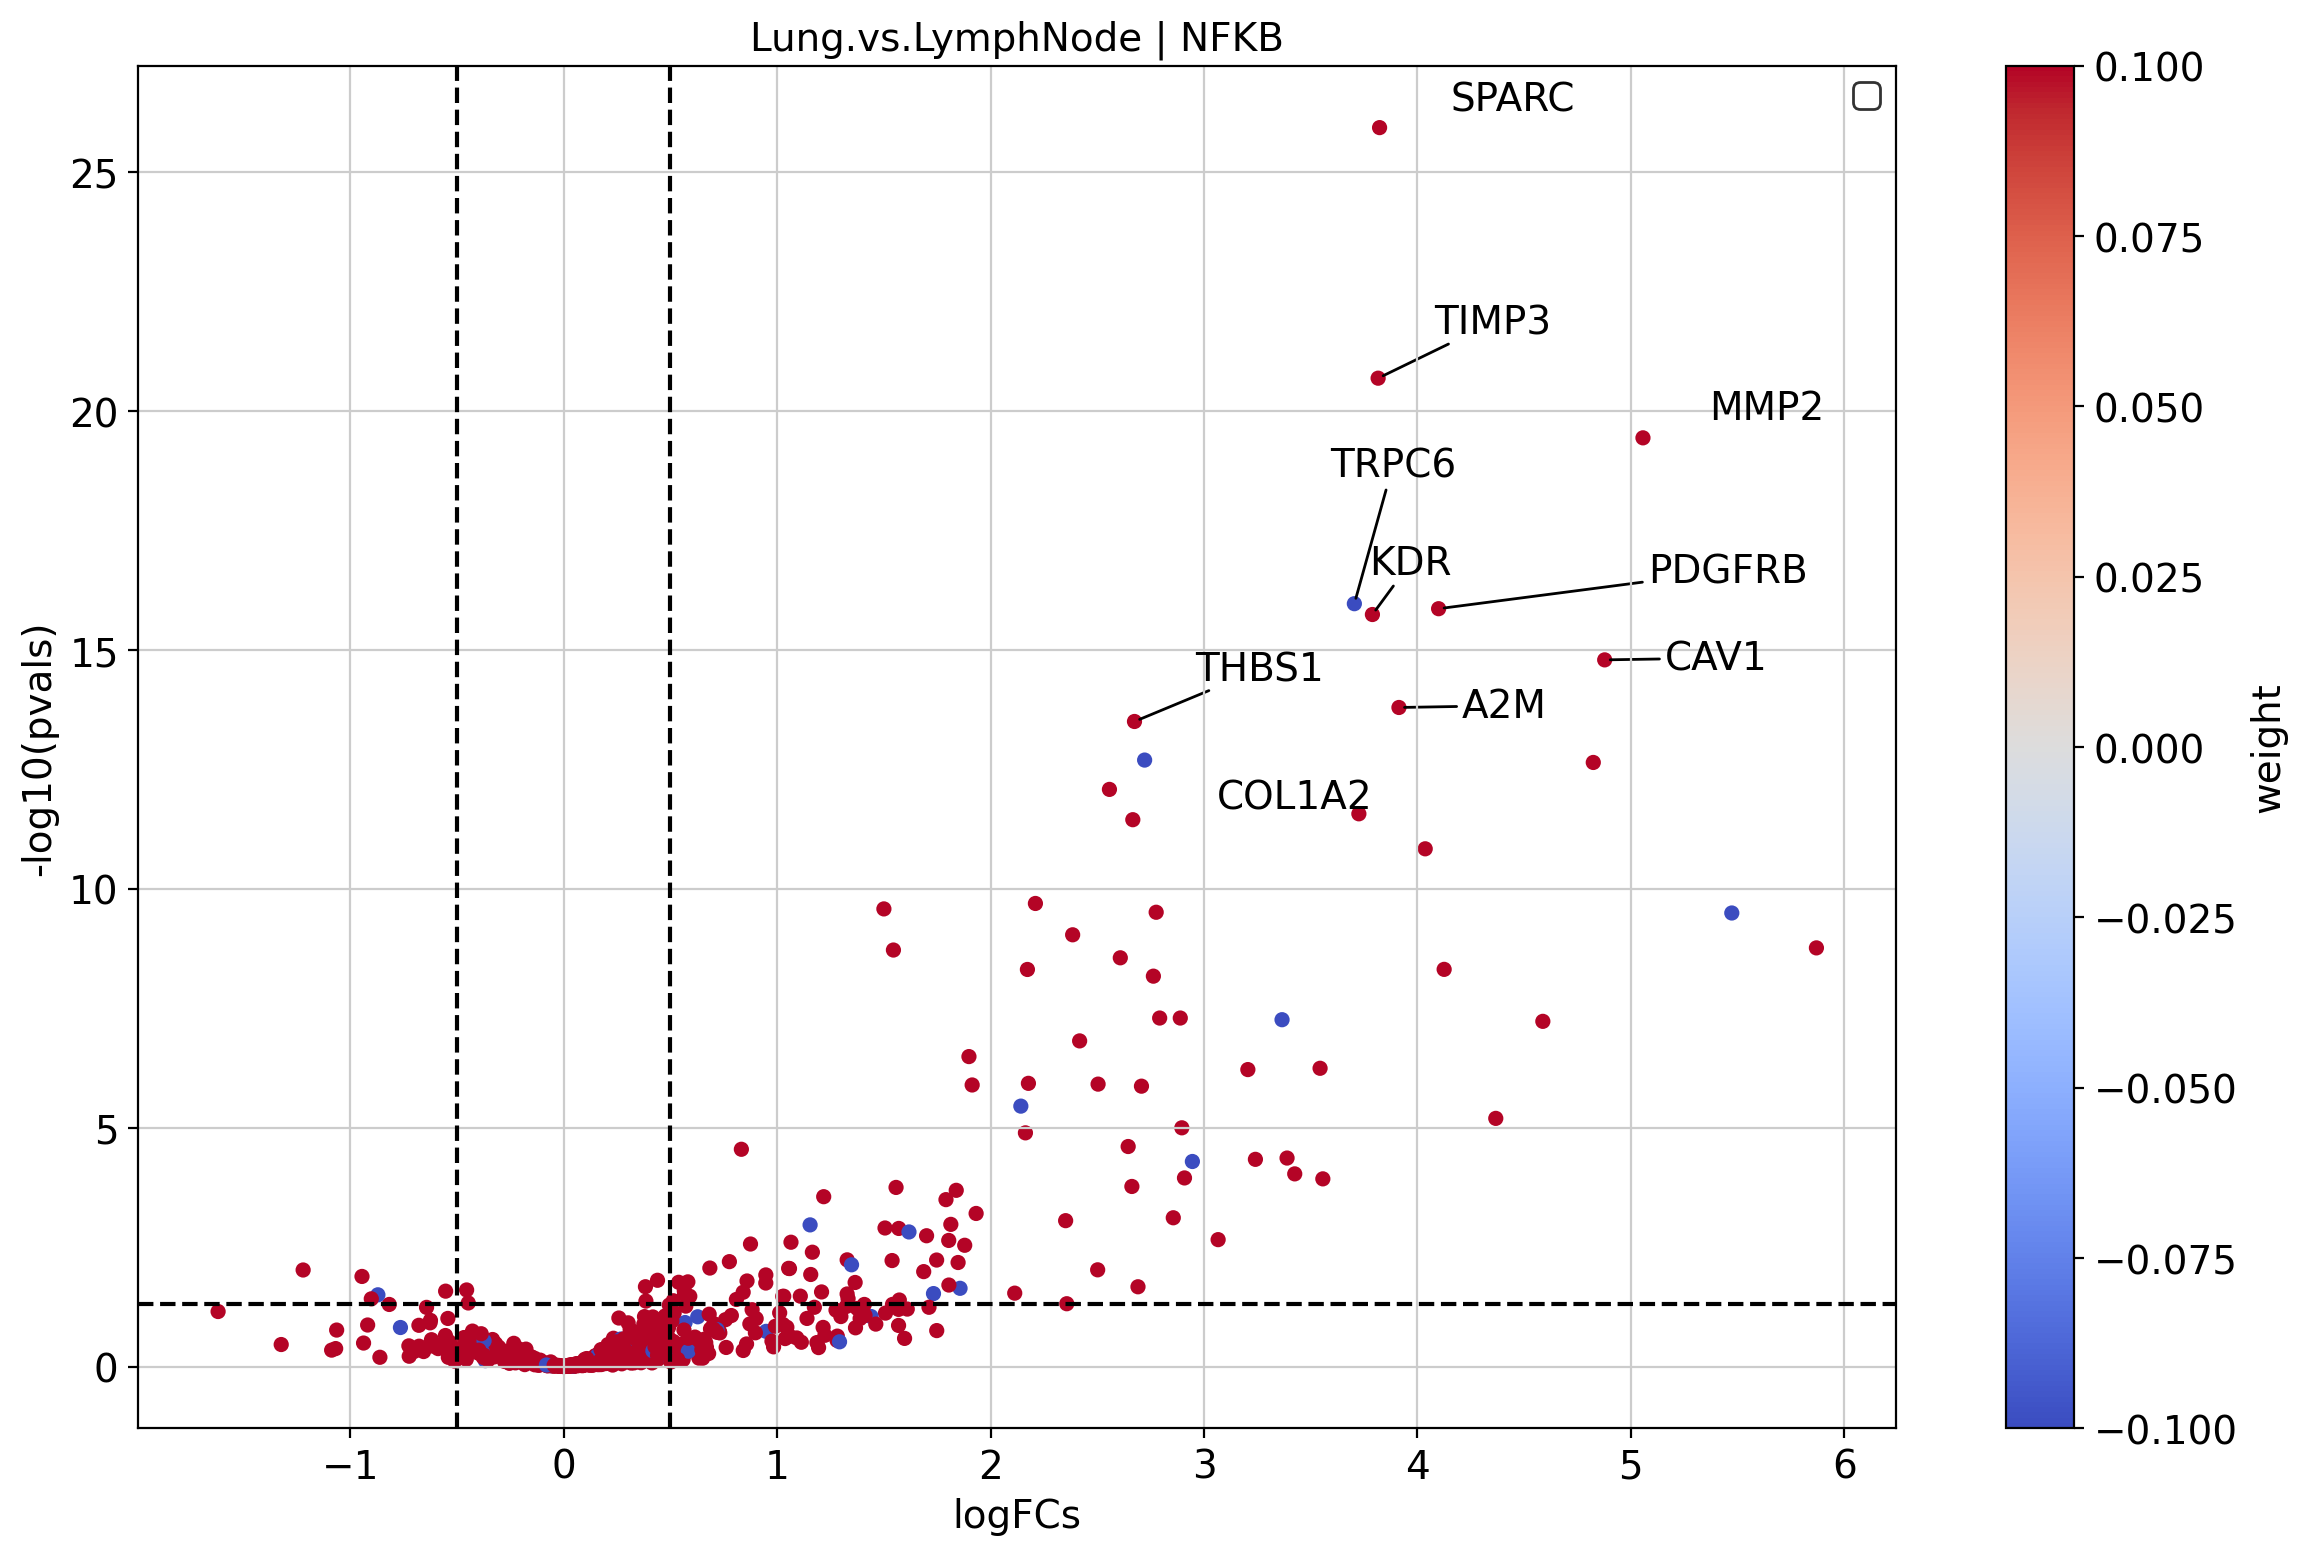

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_volcano(
        logFCs,
        pvals,
        'Lung.vs.LymphNode',
        name='NFKB',
        net=collectri,
        top=10,
        sign_thr=0.05,
        lFCs_thr=0.5
    )
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [ ]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.242078e-44
2     Androgen   MBOAT2  10.472733  4.624285e-44
3     Androgen     KLK2  10.176186  1.944414e-40
4     Androgen     SARG  11.386852  2.790209e-40
...        ...      ...        ...           ...
6995       p53    ZMYM4  -2.325752  1.522388e-06
6996       p53    CFDP1  -1.628168  1.526045e-06
6997       p53   VPS37D   2.309503  1.537098e-06
6998       p53    TEDC1  -2.274823  1.547037e-06
6999       p53  CCDC138  -3.205113  1.568160e-06

[7000 rows x 4 columns]

### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />
     
We can run `mlm` with a one-liner:

In [ ]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 23219 targets for 14 sources.


Androgen      EGFR  Estrogen  Hypoxia  JAK-STAT      MAPK  \
Lung.vs.LymphNode  4.885453  0.500617  1.154012  0.13278    6.6437  0.982684   

                       NFkB      PI3K       TGFb      TNFa    Trail      VEGF  \
Lung.vs.LymphNode  0.369918  1.468549  14.149863  4.829954  0.73279  1.755929   

                        WNT       p53  
Lung.vs.LymphNode  2.536787  2.829577

Let us plot the obtained scores:

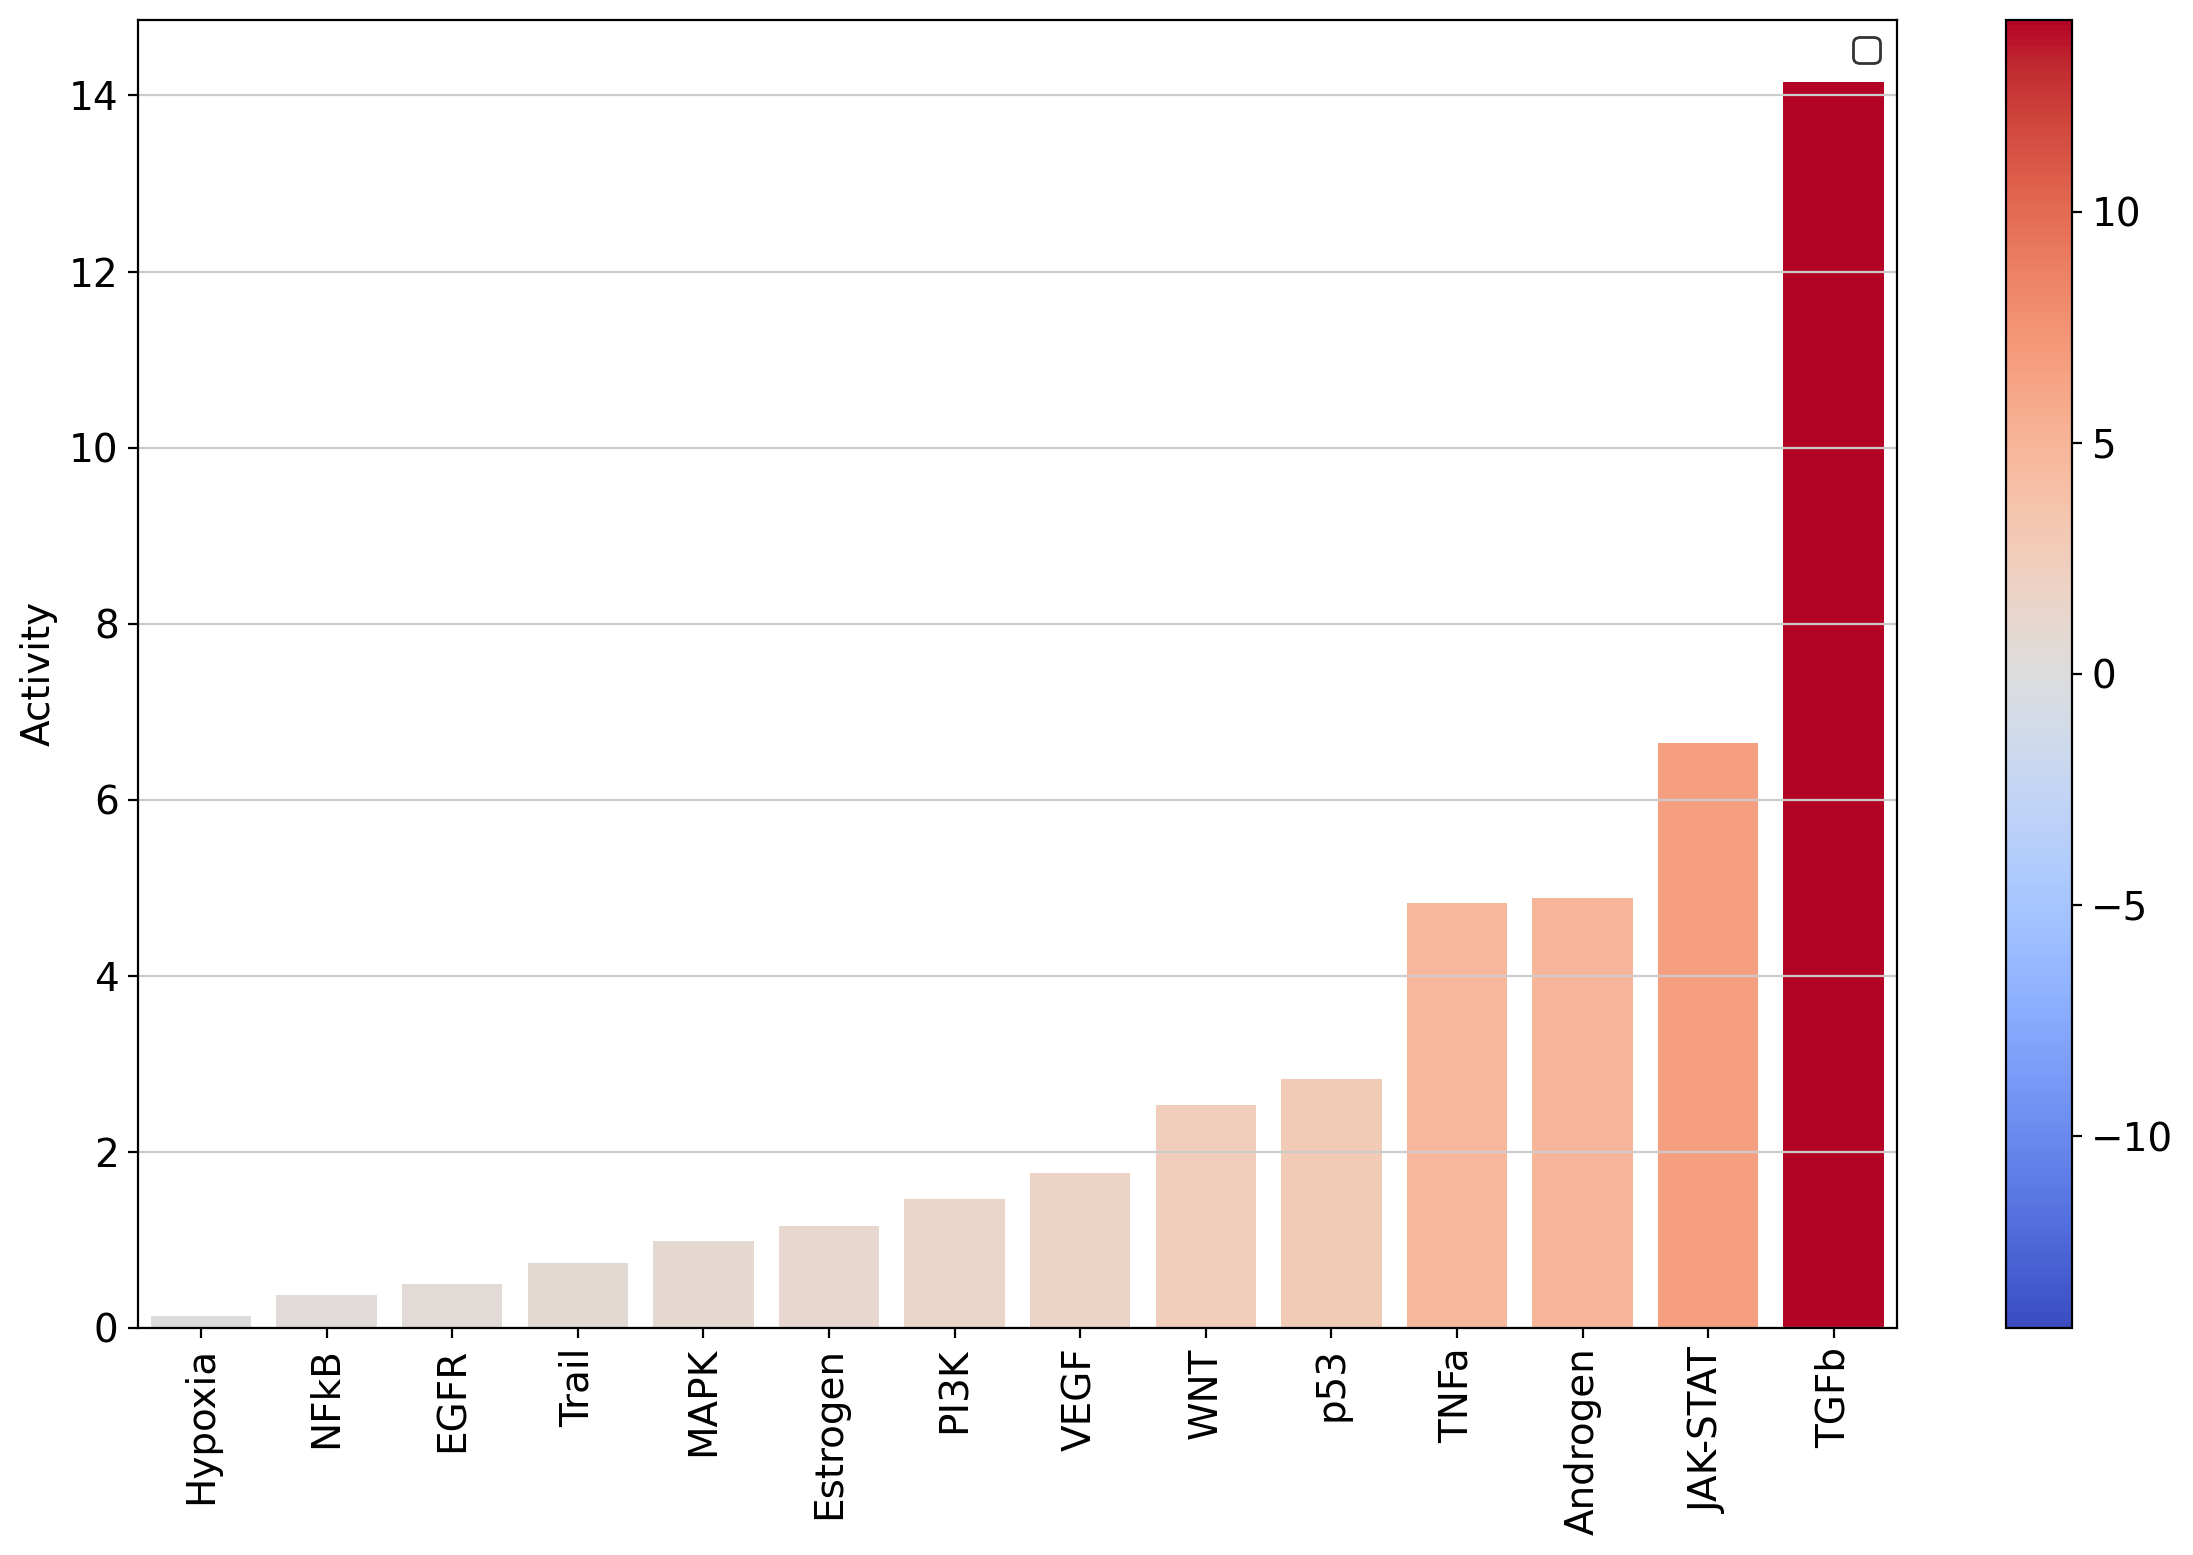

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(
		pathway_acts,
		'Lung.vs.LymphNode',
		top=25,
		vertical=False,
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

As expected, after treating cells with the cytokine TGFb we see an increase of activity for this pathway.

On the other hand, it seems that this treatment has decreased the activity of other pathways like JAK-STAT or TNFa.

We can visualize the targets of TFGb in a scatter plot:

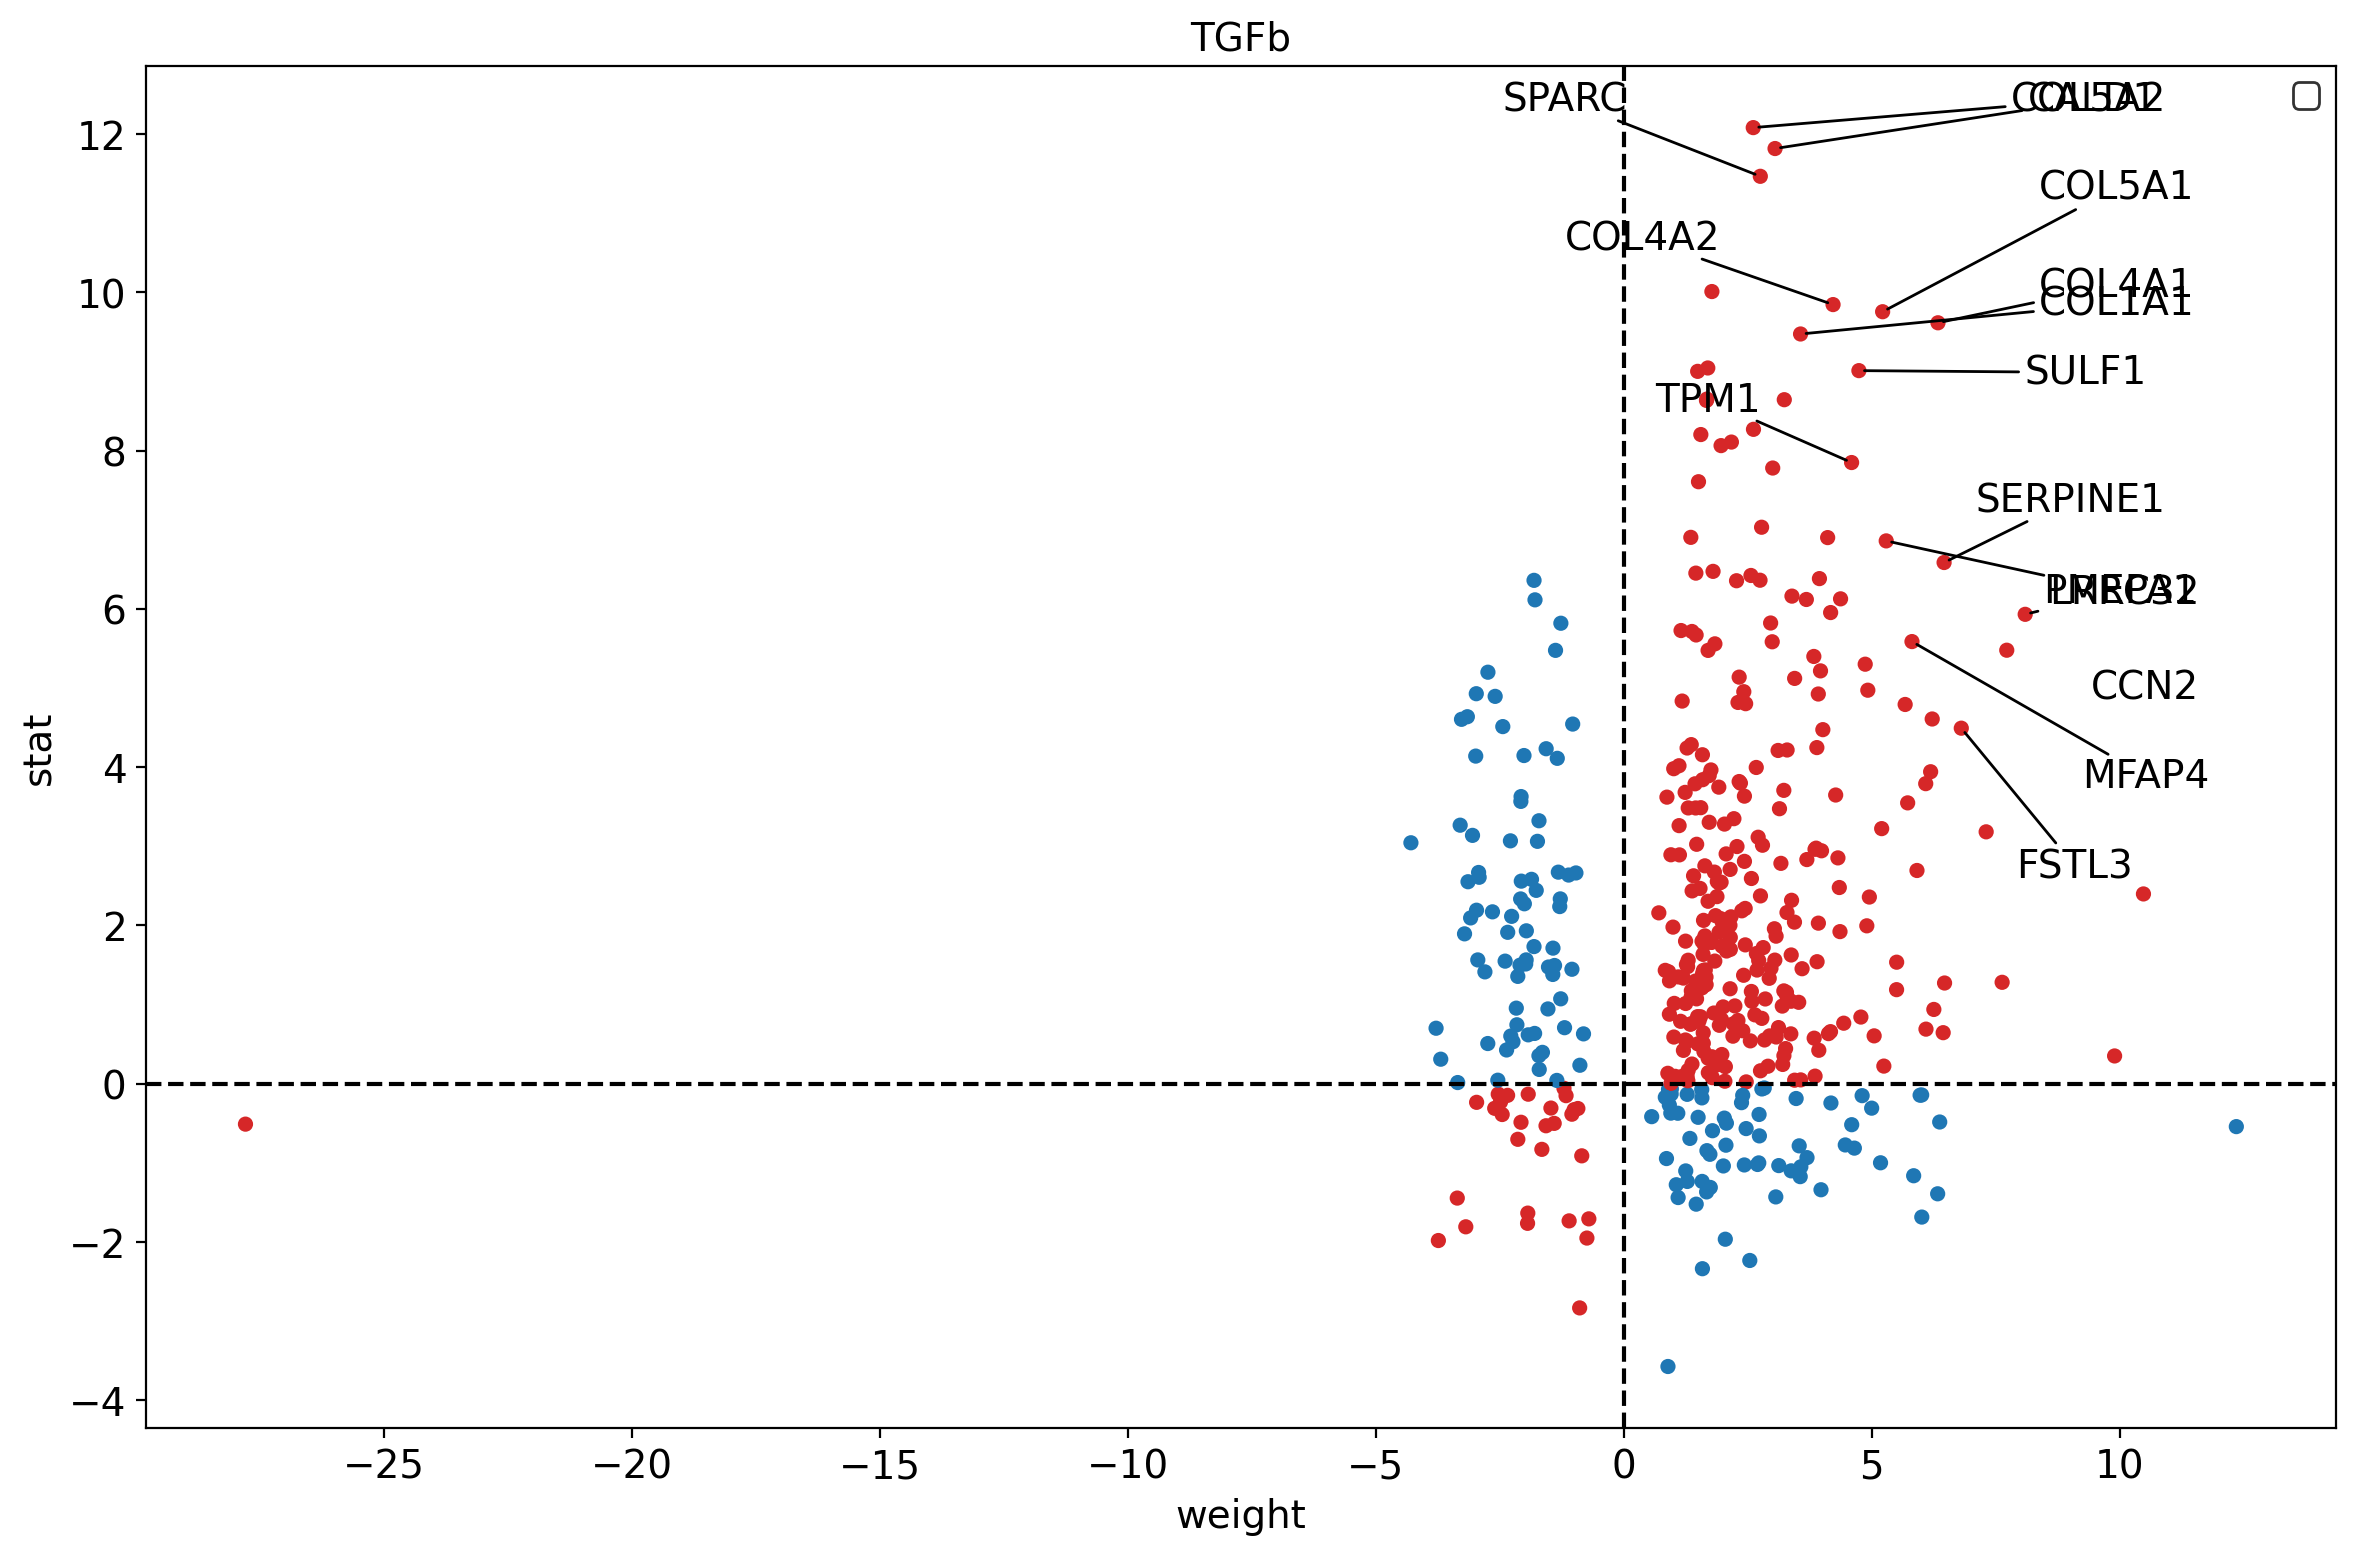

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

The observed activation of TGFb is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

# Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [ ]:
msigdb = dc.get_resource('MSigDB')
msigdb

genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [ ]:
progeny = dc.get_progeny(organism='human', top=500)
progeny

source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.242078e-44
2     Androgen   MBOAT2  10.472733  4.624285e-44
3     Androgen     KLK2  10.176186  1.944414e-40
4     Androgen     SARG  11.386852  2.790209e-40
...        ...      ...        ...           ...
6995       p53    ZMYM4  -2.325752  1.522388e-06
6996       p53    CFDP1  -1.628168  1.526045e-06
6997       p53   VPS37D   2.309503  1.537098e-06
6998       p53    TEDC1  -2.274823  1.547037e-06
6999       p53  CCDC138  -3.205113  1.568160e-06

[7000 rows x 4 columns]

In [ ]:
adata.raw = adata.copy()

In [ ]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running mlm on mat with 75 samples and 23219 targets for 14 sources.


In [ ]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 75 × 23219
    obs: 'External_ID', 'Project_ID', 'Organism', 'Sample-Biosource', 'RIN', 'Concentration', 'Flowcell_Name', 'Flowcell_ID', 'R1', 'R1_md5sum', 'R2', 'R2_md5sum', 'batch', 'leiden', 'group', 'Negative Radiation Sensitivity (RS)', 'RSI'
    var: 'ENSG', 'chrom', 'source', 'start', 'end', 'strand', 'gene_version', 'gene_source', 'gene_biotype', 'gc_content', 'length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Sample_Biosource_colors', 'leiden', 'dendrogram_leiden', 'trend_coeffs', '_squared_logres', 'prior_disp_var', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'design_matrix', 'size_factors', 'replaceable', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs', 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispe

In [ ]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 75 × 14
    obs: 'External_ID', 'Project_ID', 'Organism', 'Sample-Biosource', 'RIN', 'Concentration', 'Flowcell_Name', 'Flowcell_ID', 'R1', 'R1_md5sum', 'R2', 'R2_md5sum', 'batch', 'leiden', 'group', 'Negative Radiation Sensitivity (RS)', 'RSI'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Sample_Biosource_colors', 'leiden', 'dendrogram_leiden', 'trend_coeffs', '_squared_logres', 'prior_disp_var', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'design_matrix', 'size_factors', 'replaceable', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

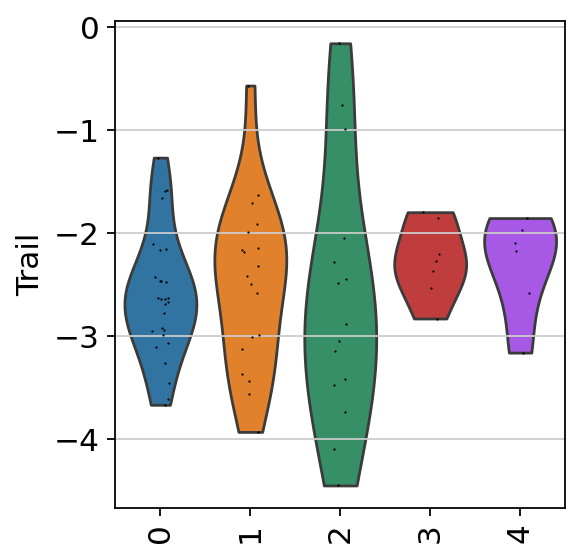

In [ ]:
sc.pl.violin(acts, keys=['Trail'], groupby='leiden', rotation=90)

In [ ]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [ ]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

Term  Set size  Overlap ratio       p-value   FDR p-value  \
0         ADIPOGENESIS       200       0.105000  1.527102e-01  2.580275e-01   
1  ALLOGRAFT_REJECTION       200       0.140000  4.142775e-03  1.068400e-02   
2    ANDROGEN_RESPONSE       100       0.270000  2.392153e-08  1.065595e-07   
3         ANGIOGENESIS        36       0.444444  6.539722e-09  3.204464e-08   
4      APICAL_JUNCTION       200       0.245000  2.820192e-12  2.763788e-11   

   Odds ratio  Combined score  \
0    1.300610        2.444124   
1    1.731489        9.499621   
2    3.347931       58.751131   
3    5.511480      103.865880   
4    3.046683       81.024145   

                                            Features  
0  ABCA1;C3;CAVIN1;CAVIN2;CD302;COL15A1;COL4A1;FZ...  
1  B2M;BCAT1;CAPG;CCL2;CCND2;CCR5;CSF1;CSK;CXCL9;...  
2  ACTN1;ADAMTS1;AKAP12;ALDH1A3;ARID5B;B2M;B4GALT...  
3  CCND2;COL3A1;COL5A2;CXCL6;FSTL1;ITGAV;JAG1;KCN...  
4  ACTB;ACTG2;ACTN1;ADAMTS5;B4GALT1;BMP1;CAP1;CD2...

Then we can visualize the most enriched terms:

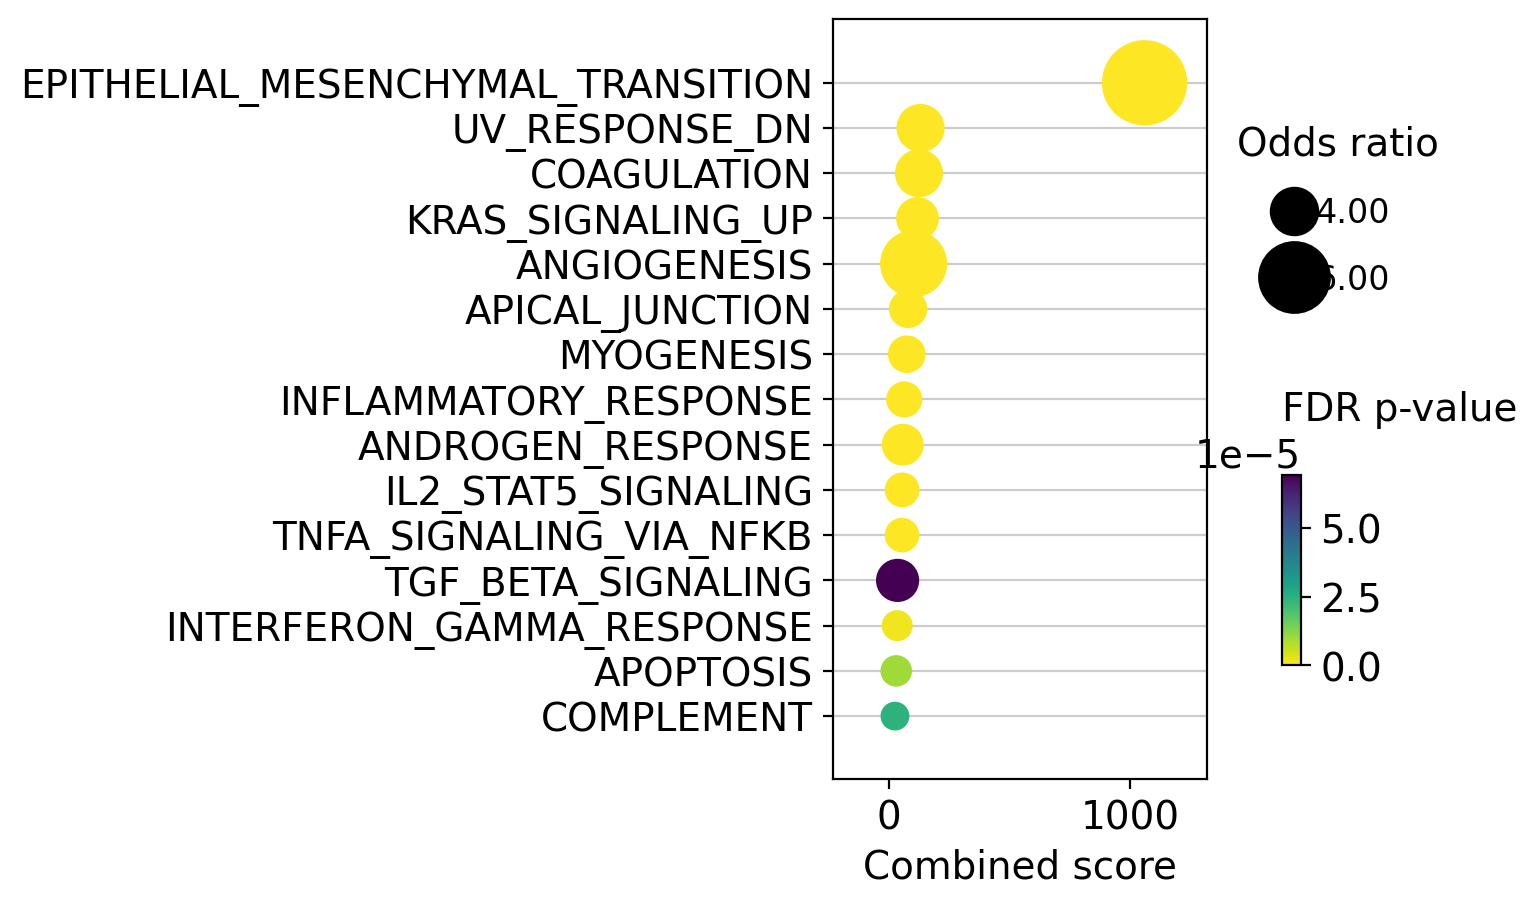

In [ ]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.7,
)

TNFa and interferons response (JAK-STAT) processes seem to be enriched. We previously observed a similar result with the PROGENy pathways, were they were significantly downregulated. Therefore, one of the limitations of using a prior knowledge resource without weights is that it doesn't provide direction.

We can also plot the running score for a given gene set:

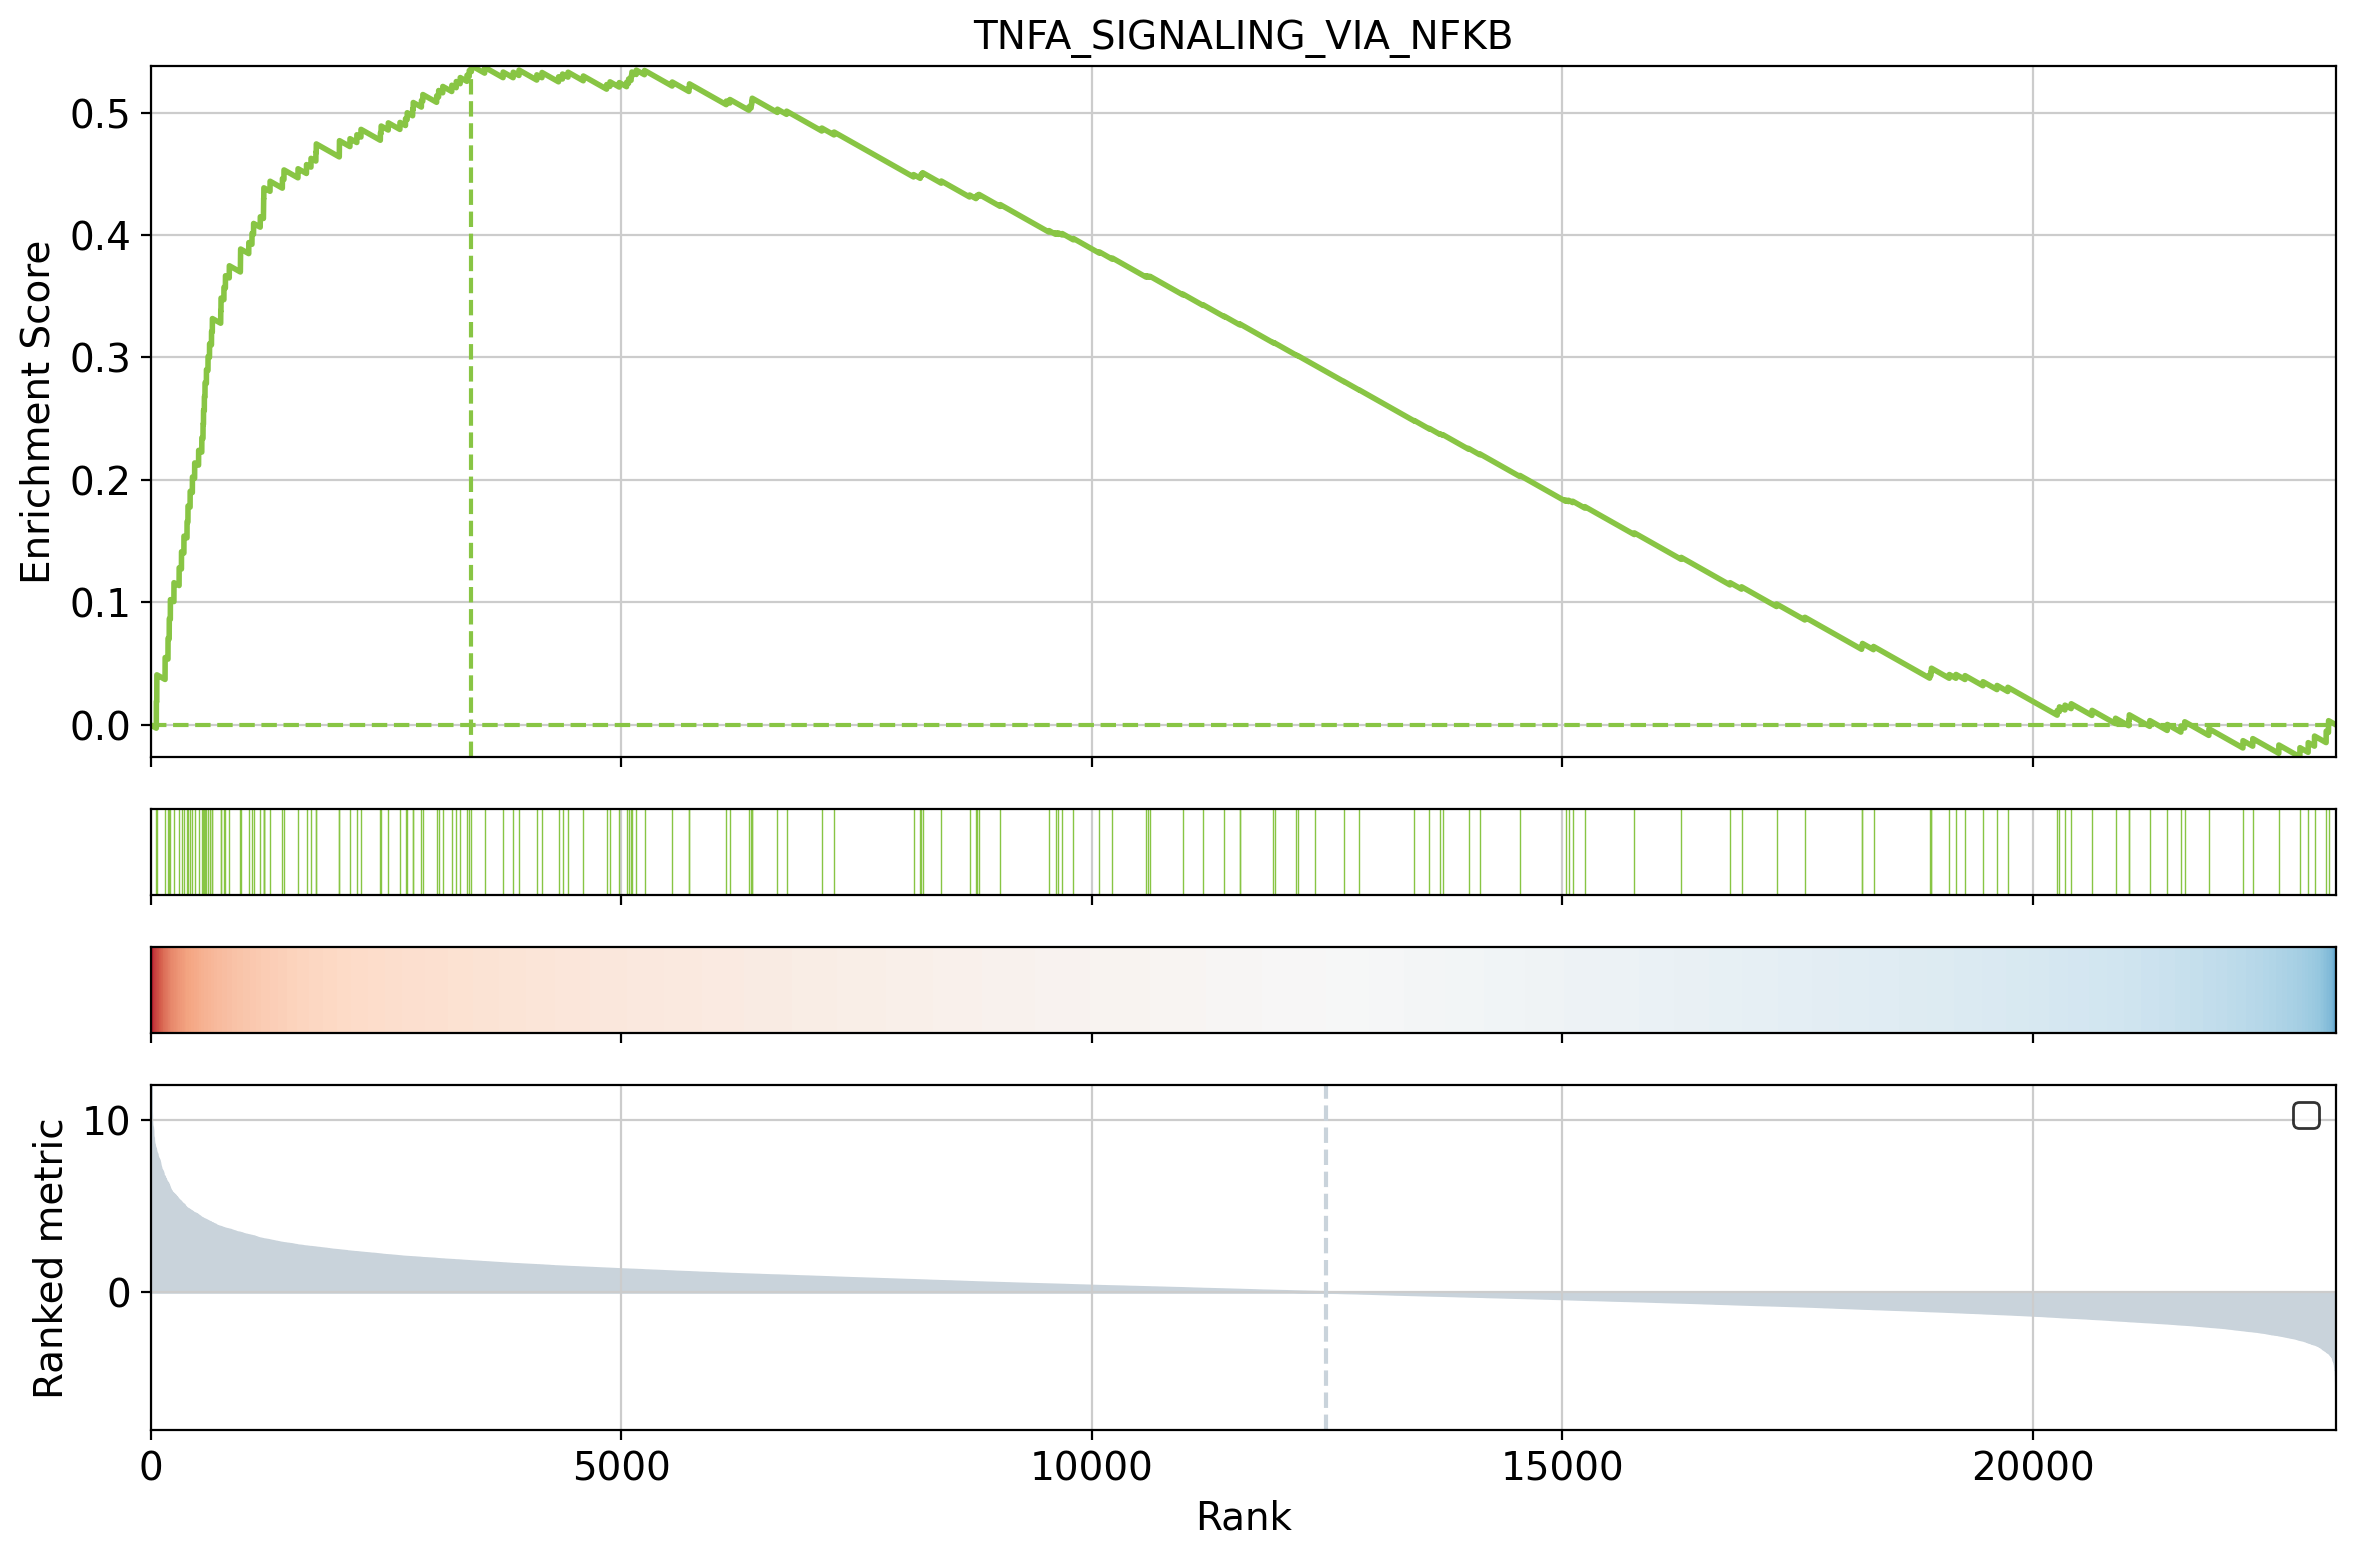

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_running_score(
		df=results_df,
		stat='stat',
		net=msigdb,
		source='geneset',
		target='genesymbol',
		set_name='TNFA_SIGNALING_VIA_NFKB'
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Enrichment of ligand-receptor interactions

Recently, study of interactions between ligands and receptors have gained significant traction, notably pushed by the democratization of single cell sequencing technologies. While most methods (such as the one described in LIANA) are developed for single cell datasets, they rely on a relatively simple assumption of co-expression or co-regulation of two (or more in the context of complexes) genes acting as ligand and receptors to propose hypothetical ligand-receptor interaction events. This concept can seamlessly be applied to a bulk RNA dataset, where the assumption is that sender and receiver cells are convoluted in a single dataset, but the observation of significant co-regulation of ligand and receptors should still correspond to hypothetical ligand-receptor interaction events.

At the core, most current ligand-receptor interaction methods rely on averaging the measurements obtained for ligand and receptor and standardizing them against a background distribution.  Thus, an enrichment method based on a weighted mean can emulate this, where the sets are simply the members of a ligand receptor pair (or more in the context of complexes).

Thus, we can extract ligand-receptor interaction ressources from the LIANA package (available both in [R](https://saezlab.github.io/liana/) and [python](https://liana-py.readthedocs.io/en/latest/)), and use it as a prior knowledge network with decoupler to find the most significant pairs of ligand-receptors in a given bulk dataset.

While more work is required to fully understand the functional relevance of the highlighted ligand-receptor interactions with such an approach, this represents a very straightforward and intuitive approach to embed a bulk RNA dataset with ligand-receptor interaction prior knowledge.


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.

In [ ]:
import liana as ln

liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

liana_lr

interaction   genes  weight
0     LGALS9&PTPRC  LGALS9       1
1       LGALS9&MET  LGALS9       1
2      LGALS9&CD44  LGALS9       1
3      LGALS9&LRP1  LGALS9       1
4      LGALS9&CD47  LGALS9       1
...            ...     ...     ...
5775    BMP2&ACTR2   ACTR2       1
5776   BMP15&ACTR2   ACTR2       1
5777    CSF1&CSF3R   CSF3R       1
5778  IL36G&IFNAR1  IFNAR1       1
5779  IL36G&IFNAR2  IFNAR2       1

[10381 rows x 3 columns]

In [ ]:
"ASCL1" in liana_lr["genes"]

False

In [ ]:
# Choose ROI and add guides on the external of the slice

Then we can use `ulm` to find the significant co-regulated pairs of ligand and receptors.

In [ ]:
mat

TSPAN6      DPM1     SCYL3  C1orf112       FGR       CFH  \
Lung.vs.LymphNode  0.510409 -3.350035 -0.723524  1.011882  2.334571  3.566941   

                      FUCA2      GCLC      NFYA     STPG1  ...  \
Lung.vs.LymphNode  1.592982  0.769151  2.009626  0.492182  ...   

                   ENSG00000291275  ENSG00000291276  ANKRD20A11P-1  \
Lung.vs.LymphNode        -1.499804        -2.070219       0.400443   

                   ENSG00000291282  ENSG00000291283  ENSG00000291288  \
Lung.vs.LymphNode         1.448278        -1.255188        -2.385142   

                   ENSG00000291290  ENSG00000291299  ENSG00000291313   TMEM276  
Lung.vs.LymphNode        -2.100072         0.026996        -0.751064  0.276315  

[1 rows x 23219 columns]

In [ ]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 23219 targets for 3082 sources.


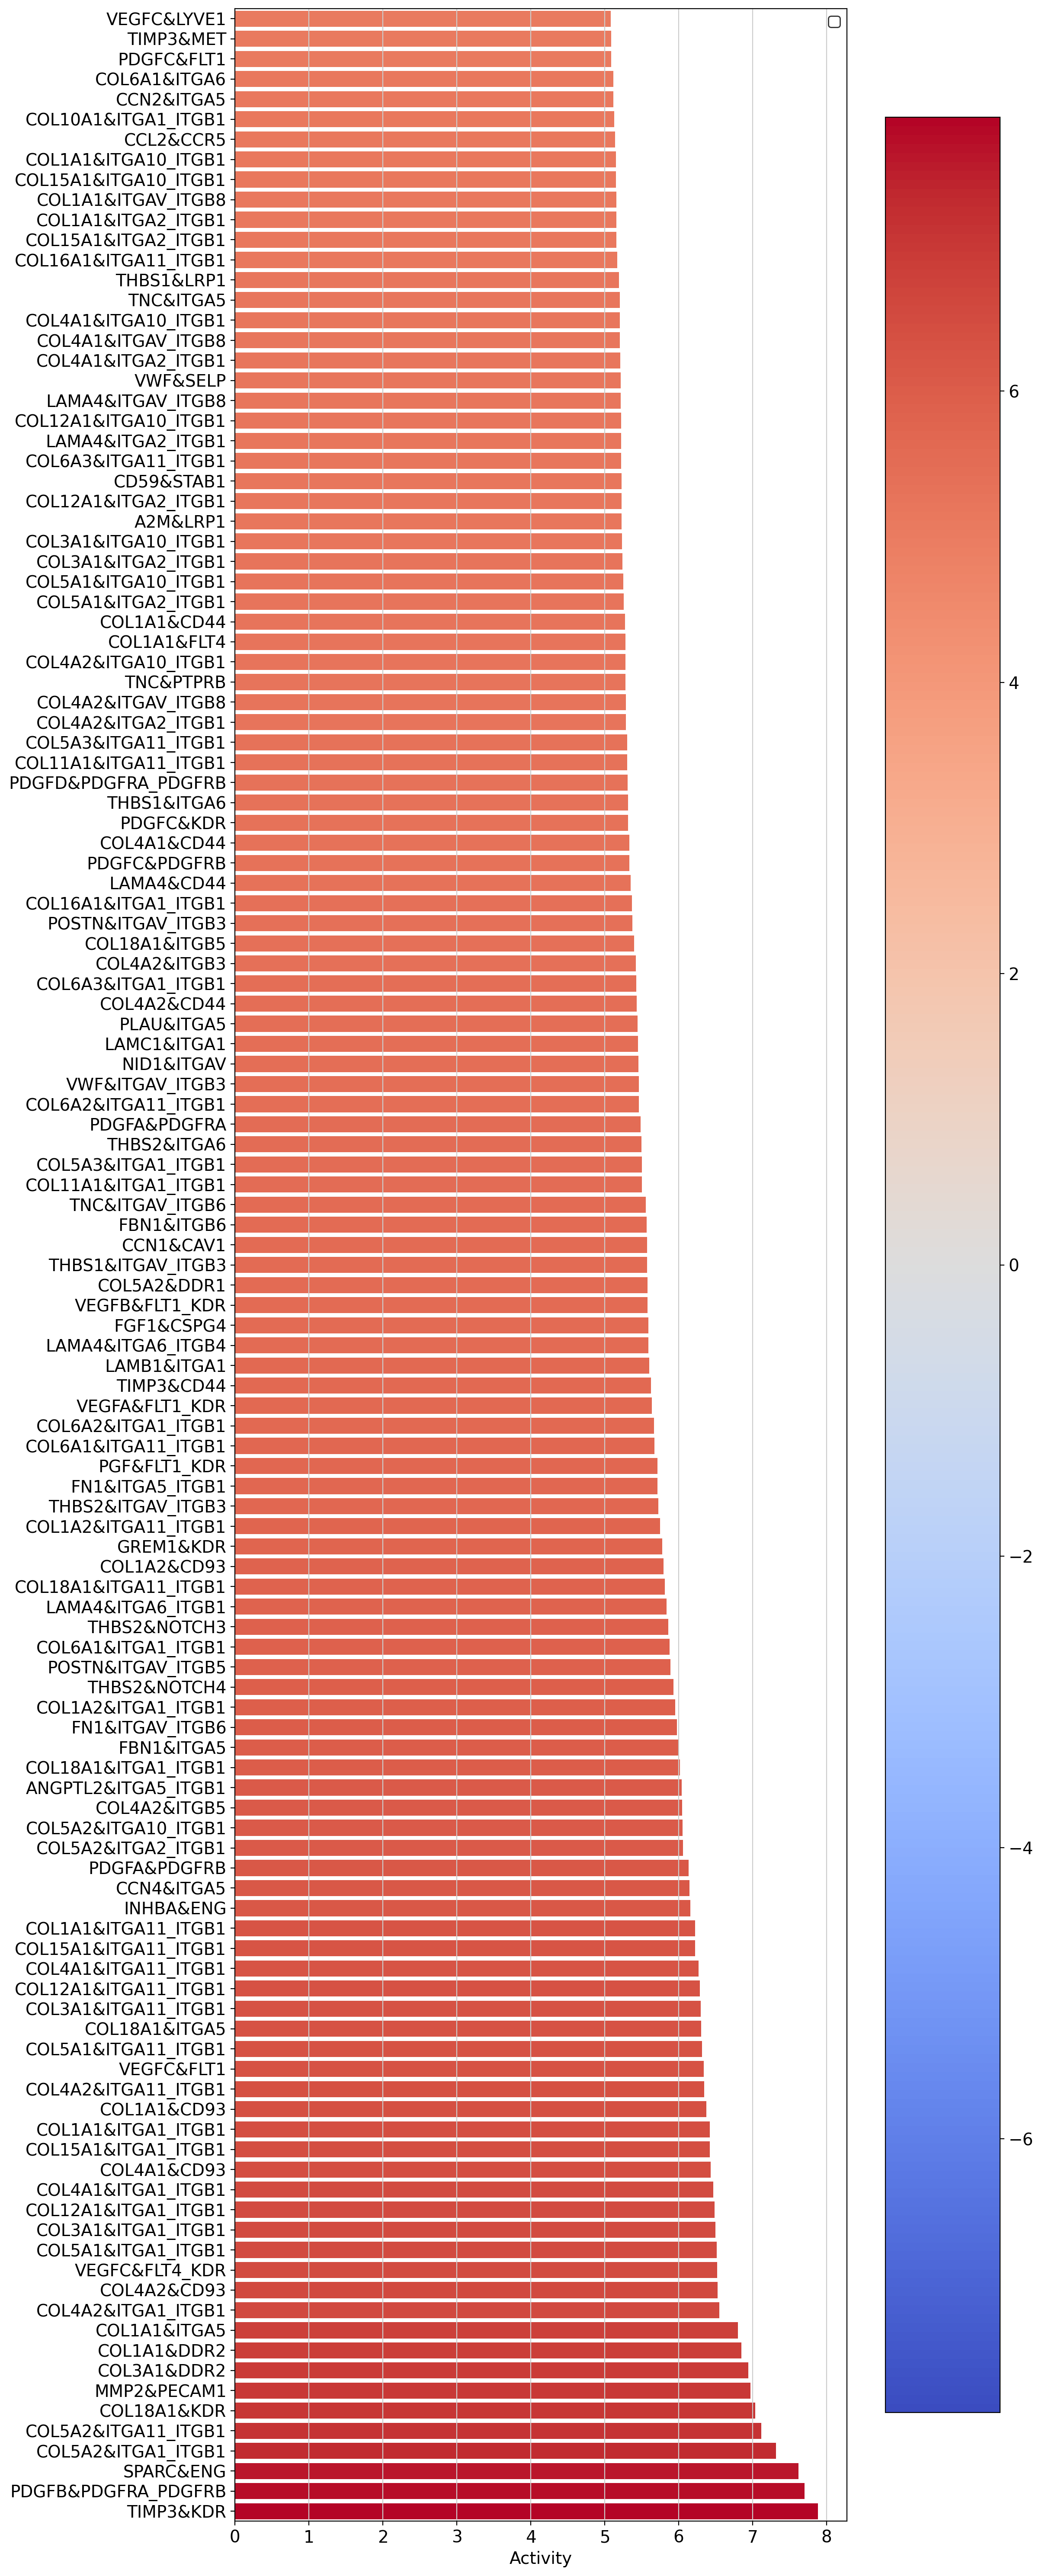

In [ ]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(acts=lr_score, contrast='Lung.vs.LymphNode', top=125, vertical=True,figsize=(12,30))
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 30)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


Interactions between colagens and the ITG_ITG complexes seems to be quite enrichned. That is especially relevant since the EMT pathway was significantly enriched in the functional pathway analysis.

# TCGA

In [ ]:
gdc_sample_sheep='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/gdc_sample_sheet.2024-08-22.tsv'
gdc_download_files='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/gdc_download_20240822_145832.884522'
clinical_cart='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/clinical.cart.2024-08-22'
sclc_tcga=ov.bulk.pyTCGA(gdc_sample_sheep,gdc_download_files,clinical_cart)
sclc_tcga.adata_init()


tcga module init success
...index init


... expression matrix init
...anndata construct


In [ ]:
sclc_tcga.adata_meta_init()


...anndata meta init ['gene_name', 'gene_type'] ['Case ID', 'Sample Type']


AnnData object with n_obs × n_vars = 95 × 60664
    obs: 'Case ID', 'Sample Type'
    var: 'gene_name', 'gene_type', 'gene_id'
    layers: 'tpm', 'fpkm', 'deseq_normalize'

In [ ]:
sclc_tcga.adata

AnnData object with n_obs × n_vars = 95 × 60664
    obs: 'Case ID', 'Sample Type', 'vital_status', 'days'
    var: 'gene_name', 'gene_type', 'gene_id'
    layers: 'tpm', 'fpkm', 'deseq_normalize'

In [ ]:
sclc_tcga.adata.obs["days"]

TCGA-49-6744-01A    1683.0
TCGA-05-4410-01A       0.0
TCGA-78-7148-01A       626
TCGA-05-4432-01A     761.0
TCGA-78-7149-01A    3940.0
                     ...  
TCGA-78-7159-01A    1974.0
TCGA-50-6593-01A       336
TCGA-62-8394-01A       139
TCGA-95-7043-01A       503
TCGA-69-7974-01A     184.0
Name: days, Length: 95, dtype: object

In [ ]:
sclc_tcga.survial_init()


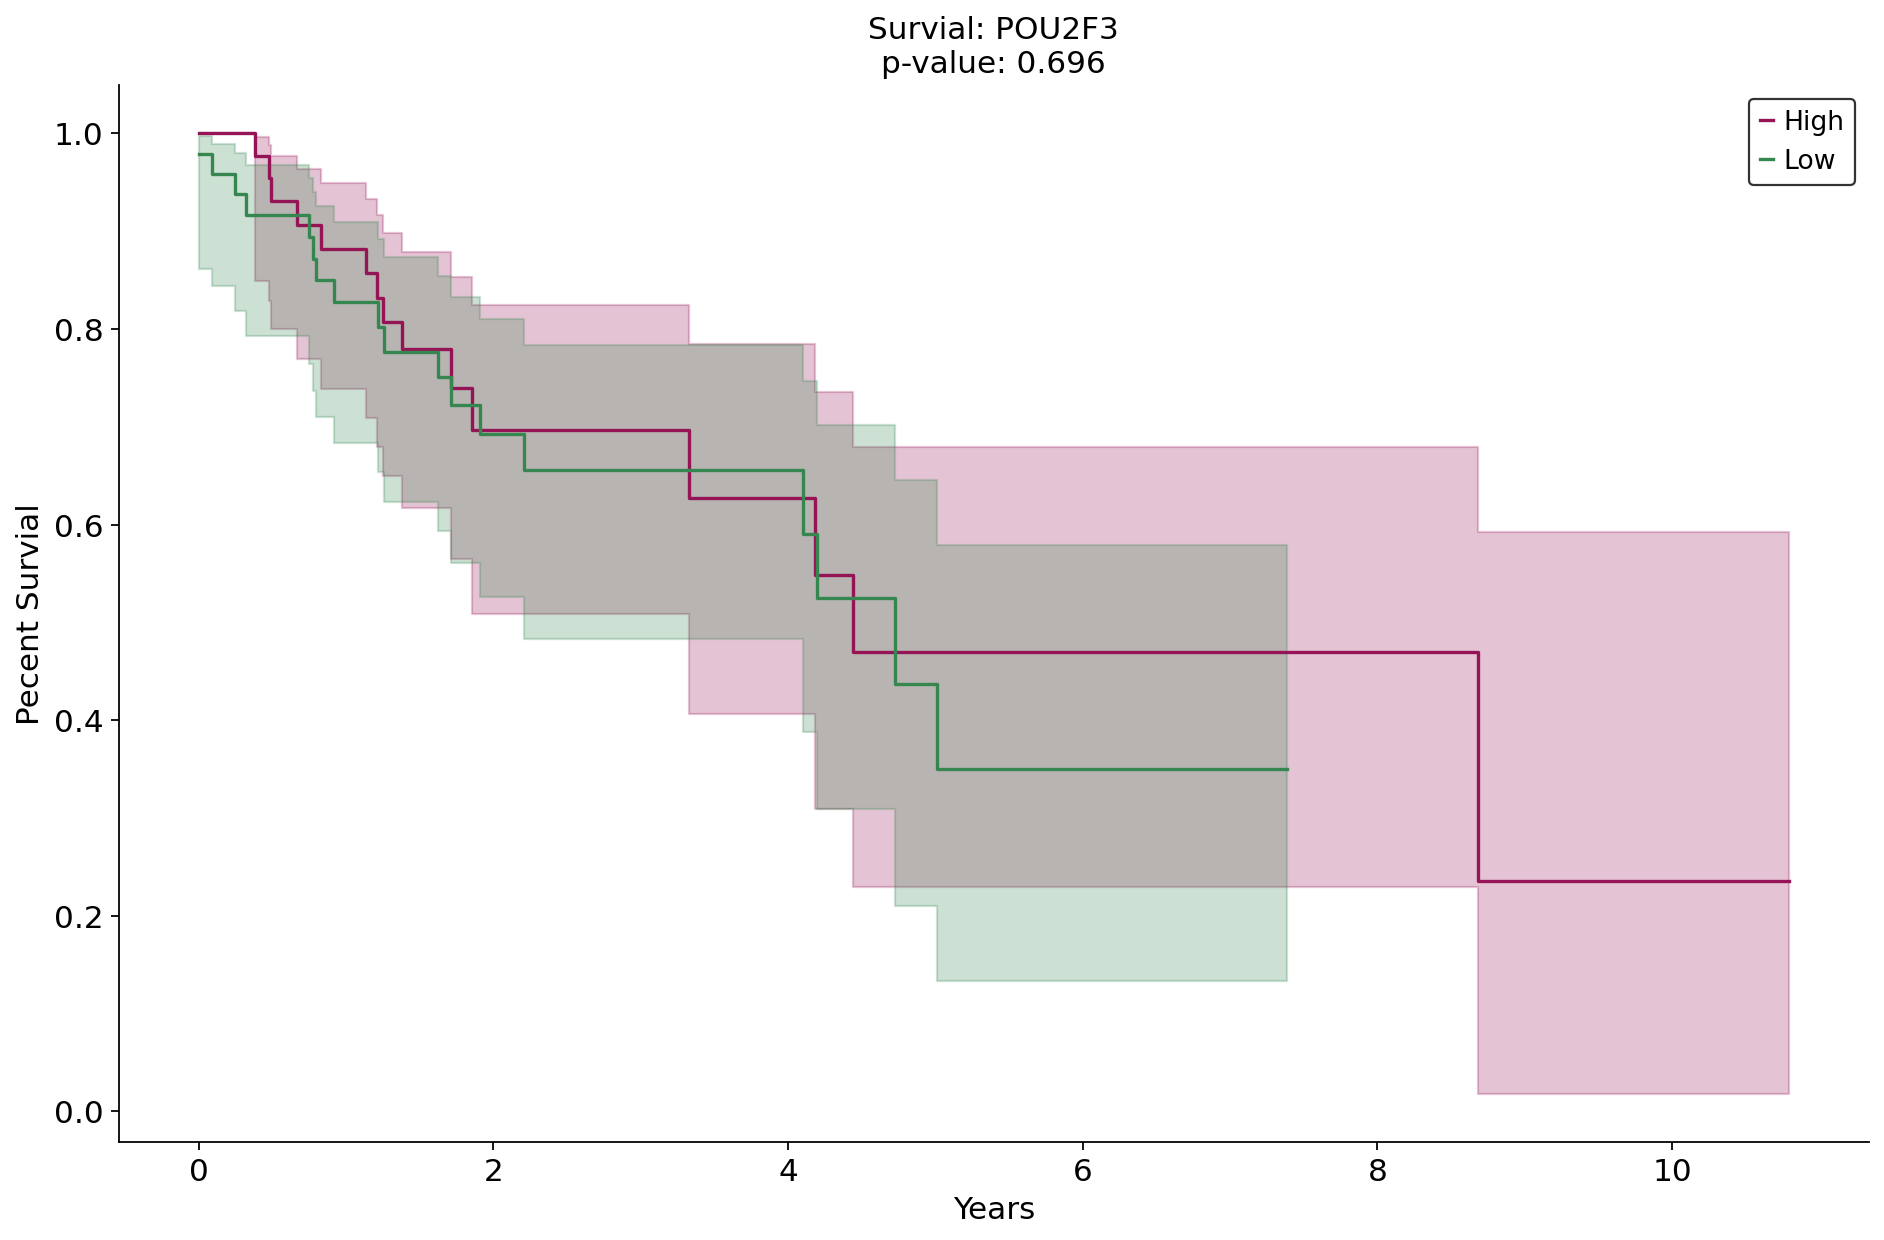

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = sclc_tcga.survival_analysis('POU2F3', layer='deseq_normalize', plot=True)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig(fname='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


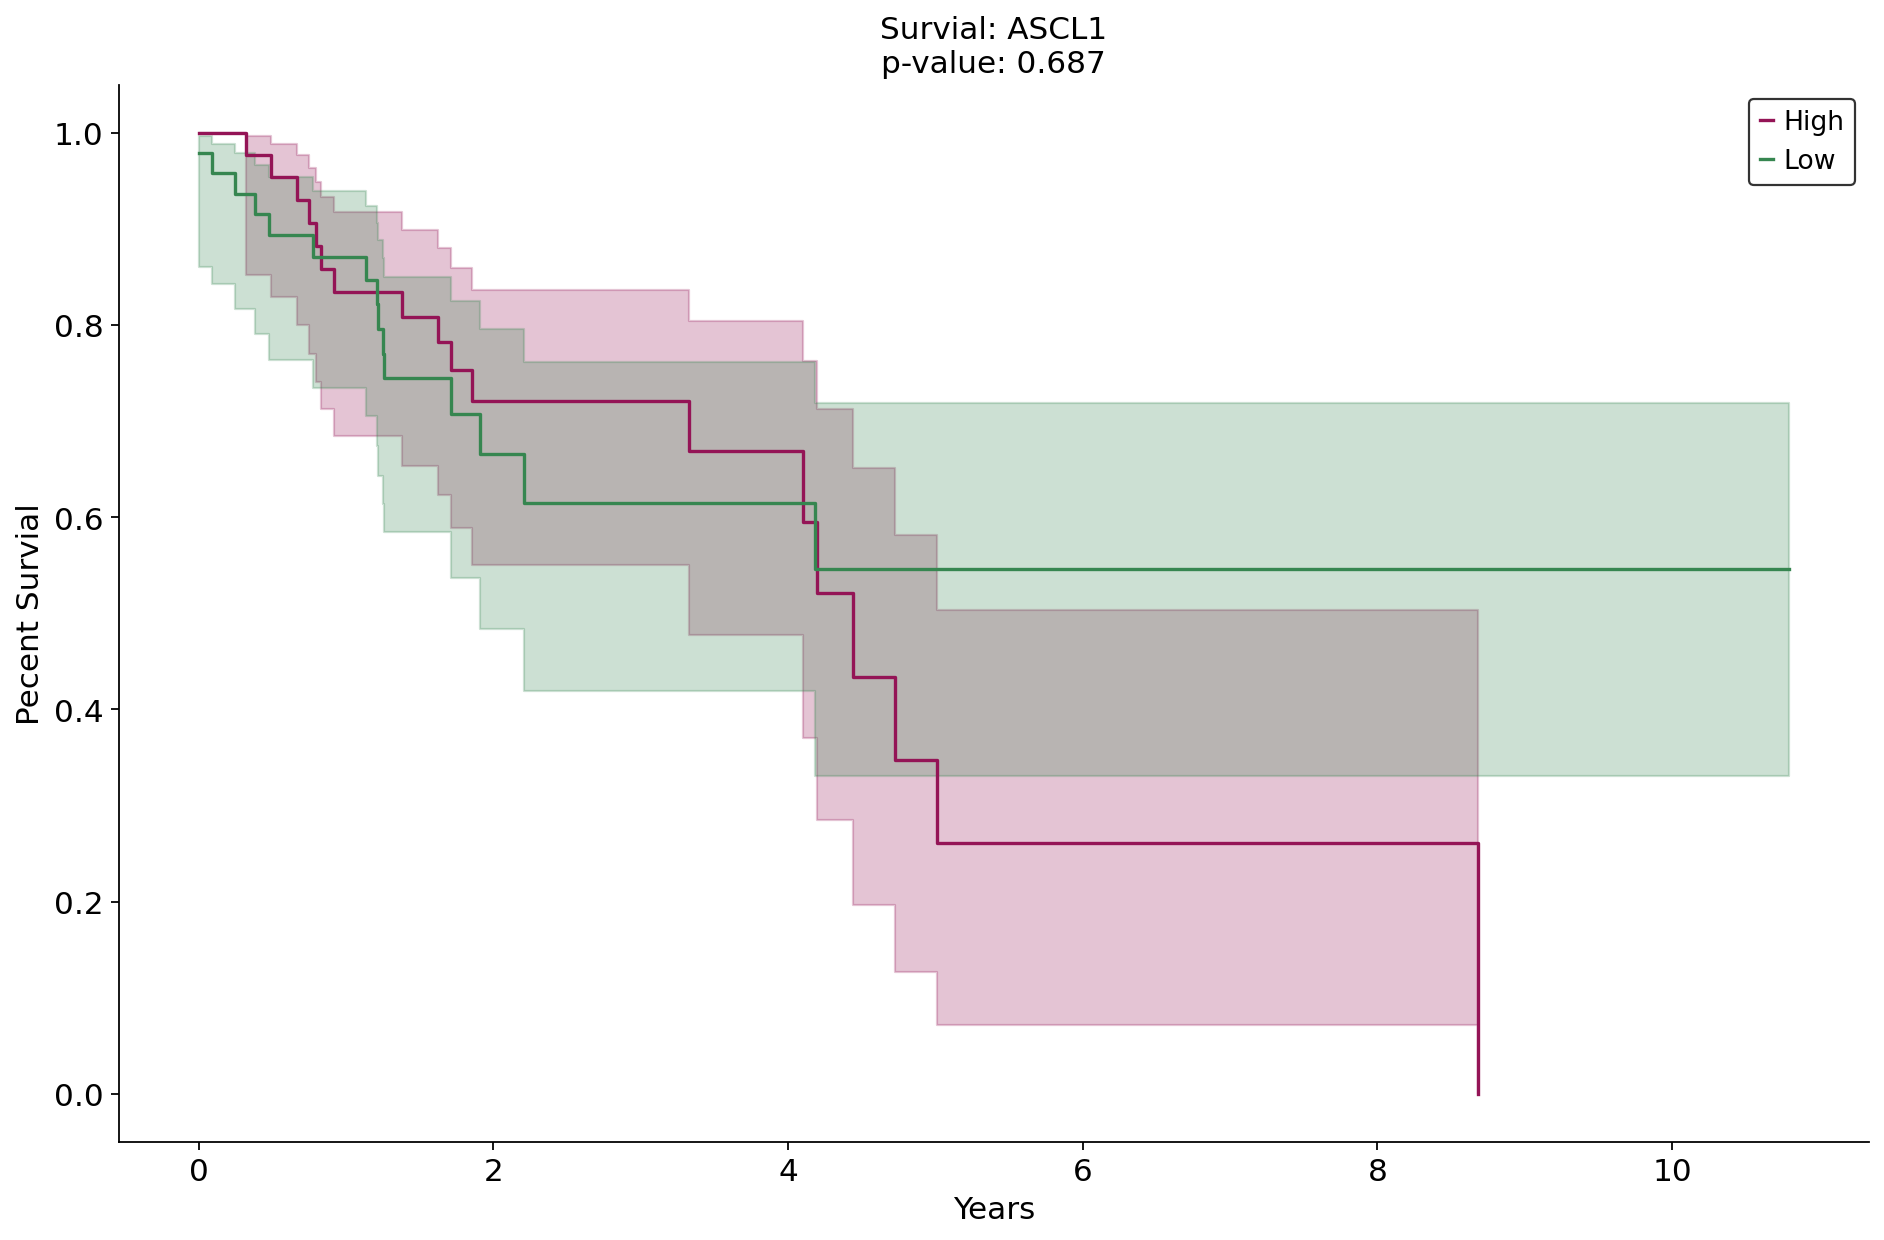

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = sclc_tcga.survival_analysis('ASCL1', layer='deseq_normalize', plot=True)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


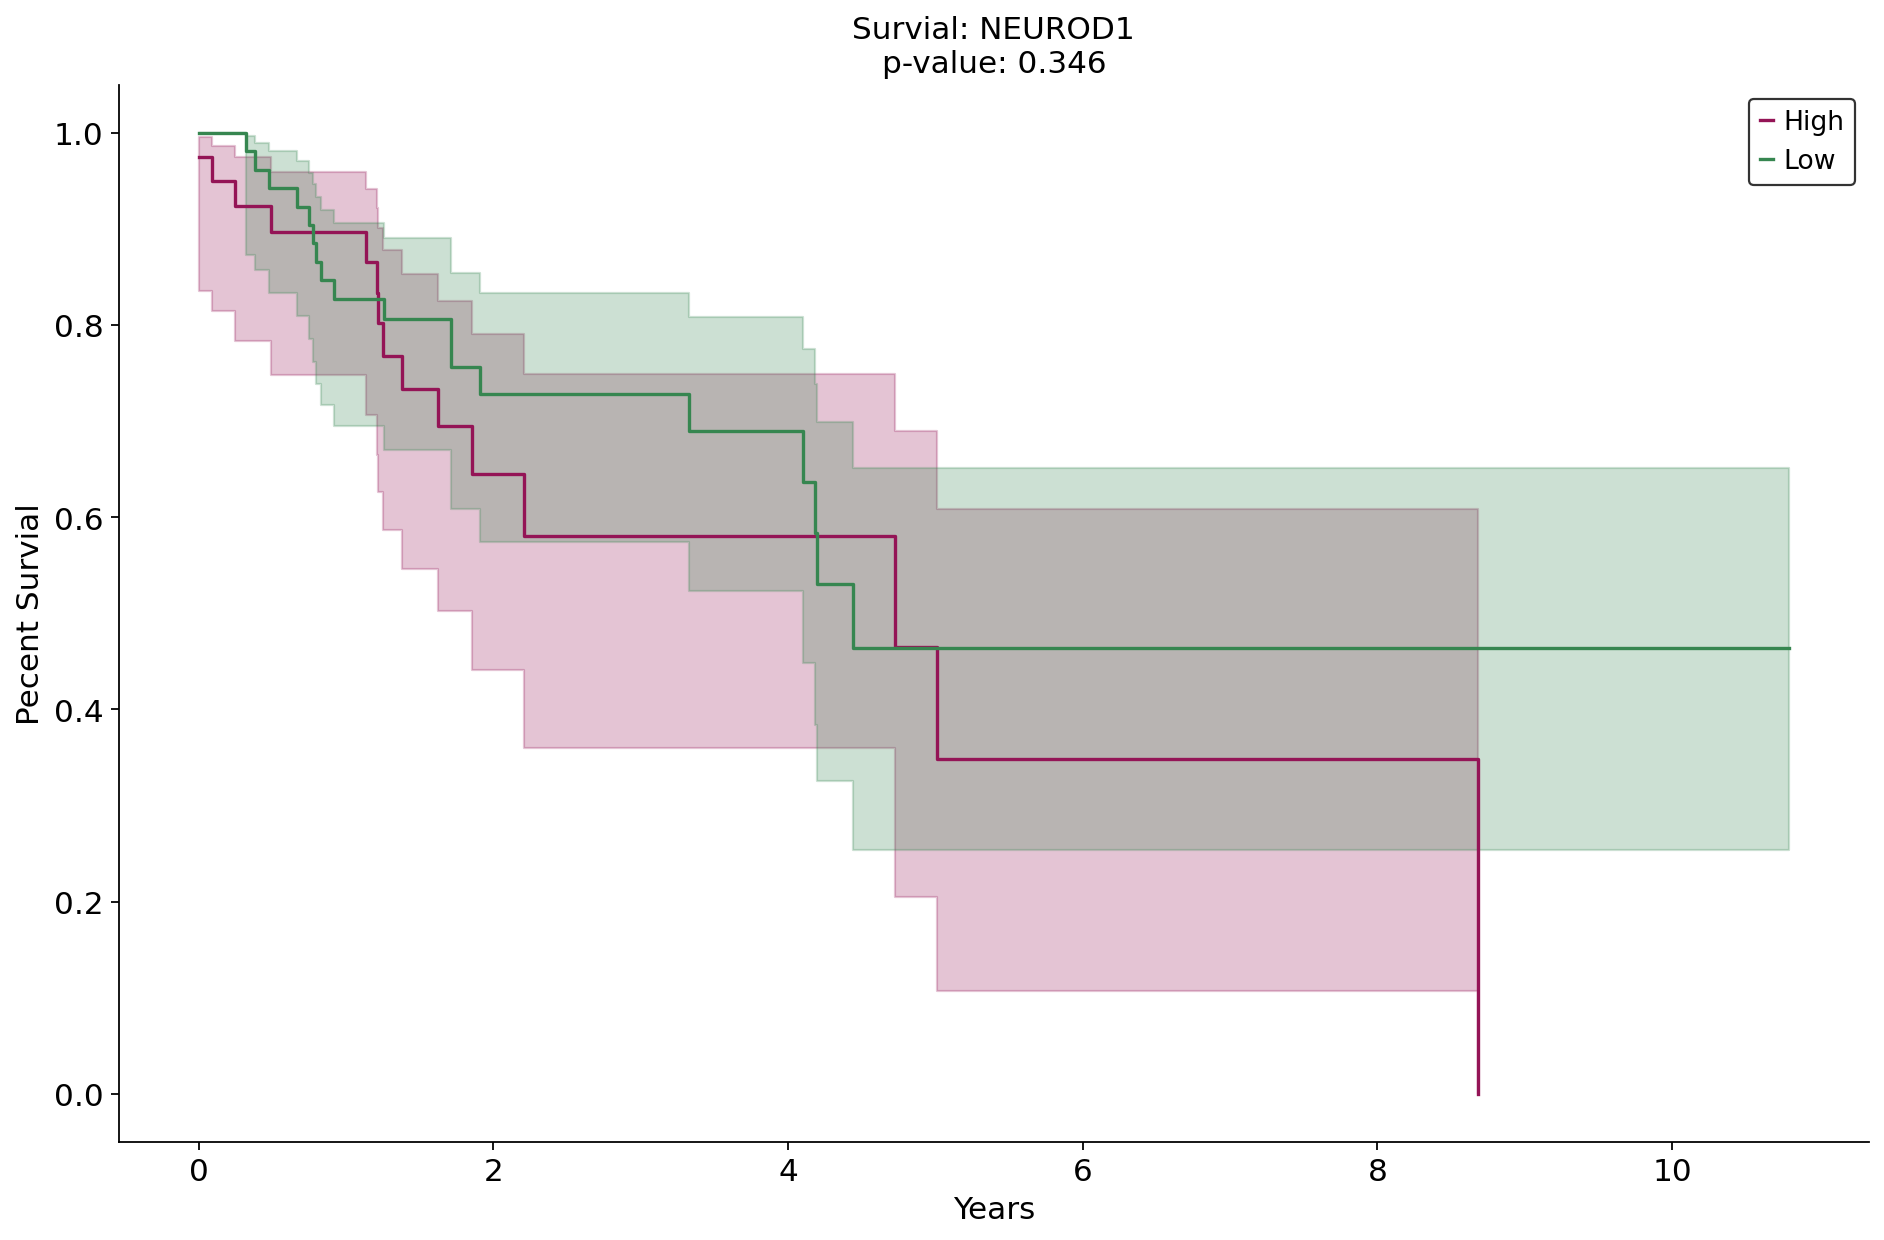

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = sclc_tcga.survival_analysis('NEUROD1', layer='deseq_normalize', plot=True)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


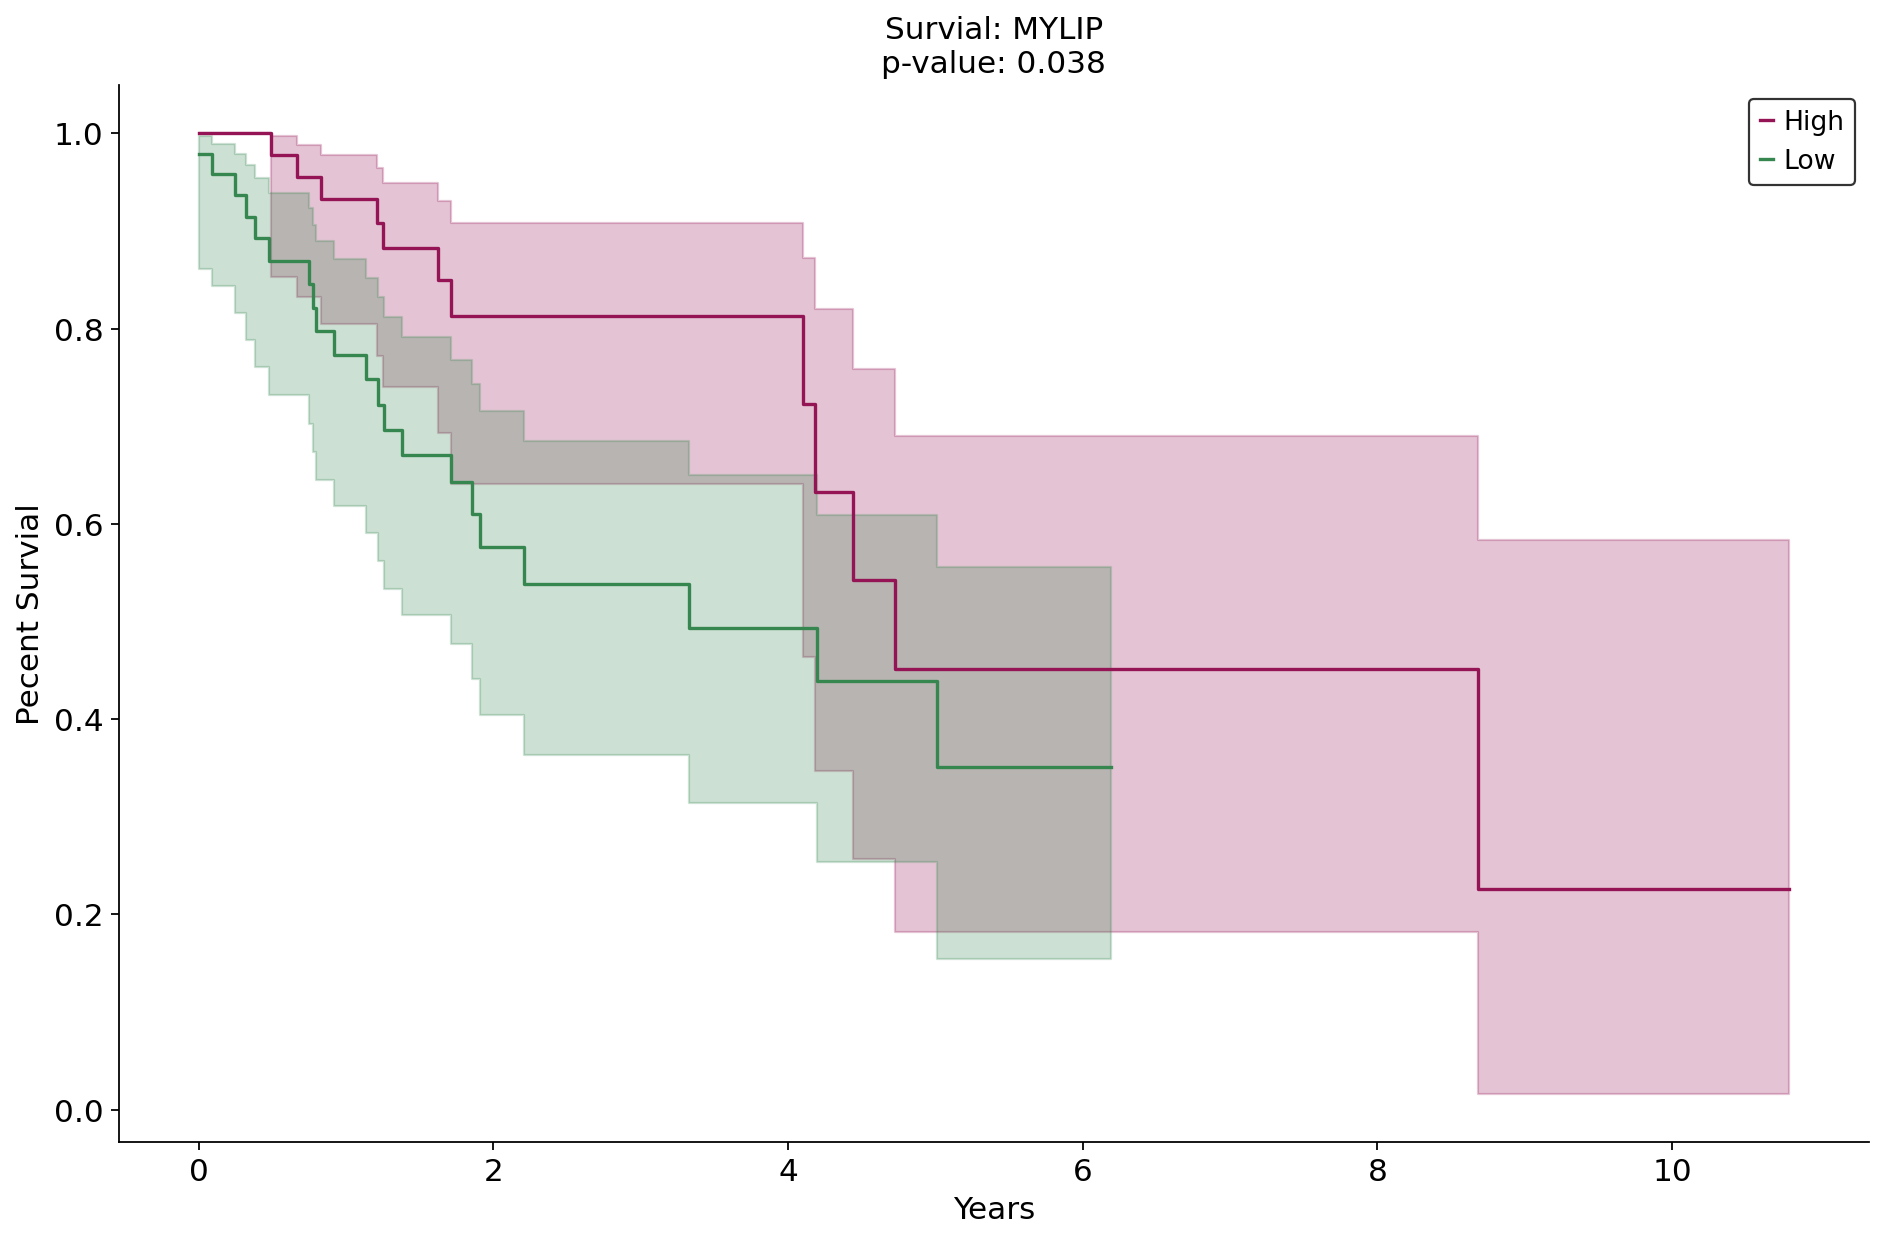

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = sclc_tcga.survival_analysis('MYLIP', layer='deseq_normalize', plot=True)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8797692/
    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [ ]:
sclc_tcga.survial_analysis_all()

100%|██████████| 60664/60664 [1:09:24<00:00, 14.57it/s]


In [ ]:
sclc_tcga.adata

AnnData object with n_obs × n_vars = 95 × 60664
    obs: 'Case ID', 'Sample Type', 'vital_status', 'days'
    var: 'gene_name', 'gene_type', 'gene_id', 'survial_test_statistic', 'survial_p'
    layers: 'tpm', 'fpkm', 'deseq_normalize'

In [ ]:
sclc_tcga.adata.var.loc[:,["gene_name","survial_p"]].sort_values(by="survial_p", ascending=True)[400:450]

gene_name  survial_p
TMPRSS11F    TMPRSS11F   0.002523
AC108704.2  AC108704.2   0.002535
AC104640.2  AC104640.2   0.002559
AC005066.1  AC005066.1   0.002559
AC112492.1  AC112492.1   0.002559
RN7SL691P    RN7SL691P   0.002559
DEFB125        DEFB125   0.002559
OR7E156P      OR7E156P   0.002559
AC114501.3  AC114501.3   0.002559
AC091912.2  AC091912.2   0.002559
AC092691.2  AC092691.2   0.002559
AC013442.1  AC013442.1   0.002559
VN1R18P        VN1R18P   0.002559
AC025752.1  AC025752.1   0.002559
RNU6-287P    RNU6-287P   0.002559
AL450487.1  AL450487.1   0.002559
AC063977.3  AC063977.3   0.002559
TARS2P1        TARS2P1   0.002559
HSPE1P12      HSPE1P12   0.002559
CU633904.3  CU633904.3   0.002559
OR4K15          OR4K15   0.002559
AC092368.2  AC092368.2   0.002559
RN7SKP291    RN7SKP291   0.002559
AP005263.1  AP005263.1   0.002559
ZSWIM5P3      ZSWIM5P3   0.002559
AL591004.1  AL591004.1   0.002559
AP003072.1  AP003072.1   0.002559
TBC1D3P3      TBC1D3P3   0.002559
RNU6-440P    RNU6-440P   0.002559
PRAMEF18      PRAMEF18   0.002559
BX323845.1  BX323845.1   0.002559
Z82209.2      Z82209.2   0.002559
AC096666.1  AC096666.1   0.002559
DEFB127        DEFB127   0.002559
MIR3672        MIR3672   0.002559
RNA5SP50      RNA5SP50   0.002559
HMGN2P26      HMGN2P26   0.002559
Z98259.2      Z98259.2   0.002559
BEST3            BEST3   0.002612
MYLIP            MYLIP   0.002621
FADS6            FADS6   0.002623
PITX3            PITX3   0.002672
AC026318.1  AC026318.1   0.002672
Z84468.2      Z84468.2   0.002681
AL591686.2  AL591686.2   0.002725
AL592148.1  AL592148.1   0.002735
CEACAMP10    CEACAMP10   0.002792
MIR582          MIR582   0.002804
CAMK1D          CAMK1D   0.002829
AC006511.6  AC006511.6   0.002839

In [ ]:
sclc_tcga.adata.write_h5ad('/mnt/archive2/RO_src/data/ov_tcga_survial_all.h5ad')

# Bulk 2 Single

In [ ]:
count_matrix
#TODO: subset on markers and use this grouping to cluster and divide by lung vs lymph node

R2_07_Lymph Node  R2_22_Lung  R1_74_Lung  R1_19_Lung  \
TSPAN6                        288          48         226          36   
DPM1                          753         271         226         179   
SCYL3                         549         113          88          66   
C1orf112                      956         222         121         311   
FGR                            13          14           8         435   
...                           ...         ...         ...         ...   
ENSG00000291288                 7           4           8           0   
ENSG00000291290                54          30          16         111   
ENSG00000291299               256         130         217         132   
ENSG00000291313                18          41           0           0   
TMEM276                        37          30          25         165   

                 R2_29_Lung  R2_60_Lung  R2_35_Lung  R2_61_Lymph Node  \
TSPAN6                   57          95         164                85   
DPM1                    247         211         359               255   
SCYL3                    30          85         127                45   
C1orf112                138          72         322                90   
FGR                      18          17           7                21   
...                     ...         ...         ...               ...   
ENSG00000291288           0           0           0                30   
ENSG00000291290           0           0          22                 8   
ENSG00000291299         292          56         209               180   
ENSG00000291313           4           0           0                 0   
TMEM276                  36           0           0                 0   

                 R2_10_Lung  R1_67_Lung  ...  R1_73_Lung  R2_23_Lung  \
TSPAN6                   62         223  ...         143         124   
DPM1                    170         414  ...         393         377   
SCYL3                    71         183  ...         151         224   
C1orf112                 90         154  ...         236         331   
FGR                       6          69  ...          13           0   
...                     ...         ...  ...         ...         ...   
ENSG00000291288           8           1  ...          13          17   
ENSG00000291290           0          21  ...          11          38   
ENSG00000291299          68         146  ...         170         384   
ENSG00000291313           0           0  ...           0           0   
TMEM276                  25          17  ...          22          68   

                 R2_26_Lymph Node  R2_02_Lymph Node  R2_08_Lung  \
TSPAN6                        213                21          44   
DPM1                          758               210         165   
SCYL3                         231               180          46   
C1orf112                      212                53          33   
FGR                            36                36           2   
...                           ...               ...         ...   
ENSG00000291288                41                 5           5   
ENSG00000291290                36                32           0   
ENSG00000291299               361               162         159   
ENSG00000291313                58                54           0   
TMEM276                        25                55          18   

                 R2_56_Lymph Node  R2_12_Lung  R2_33_Lung  R2_36_Lung  \
TSPAN6                        143          66         206         177   
DPM1                          331         134         328         250   
SCYL3                         127         140         162         131   
C1orf112                       78         129         315         300   
FGR                            52          48          12          23   
...                           ...         ...         ...         ...   
ENSG00000291288                 0           0          14          14   
ENSG00000

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from sklearn.preprocessing import StandardScaler

# # Step 1: Load the data
# # Replace `data.csv` with your actual file path or data loading method

# # Step 2: Preprocess the data (normalize and transpose)
# # Normalize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(count_matrix.T)

# # Step 3: Perform hierarchical clustering
# linked = linkage(scaled_data, method='ward')

# # Step 4: Plot the dendrogram
# plt.figure(figsize=(10, 7))
# dendrogram(linked, labels=count_matrix.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
# plt.show()

# # Step 5: Optionally, create a heatmap for better visualization
# sns.clustermap(data=count_matrix.T, method='ward', cmap='vlag', standard_scale=1, figsize=(10, 10))
# plt.show()

# # Step 6: (Optional) Cut the dendrogram to find clusters
# # This step assumes you have some knowledge of the number of clusters
# clusters = fcluster(linked, t=2, criterion='maxclust')

# # Map the clusters to lung/lymph node (requires prior knowledge or additional metadata)
# df['Cluster'] = clusters

In [ ]:
sc_adata = sc.read_h5ad(r"/mnt/work/RO_src/data/raw/scRNA/SCLC/SCLC_Annotated_pp.h5ad") #on archive2

## Bulk 2 Single by sample

In [ ]:
model=ov.bulk2single.Bulk2Single(bulk_data=count_matrix,single_data=sc_adata,
                celltype_key='cell_type_fine',
                 top_marker_num=200,ratio_num=1,gpu=0, max_single_cells=5000)

......random select 5000 single cells


Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


5000it [00:28, 174.04it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  14992
Scaling...


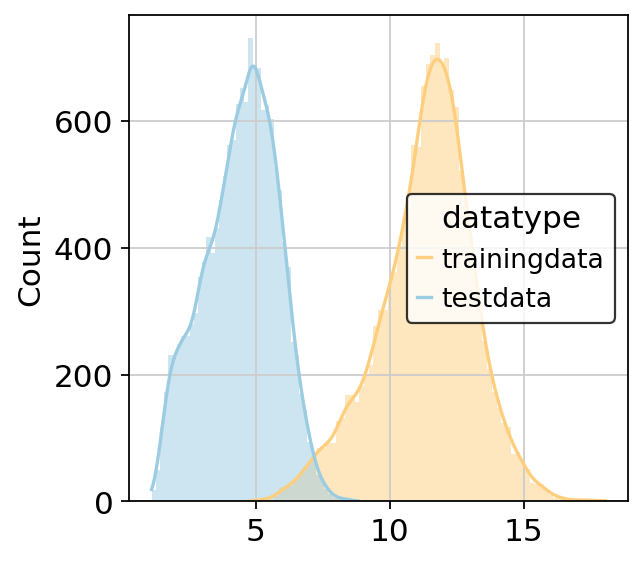

Using minmax scaler...


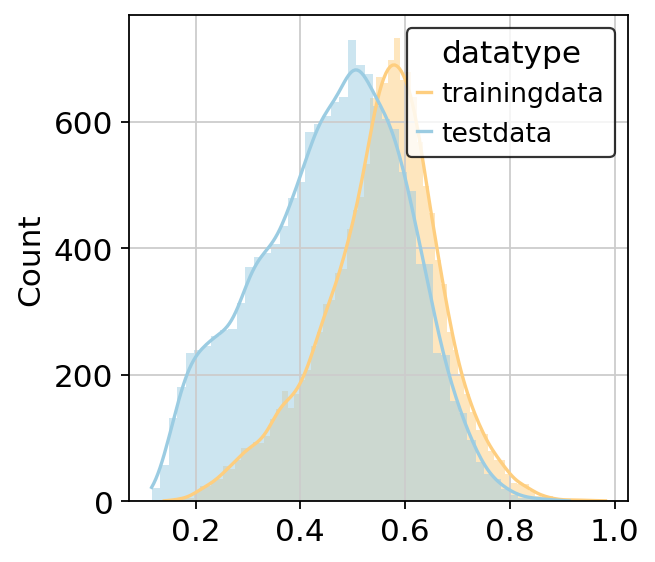

training data shape is  (5000, 14992) 
test data shape is  (75, 14992)
train model256 now


100%|██████████| 128/128 [02:02<00:00,  1.05it/s]


train model512 now


100%|██████████| 128/128 [03:31<00:00,  1.65s/it]


train model1024 now


100%|██████████| 128/128 [05:27<00:00,  2.56s/it]


Training of Scaden is done
Predicted Total Cell Num: 715.6592136950803


In [ ]:
CellFractionPrediction=model.predicted_fraction()

In [ ]:
CellFractionPrediction.head()

AE1       AEP    B cell     Basal  Ciliated      Club  \
R2_07_Lymph Node  0.040049  0.037934  0.049370  0.045328  0.036413  0.037500   
R2_22_Lung        0.049190  0.049379  0.045599  0.048501  0.046068  0.043992   
R1_74_Lung        0.048401  0.048481  0.044944  0.048918  0.045499  0.044103   
R1_19_Lung        0.049396  0.047441  0.048472  0.049108  0.045177  0.044565   
R2_29_Lung        0.047089  0.050342  0.042798  0.046506  0.045511  0.044140   

                        DC  Endothelial  Fibroblast  Ionocyte  ...      Mast  \
R2_07_Lymph Node  0.043665     0.036117    0.034068  0.040476  ...  0.042025   
R2_22_Lung        0.044490     0.045296    0.062368  0.046576  ...  0.047676   
R1_74_Lung        0.046735     0.045748    0.052541  0.047853  ...  0.047527   
R1_19_Lung        0.053362     0.049935    0.052899  0.048447  ...  0.050694   
R2_29_Lung        0.041091     0.044709    0.066492  0.046328  ...  0.047226   

                  Mucinous     NSCLC  Neuroendocrine  Neutrophil  Plasma cell  \
R2_07_Lymph Node  0.041954  0.040748        0.044376    0.046227     0.045610   
R2_22_Lung        0.050754  0.047896        0.047088    0.048837     0.046714   
R1_74_Lung        0.050106  0.047198        0.047502    0.049700     0.047751   
R1_19_Lung        0.051386  0.046414        0.046766    0.049563     0.047439   
R2_29_Lung        0.050445  0.046366        0.047344    0.049077     0.046095   

                    SCLC-A    SCLC-N    SCLC-P    T cell  
R2_07_Lymph Node  0.062465  0.064690  0.041509  0.126804  
R2_22_Lung        0.042655  0.059201  0.047599  0.044389  
R1_74_Lung        0.039590  0.067286  0.048092  0.042996  
R1_19_Lung        0.033632  0.042839  0.049300  0.053664  
R2_29_Lung        0.043278  0.078149  0.047546  0.035961  

[5 rows x 21 columns]

In [ ]:
lung_columns = [col for col in count_matrix.columns if col.endswith('_Lung')]
lymph_node_columns = [col for col in count_matrix.columns if col.endswith('_Lymph Node')]
sorted_columns = lung_columns + lymph_node_columns

In [ ]:
CellFractionPrediction_sorted = CellFractionPrediction.T[sorted_columns].T


In [ ]:
CellFractionPrediction_sorted

AE1       AEP    B cell     Basal  Ciliated      Club  \
R2_22_Lung        0.049190  0.049379  0.045599  0.048501  0.046068  0.043992   
R1_74_Lung        0.048401  0.048481  0.044944  0.048918  0.045499  0.044103   
R1_19_Lung        0.049396  0.047441  0.048472  0.049108  0.045177  0.044565   
R2_29_Lung        0.047089  0.050342  0.042798  0.046506  0.045511  0.044140   
R2_60_Lung        0.048541  0.044407  0.047599  0.047537  0.041666  0.042313   
...                    ...       ...       ...       ...       ...       ...   
R2_28_Lymph Node  0.043253  0.042155  0.048463  0.047671  0.039676  0.040228   
R2_66_Lymph Node  0.039710  0.038913  0.050775  0.045104  0.037253  0.037529   
R2_26_Lymph Node  0.040181  0.039833  0.049139  0.046237  0.036719  0.037568   
R2_02_Lymph Node  0.035138  0.033476  0.040013  0.037904  0.032996  0.034173   
R2_56_Lymph Node  0.048027  0.044319  0.048715  0.048256  0.045321  0.044605   

                        DC  Endothelial  Fibroblast  Ionocyte  ...      Mast  \
R2_22_Lung        0.044490     0.045296    0.062368  0.046576  ...  0.047676   
R1_74_Lung        0.046735     0.045748    0.052541  0.047853  ...  0.047527   
R1_19_Lung        0.053362     0.049935    0.052899  0.048447  ...  0.050694   
R2_29_Lung        0.041091     0.044709    0.066492  0.046328  ...  0.047226   
R2_60_Lung        0.045549     0.041597    0.049096  0.043514  ...  0.047439   
...                    ...          ...         ...       ...  ...       ...   
R2_28_Lymph Node  0.046596     0.039714    0.035840  0.043546  ...  0.045237   
R2_66_Lymph Node  0.043651     0.036756    0.033834  0.041193  ...  0.042532   
R2_26_Lymph Node  0.044311     0.036837    0.033844  0.041174  ...  0.043457   
R2_02_Lymph Node  0.041269     0.033323    0.032631  0.033808  ...  0.035200   
R2_56_Lymph Node  0.050146     0.045240    0.041889  0.045556  ...  0.046159   

                  Mucinous     NSCLC  Neuroendocrine  Neutrophil  Plasma cell  \
R2_22_Lung        0.050754  0.047896        0.047088    0.048837     0.046714   
R1_74_Lung        0.050106  0.047198        0.047502    0.049700     0.047751   
R1_19_Lung        0.051386  0.046414        0.046766    0.049563     0.047439   
R2_29_Lung        0.050445  0.046366        0.047344    0.049077     0.046095   
R2_60_Lung        0.048505  0.046653        0.047909    0.046632     0.047382   
...                    ...       ...             ...         ...          ...   
R2_28_Lymph Node  0.045150  0.043926        0.047204    0.048275     0.046500   
R2_66_Lymph Node  0.042660  0.041161        0.046224    0.046124     0.045934   
R2_26_Lymph Node  0.042567  0.041761        0.045312    0.046453     0.044337   
R2_02_Lymph Node  0.036459  0.033264        0.038393    0.040548     0.039478   
R2_56_Lymph Node  0.049369  0.045437        0.048364    0.049865     0.047861   

                    SCLC-A    SCLC-N    SCLC-P    T cell  
R2_22_Lung        0.042655  0.059201  0.047599  0.044389  
R1_74_Lung        0.039590  0.067286  0.048092  0.042996  
R1_19_Lung        0.033632  0.042839  0.049300  0.053664  
R2_29_Lung        0.043278  0.078149  0.047546  0.035961  
R2_60_Lung        0.037764  0.047217  0.045336  0.098311  
...                    ...       ...       ...       ...  
R2_28_Lymph Node  0.062586  0.075235  0.045084  0.062821  
R2_66_Lymph Node  0.091446  0.062859  0.042623  0.088153  
R2_26_Lymph Node  0.073026  0.095667  0.042906  0.069315  
R2_02_Lymph Node  0.032951  0.032173  0.037033  0.286331  
R2_56_Lymph Node  0.048059  0.040477  0.048050  0.065071  

[75 rows x 21 columns]

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from statsmodels.stats.proportion import proportions_ztest


# 1. Separate samples into Lung and Lymph Node groups
lung_samples = CellFractionPrediction_sorted.filter(regex='_Lung$', axis=0)
lymph_node_samples = CellFractionPrediction_sorted.filter(regex='_Lymph Node$', axis=0)

# 2. Calculate the mean and variance for each group
lung_mean = lung_samples.mean()
lymph_node_mean = lymph_node_samples.mean()

lung_var = lung_samples.var()
lymph_node_var = lymph_node_samples.var()

print("Mean per cell type for Lung samples:")
print(lung_mean)

print("\nVariance per cell type for Lung samples:")
print(lung_var)

print("\nMean per cell type for Lymph Node samples:")
print(lymph_node_mean)

print("\nVariance per cell type for Lymph Node samples:")
print(lymph_node_var)

# 3. Perform proportion tests for each cell type between Lung and Lymph Node groups
results = {}
for cell_type in lung_samples.columns:
    count_lung = lung_samples[cell_type].sum()
    count_lymph = lymph_node_samples[cell_type].sum()
    
    nobs_lung = len(lung_samples)
    nobs_lymph = len(lymph_node_samples)
    
    # Perform the proportion test using statsmodels
    stat, pval = proportions_ztest([count_lung, count_lymph], [nobs_lung, nobs_lymph])
    results[cell_type] = {'Z-statistic': stat, 'p-value': pval}


# Display results
print("\nProportion test results between Lung and Lymph Node samples:")
for cell_type, result in results.items():
    print(f"{cell_type}: Z-statistic = {result['Z-statistic']:.4f}, p-value = {result['p-value']:.4e}")


Mean per cell type for Lung samples:
AE1               0.049296
AEP               0.048605
B cell            0.045556
Basal             0.047310
Ciliated          0.047927
Club              0.044118
DC                0.045223
Endothelial       0.045276
Fibroblast        0.065804
Ionocyte          0.047806
Macrophage        0.036244
Mast              0.049029
Mucinous          0.050370
NSCLC             0.046883
Neuroendocrine    0.046978
Neutrophil        0.047815
Plasma cell       0.045658
SCLC-A            0.042218
SCLC-N            0.052265
SCLC-P            0.047610
T cell            0.048008
dtype: float32

Variance per cell type for Lung samples:
AE1               5.030932e-06
AEP               5.392678e-06
B cell            2.609661e-06
Basal             1.580829e-06
Ciliated          2.368357e-05
Club              2.867703e-06
DC                5.356744e-06
Endothelial       6.889661e-06
Fibroblast        2.537472e-04
Ionocyte          7.578739e-06
Macrophage        1.067606e-0

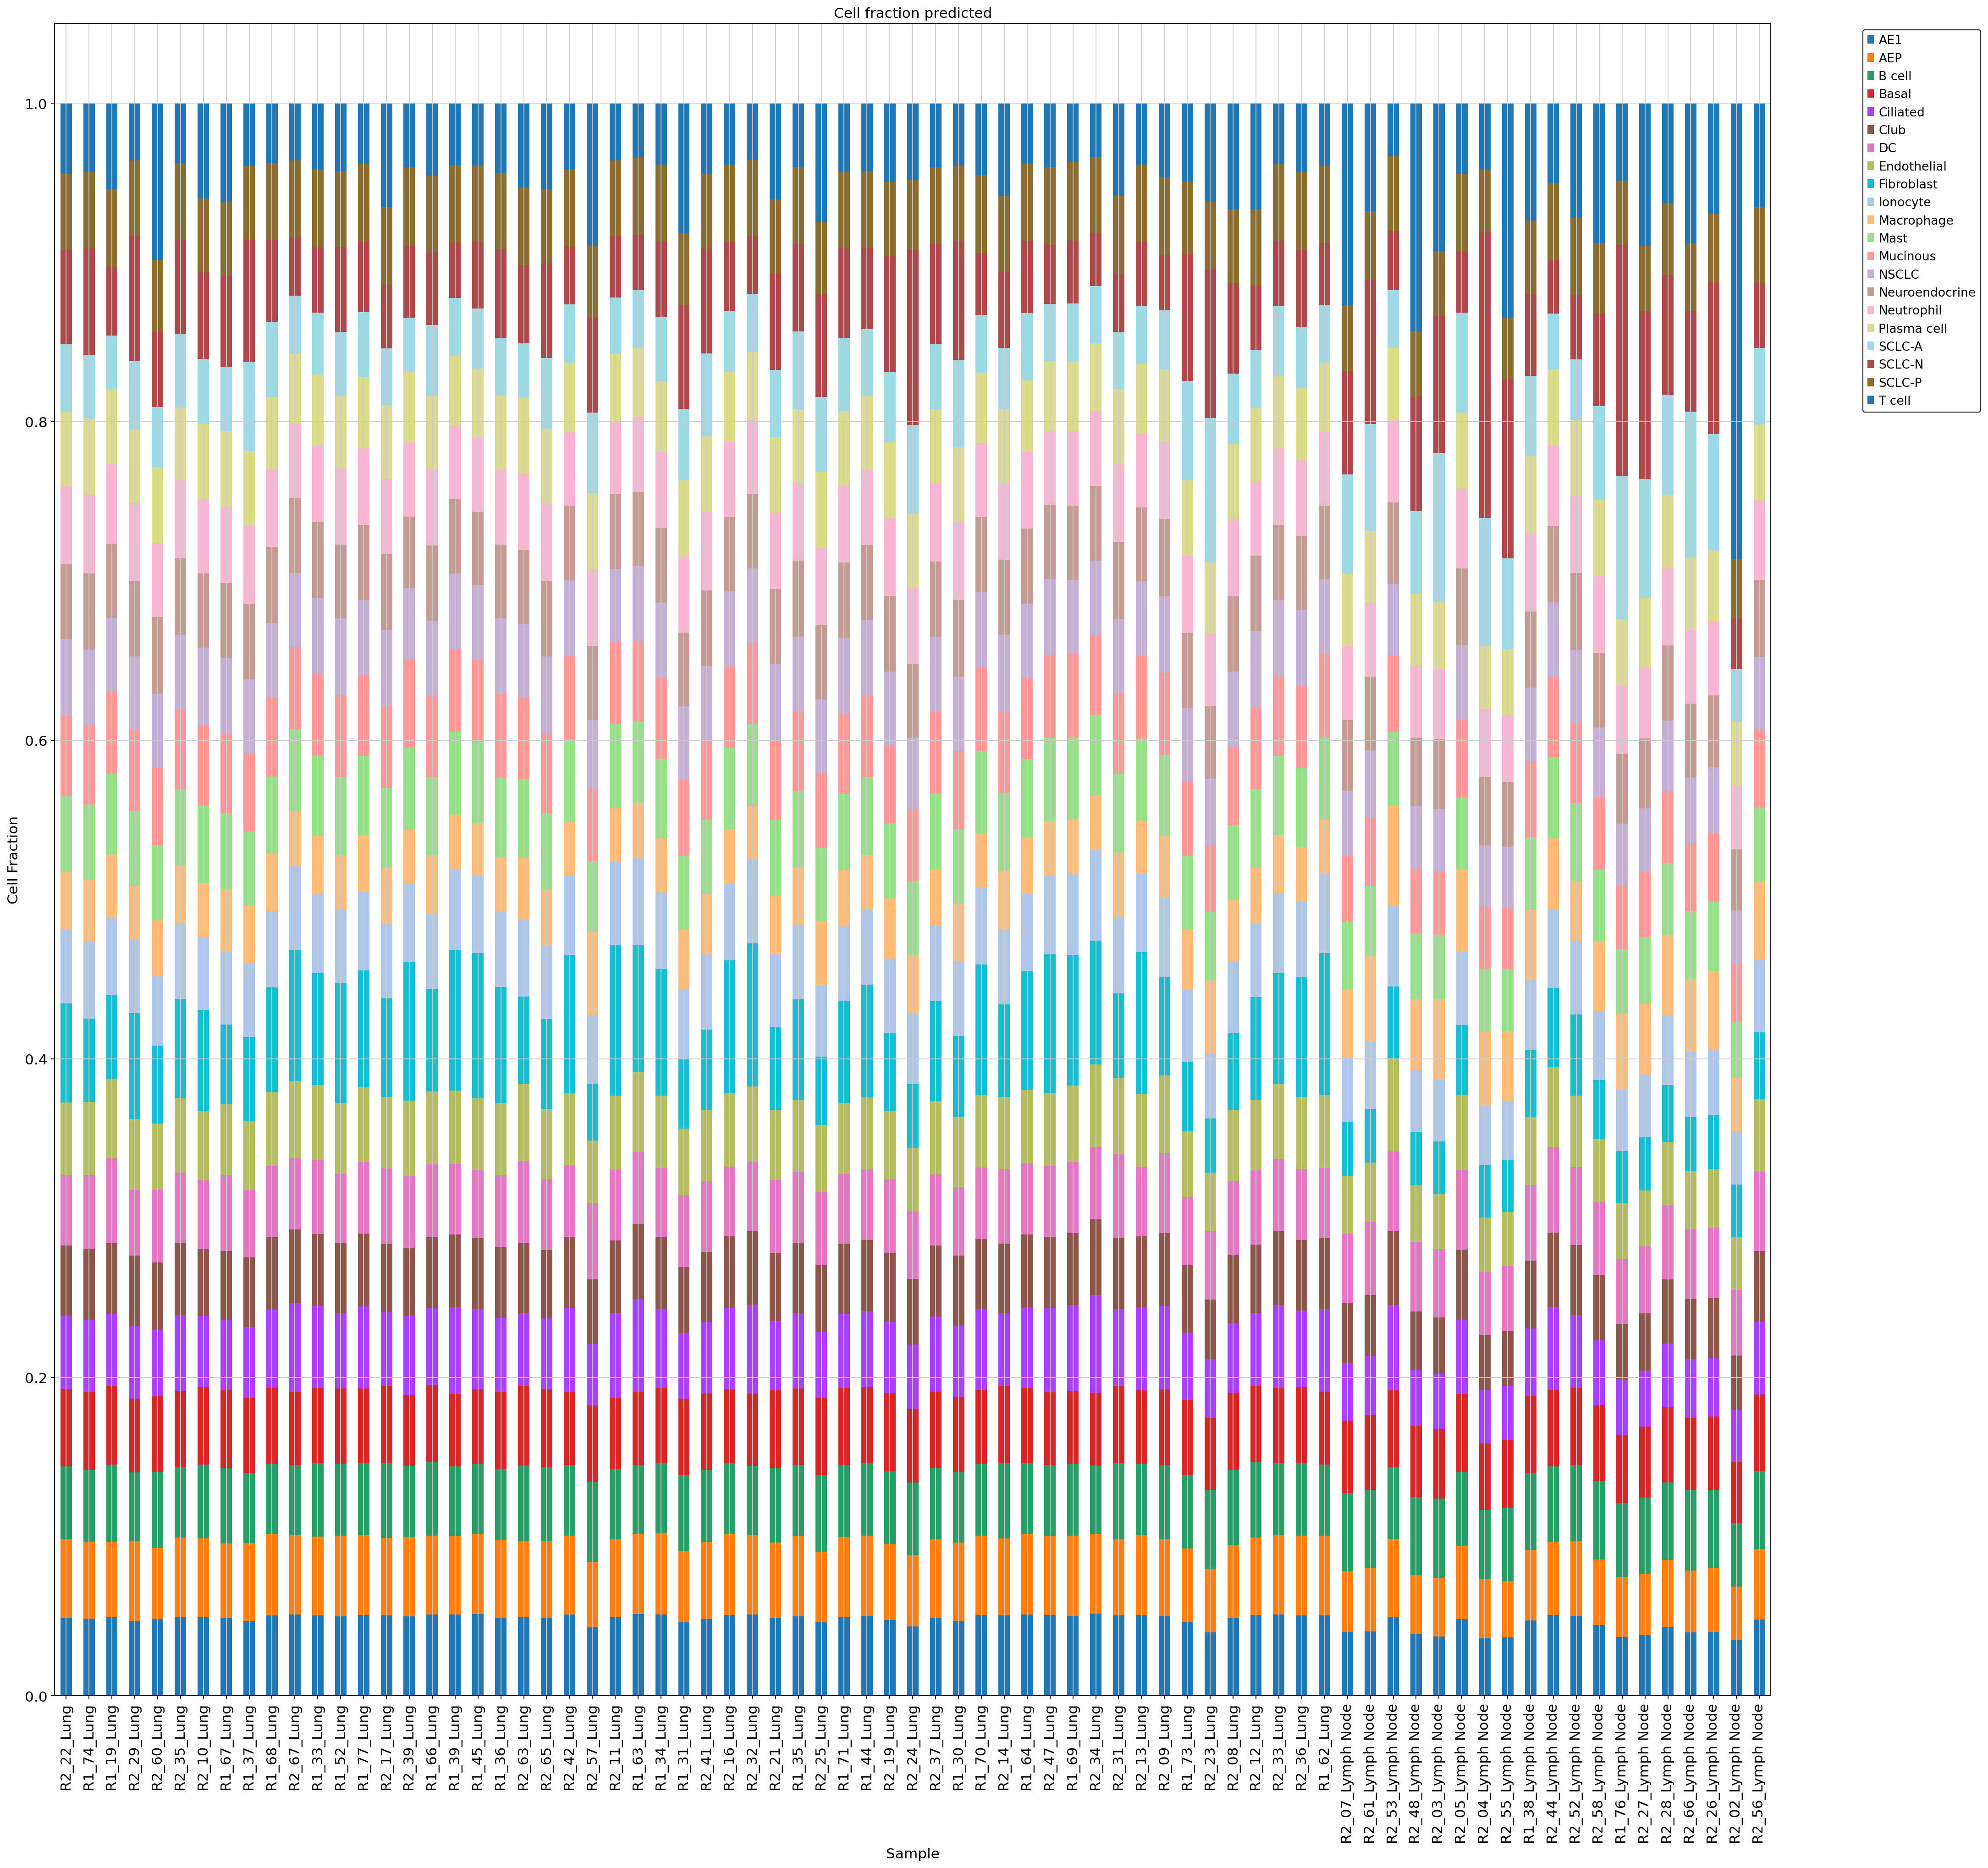

In [ ]:
ax = CellFractionPrediction_sorted.plot(kind='bar', stacked=True, figsize=(30, 30))
ax.set_xlabel('Sample')
ax.set_ylabel('Cell Fraction')
ax.set_title('Cell fraction predicted')
plt.legend(bbox_to_anchor=(1.05, 1),ncol=1,)
plt.show()

# TODO: check between lymph node vs lung
# TODO: mean and var per cell type for each sample and then do a prop test

## Bulk2single training - cell number for each sample


In [ ]:
# model.bulk_preprocess_lazy()
# model.single_preprocess_lazy()
# model.prepare_input()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


### Training the VAE model 

In [ ]:
# vae_net=model.train(
#     batch_size=512,
#     learning_rate=1e-4,
#     hidden_size=256,
#     epoch_num=25,
#     vae_save_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model',
#     vae_save_name='dg_vae',
#     generate_save_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/output',
#     generate_save_name='dg')

In [ ]:
model.load_fraction('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae_cell_target_num.pkl')



In [ ]:
model.bulk_preprocess_lazy()
model.single_preprocess_lazy()
model.prepare_input()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [ ]:
vae_net=model.load(vae_load_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae.pth')


loading model from /mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae.pth


(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'Beta-VAE'}, xlabel='Epochs', ylabel='Loss'>)

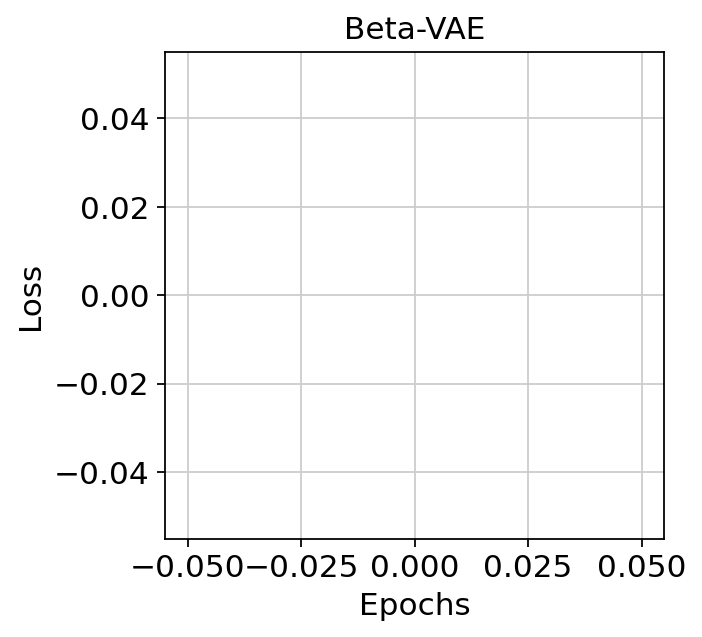

In [ ]:
model.plot_loss()

In [ ]:
generate_adata=model.generate()
generate_adata

...generating


generating:   0%|          | 0/1417 [00:00<?, ?it/s]

generating: 100%|██████████| 1417/1417 [00:01<00:00, 928.19it/s] 

generated done!


AnnData object with n_obs × n_vars = 1417 × 15138
    obs: 'cell_type_fine'

In [ ]:
generate_adata=model.filtered(generate_adata,leiden_size=5)
generate_adata

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=100
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
The filter leiden is  ['24', '25', '26', '27', '28', '29', '30', '31']


View of AnnData object with n_obs × n_vars = 1296 × 2739
    obs: 'cell_type_fine', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
generate_adata.write_h5ad(r"/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/deconvolution_bulk2single.h5ad")

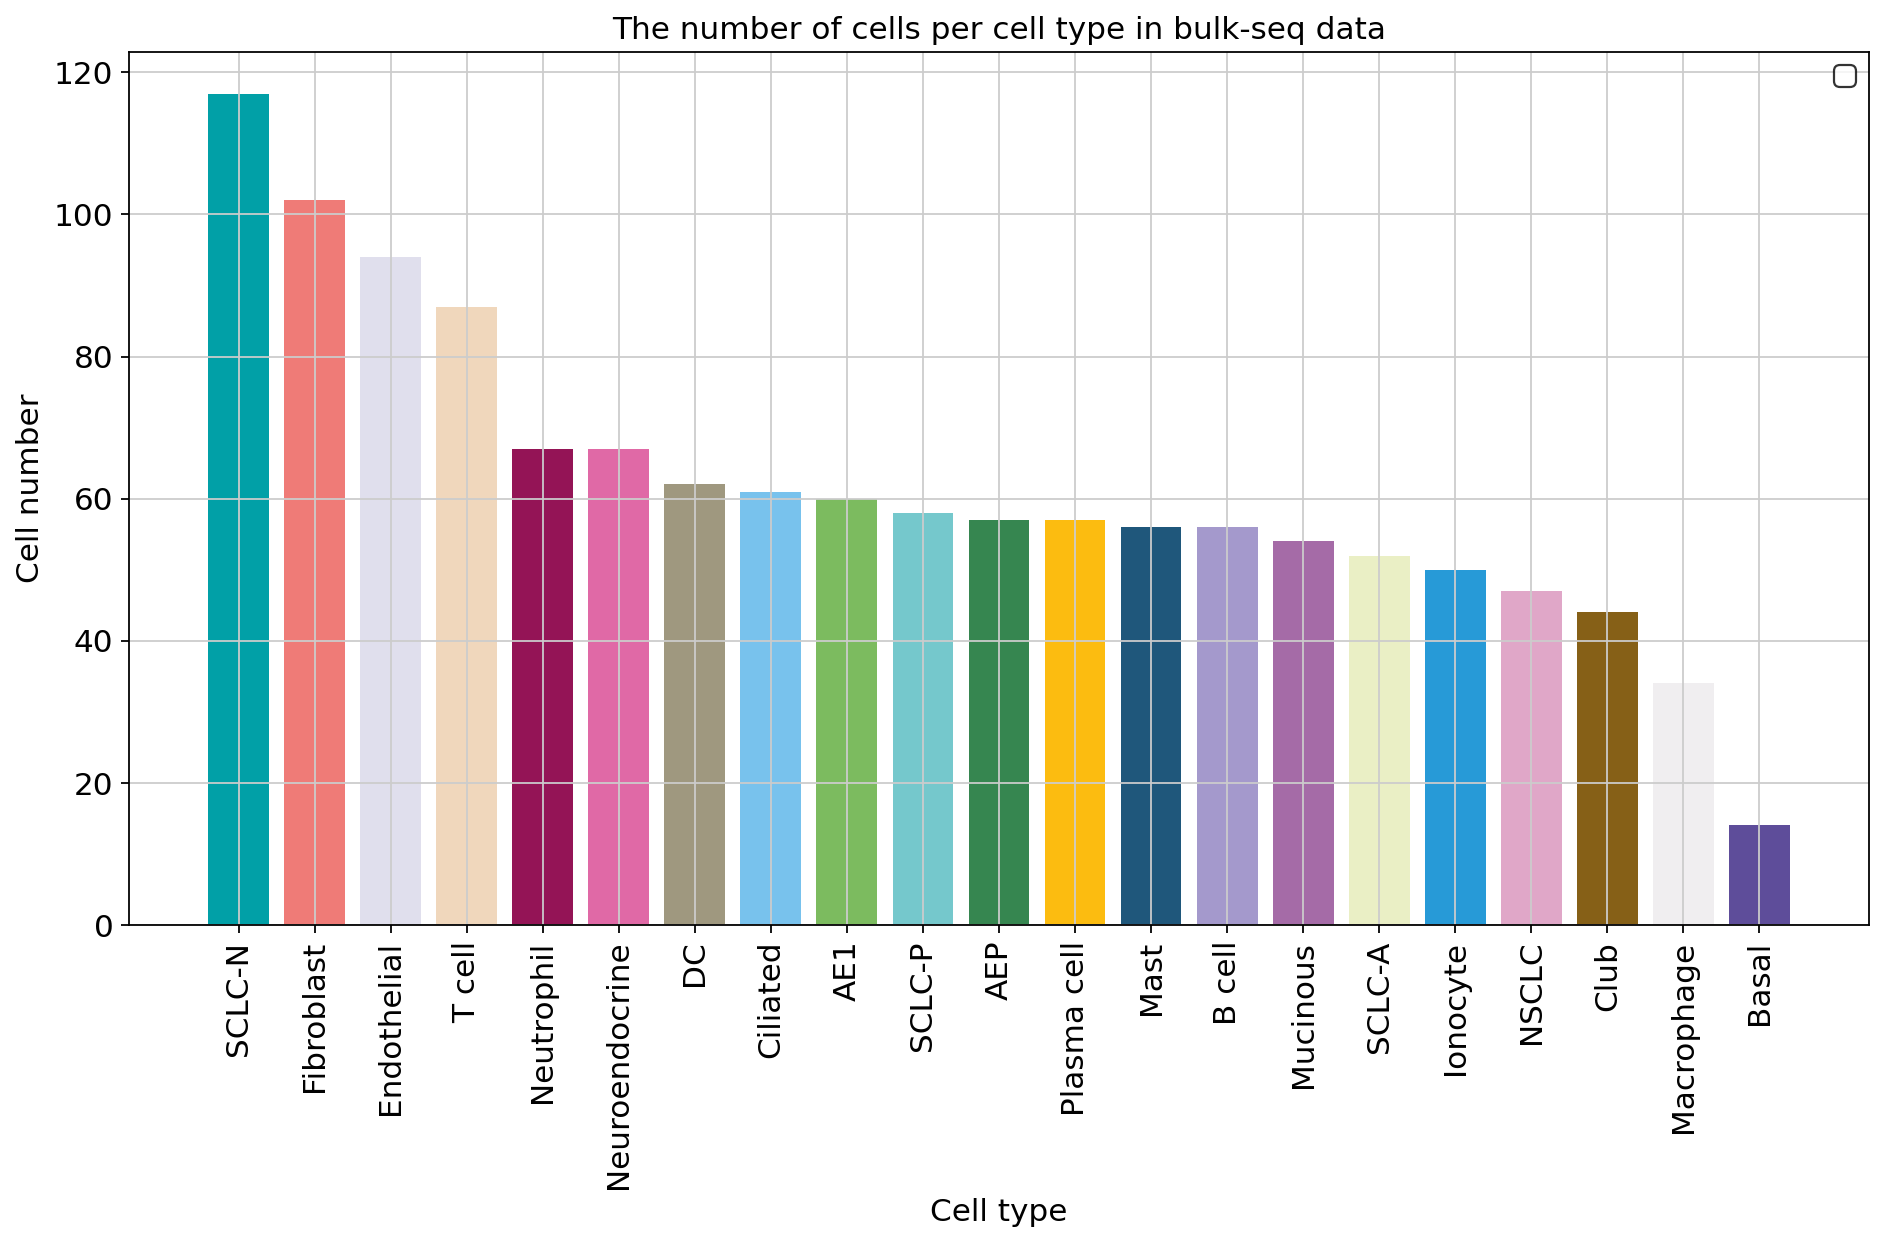

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = ov.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='cell_type_fine')

    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# TODO: compare lung vs lymph node to see if estimates match up with the original sclc

In [ ]:
sc_adata.obs["cell_type_fine"].value_counts()

SCLC-A            23782
T cell            12757
SCLC-N             6165
Macrophage         3424
DC                 1372
B cell              347
Fibroblast          314
Endothelial         250
AE1                 249
Mast                219
AEP                 185
Ciliated            165
Ionocyte             81
NSCLC                69
Mucinous             60
Basal                55
SCLC-P               42
Club                 41
Neutrophil           39
Neuroendocrine       14
Plasma cell          14
Name: cell_type_fine, dtype: int64

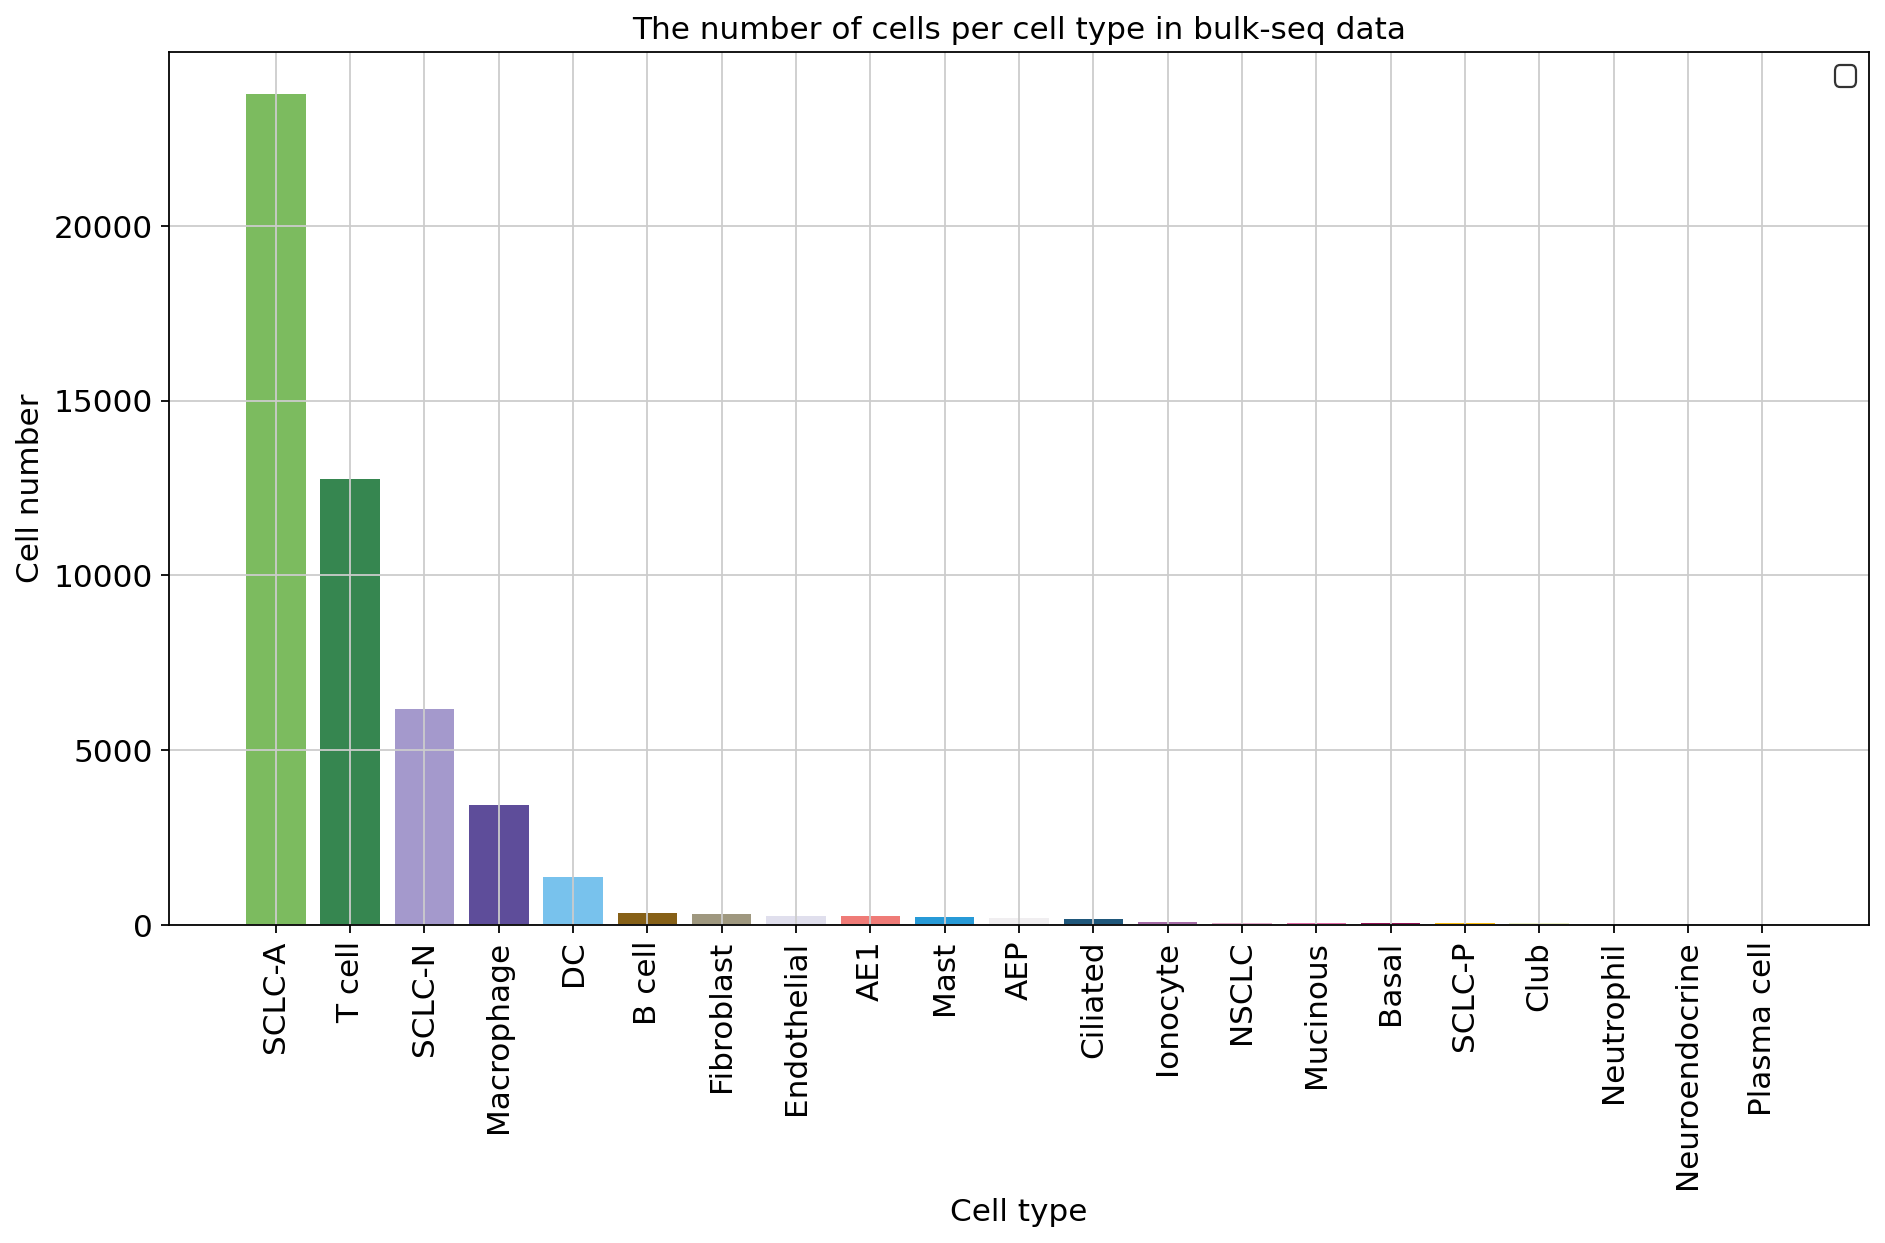

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = ov.bulk2single.bulk2single_plot_cellprop(sc_adata,celltype_key='cell_type_fine')


    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
sc_adata.X = sc_adata.layers["lognorm_counts"].copy()
sc_adata.raw = sc_adata

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:02)


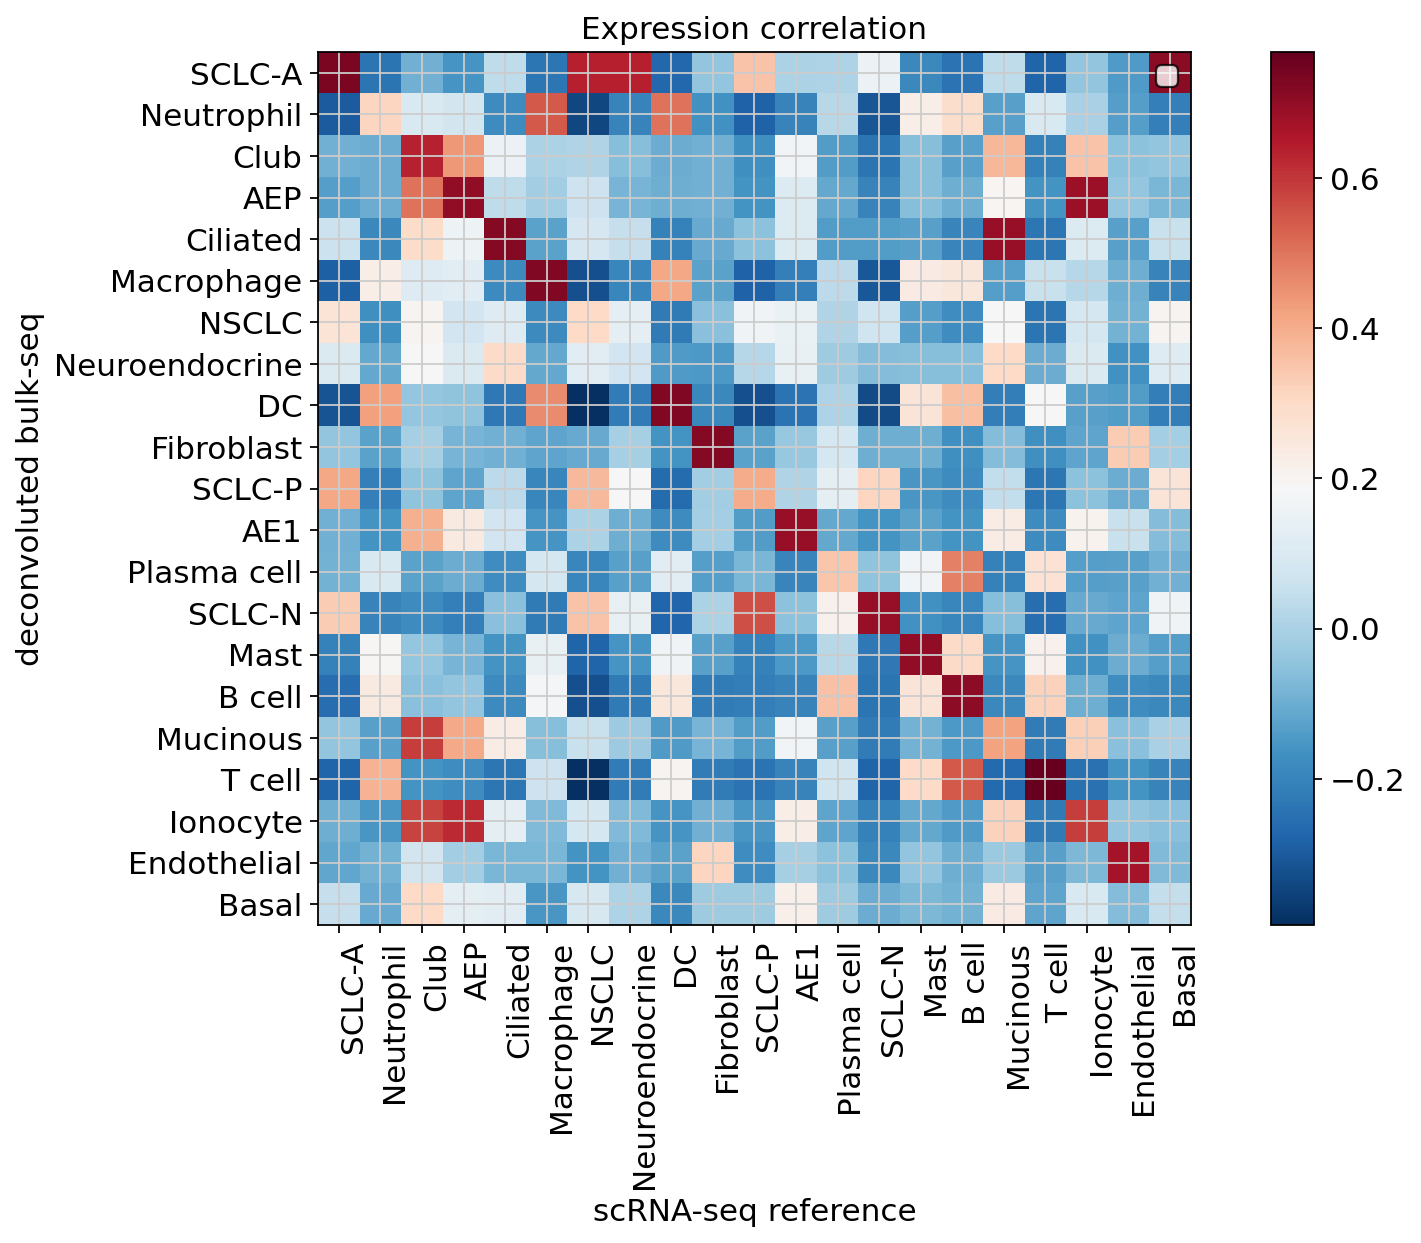

In [ ]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):

    plot_func = ov.bulk2single.bulk2single_plot_correlation(sc_adata,generate_adata,celltype_key='cell_type_fine')

    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

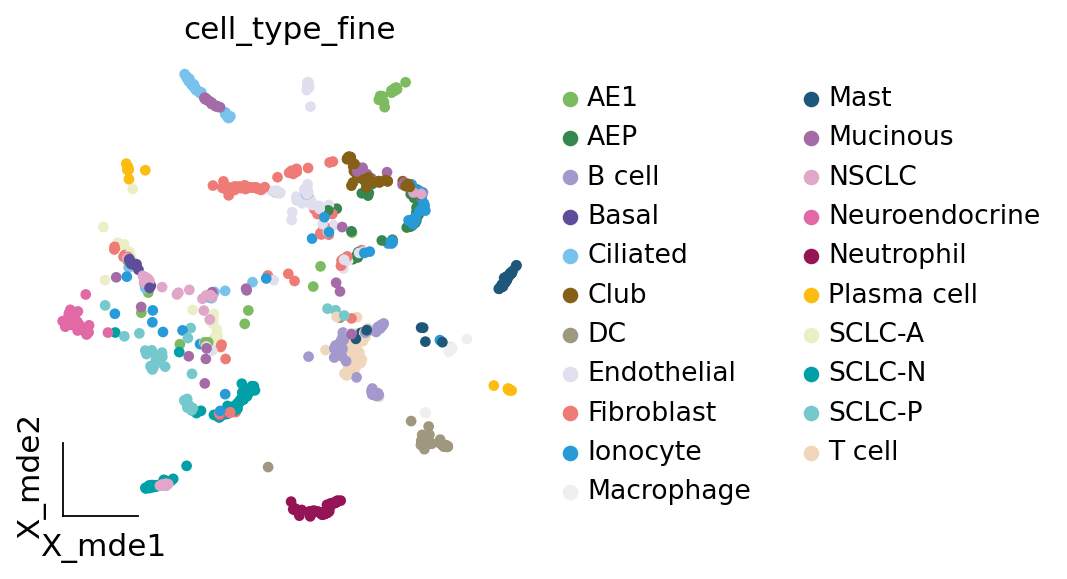

In [ ]:
generate_adata.obsm["X_mde"] = ov.utils.mde(generate_adata.obsm["X_pca"])
ov.utils.embedding(generate_adata,basis='X_mde',color=['cell_type_fine'],wspace=0.4,
          palette=ov.utils.pyomic_palette(),frameon='small')


In [ ]:
sc_adata.X = sc_adata.layers["raw_counts"].copy()
sc_adata.raw = sc_adata.copy()

# GARD score

In [21]:
manual_sets = {
	"Negative Radiation Sensitivity (RS)": {
		"AR": {"rank": ...},
		"PRKCB": {"rank": ...},
		"RELA": {"rank": ...},
		"SUMO1": {"rank": ...},
		"PAK2": {"rank": ...},
		"IRF1": {"rank": ...},
		"HDAC1": {"rank": ...}
	},
	"Positive Radiation Sensitivity (RR)": {
		"JUN": {"rank": ...},
		"STAT1": {"rank": ...},
		"ABL1": {"rank": ...}
	}
}

In [22]:
gene_lengths = gene_info["length"].copy()
gene_lengths.index = gene_lengths.index.map(gene_info["gene_name"])
gene_lengths.drop_duplicates(inplace=True)
set1 = set(adata.var_names.tolist())
set2 = set(gene_lengths.index)

common_genes = set1.intersection(set2)
gene_lengths = gene_lengths[gene_lengths.index.isin(common_genes)]
gene_lengths = gene_lengths[gene_lengths.index.isin(list(common_genes))]
adata = adata[:, list(gene_lengths.index)].copy()


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import itertools

# Step 1: Compute the average expression of each gene across all samples (mean expression)
mean_expression = adata.layers["lognormalized_counts"].mean(axis=0)

# Step 2: Compute log mean expression and log gene lengths
log_mean_expression = np.log1p(mean_expression)  # log transform of mean expression
log_gene_lengths = np.log1p(gene_lengths.values)  # log transform of gene lengths

# Step 3: Fit a linear model based on the log mean expression and log gene lengths
slope, intercept, _, _, _ = linregress(log_gene_lengths, log_mean_expression)
fitted_values = intercept + slope * log_gene_lengths  # Predicted fitted values (based on the mean)

# Step 4: Prepare to store ranked sets for each sample with sample identifiers
ranked_sets_per_sample = {}

# Get log-normalized expression data for each sample (90 samples in total)
lognorm_data = adata.layers["lognormalized_counts"]

# Get sample names from adata.obs.index
sample_names = adata.obs.index

# Genes of interest (from manual_sets)
genes_of_interest = list(itertools.chain(*[list(gard_type_dict.keys()) for gard_type_dict in manual_sets.values()]))

# Iterate over each sample (axis 0 corresponds to samples)
for sample_idx in range(lognorm_data.shape[0]):
    # Step 5: Get the log-normalized expression for the current sample
    sample_expression = lognorm_data[sample_idx, :]

    # Apply log transformation to sample expression
    log_sample_expression = np.log1p(sample_expression)

    # Step 6: Subtract the precomputed fitted values (from the mean expression) for gene length
    length_adjusted_expression = log_sample_expression - fitted_values

    # Step 7: Rank the genes by length-adjusted expression for this sample
    ranked_genes = np.argsort(length_adjusted_expression)[::-1]  # Reverse for descending order

    # Create a DataFrame to store the ranked genes for this sample
    ranked_genes_df = pd.DataFrame({
        "gene_name": adata.var_names[ranked_genes],
        "length_adjusted_expression": length_adjusted_expression[ranked_genes]
    })

    # Step 8: Filter ranked_genes_df to keep only the genes in manual_sets (genes of interest)
    filtered_ranked_genes_df = ranked_genes_df[ranked_genes_df["gene_name"].isin(genes_of_interest)]

    # Step 9: Re-rank the genes of interest relatively (from 1 to N where N is the number of genes of interest)
    filtered_ranked_genes_df["relative_rank"] = np.arange(len(filtered_ranked_genes_df), 0, -1)

    # Step 10: Prepare a ranked set for this sample
    ranked_set = {gard_type: {} for gard_type in manual_sets.keys()}  # Initialize empty ranked set

    # Update ranks in the manual_sets dictionary for this sample based on the relative rank
    for gard_type, gard_type_dict in manual_sets.items():
        for gene_name in gard_type_dict.keys():
            subset_ranked_df = filtered_ranked_genes_df.loc[filtered_ranked_genes_df["gene_name"] == gene_name]
            if not subset_ranked_df.empty:
                # Store the relative rank in the sample's ranked set
                ranked_set[gard_type][gene_name] = subset_ranked_df["relative_rank"].values[0]
            else:
                # If the gene is not found, it can be skipped or set to a default value (e.g., None)
                ranked_set[gard_type][gene_name] = None

    # Step 11: Map the ranked set to the sample name
    sample_name = sample_names[sample_idx]
    ranked_sets_per_sample[sample_name] = ranked_set

# After the loop, ranked_sets_per_sample will contain a dictionary
# where each key is a sample name and the value is the ranked set for that sample.


# ranked_sets_per_sample will be a dictionary, each sample name corresponding to its ranked set.


In [24]:
# Example output for first sample:
print("Relative ranked set for sample 1 (by sample name):")
first_sample_name = sample_names[0]
print(f"{first_sample_name}: {ranked_sets_per_sample[first_sample_name]}")

Relative ranked set for sample 1 (by sample name):
R1_79: {'Negative Radiation Sensitivity (RS)': {'AR': 1, 'PRKCB': 2, 'RELA': 3, 'SUMO1': 6, 'PAK2': 10, 'IRF1': 8, 'HDAC1': 5}, 'Positive Radiation Sensitivity (RR)': {'JUN': 7, 'STAT1': 9, 'ABL1': 4}}


## Ranking

In [ ]:
adata

AnnData object with n_obs × n_vars = 90 × 22624
    obs: 'ID_Sample', 'StudyID', 'External_ID', 'Organ', 'SampleType', 'Diagnosis', 'Stage', 'AnyPlasma', 'Arm', 'Project_ID', 'Organism', 'Sample_Biosource', 'RIN', 'Concentration', 'Flowcell_Name', 'Flowcell_ID', 'R1', 'R1_md5sum', 'R2', 'R2_md5sum', 'Elution.volume..uL.', 'RNA.con.ng.uL', 'Isolation.kit', 'BiopsyVsBehstart', 'pasnr', 'hospital', 'birth_date', 'radio_arm', 'tnm_staging', 'start_date', 'death_date', 'death_date_v2', 'ink_1', 'sex', 'age', 'pf', 'age70', 'actualrandarm', 'randarm', 'age65', 'status', 'brain_metastasis', 'chemo_1', 'chemo_2', 'chemo_3', 'chemo_4', 'no_chemo', 'trt', 'radio_dose', 'royk', 'performance_status', 'performance_status_2023', 'overall_survival', 'progression_status', 'progression', 'progression_date', 'updated_pfs', 'status_pfs', 'status_ttp', 'status_os', 'ttp_05_24', 'pfs_2023', 'start_strale', 'end_strale', 'ttp_2023_taha', 'pfs_date', 'ttp_date', 'os_date', 'pfs_corr', 'ttp_corr', 'os_corr', 

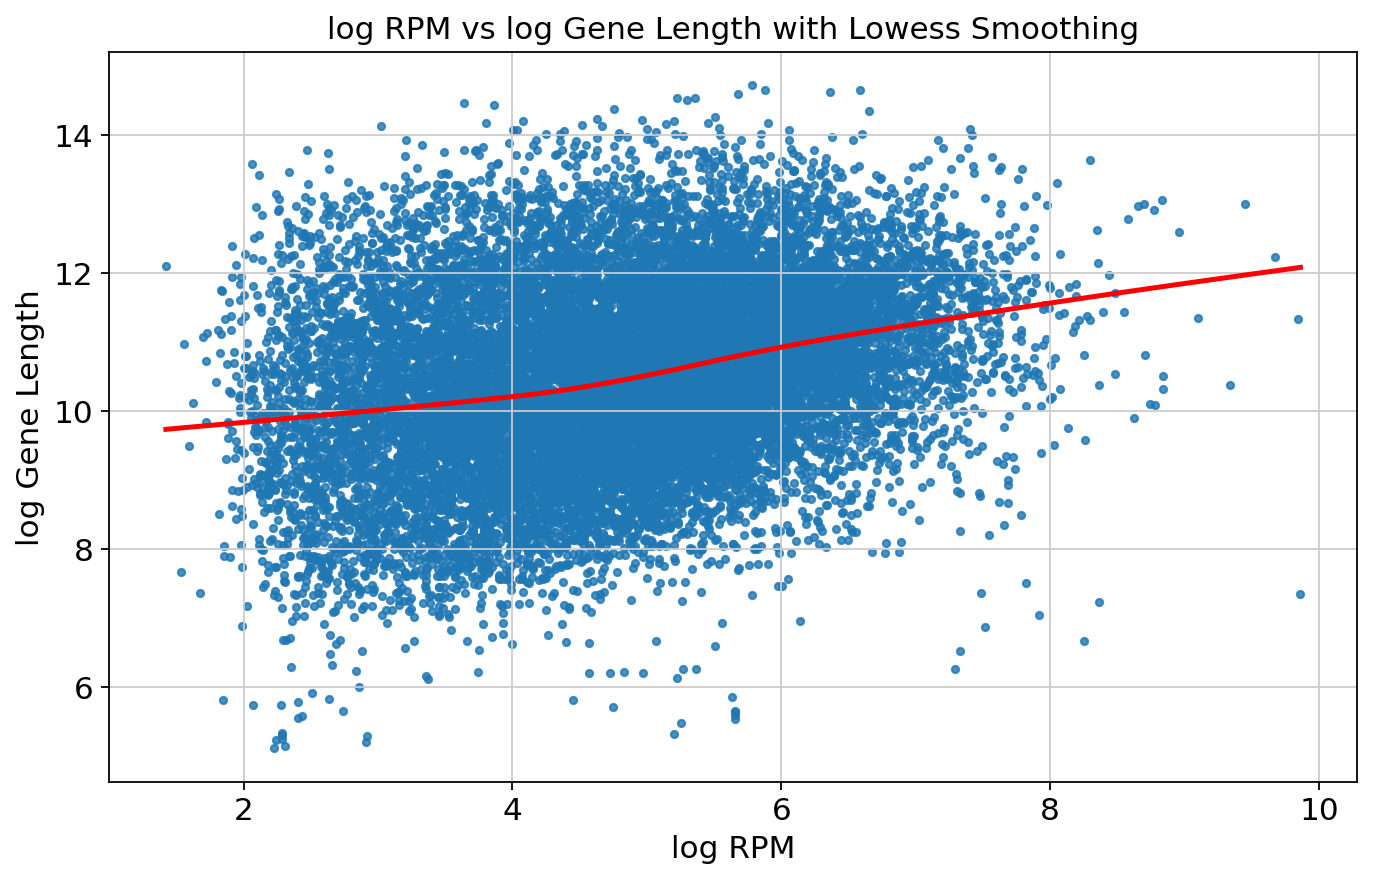

In [ ]:
# Step 4: Compute the average expression of each gene across all samples
mean_expression = adata.X.mean(axis=0)
# Step 5: Plot log RPM (mean_expression) vs log (gene length)
log_rpm = np.log1p(mean_expression)
# Step 6: Calculate log length
log_length = np.log1p(gene_lengths.values)

# Define a threshold for filtering
min_expression_threshold = 1

# Filter out genes with mean expression below the threshold
filtered_idx = mean_expression > min_expression_threshold
filtered_log_rpm = log_rpm[filtered_idx]
filtered_log_length = log_length[filtered_idx]

# Replot with filtered data
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_log_rpm, y=filtered_log_length, lowess=True,  line_kws={'color': 'red'},scatter_kws={'s':10})
plt.xlabel('log RPM')
plt.ylabel('log Gene Length')
plt.title('log RPM vs log Gene Length with Lowess Smoothing')
plt.show()


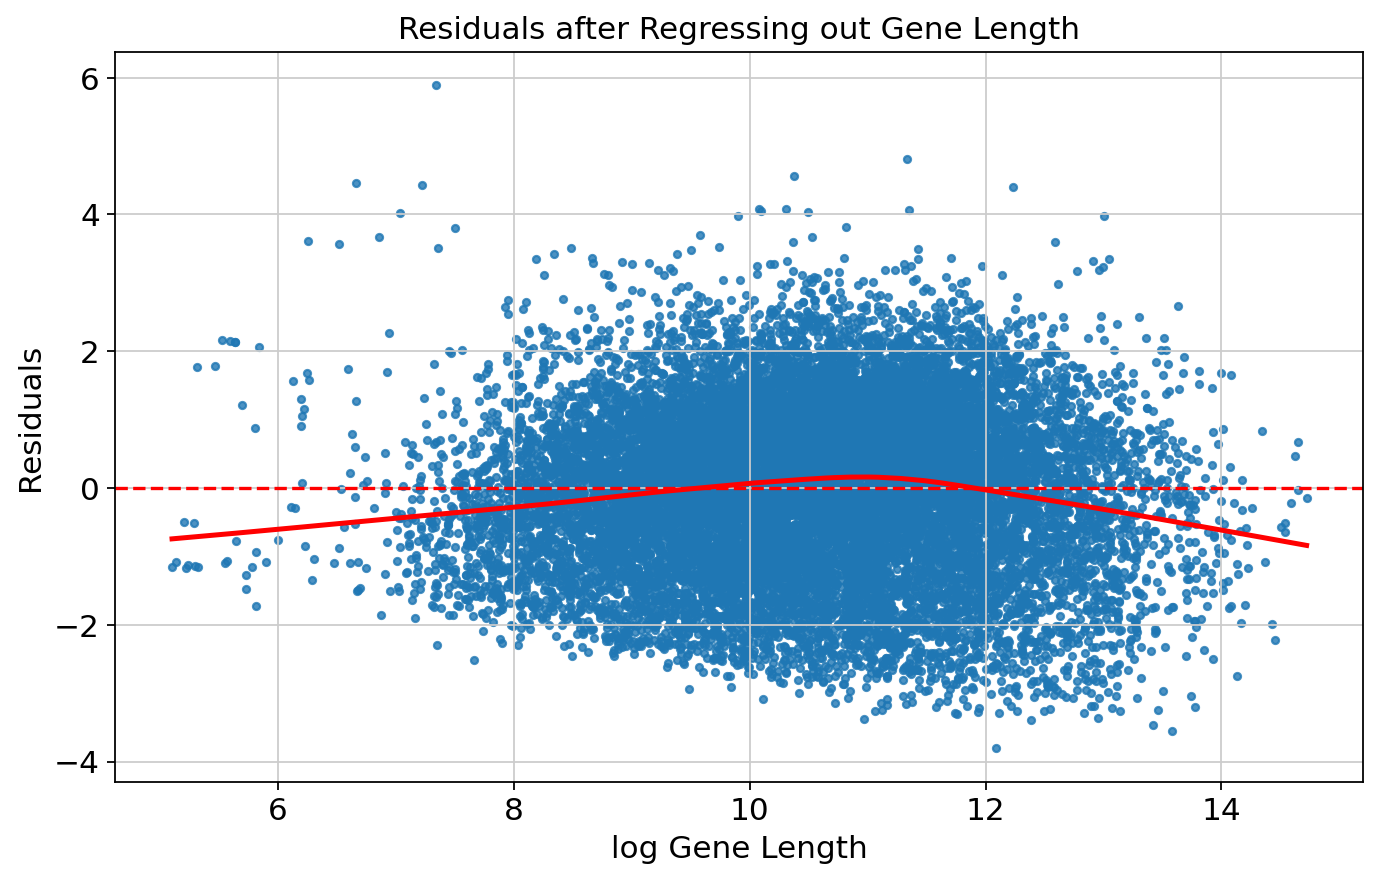

In [ ]:

# Step 7: Fit a linear model and use it to regress out the effect of gene length
slope, intercept, r_value, p_value, std_err = linregress(log_length, log_rpm)
fitted_values = intercept + slope * log_length

# Regress out the gene length effect
residuals = log_rpm - fitted_values
# Plot the residuals to check if they are centered around a horizontal line
plt.figure(figsize=(10, 6))
sns.regplot(x=log_length, y=residuals, lowess=True, line_kws={'color': 'red'},scatter_kws={'s':10})
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('log Gene Length')
plt.ylabel('Residuals')
plt.title('Residuals after Regressing out Gene Length')
plt.show()


In [ ]:
adata.layers["lognormalized_counts"].shape

(90, 17062)

In [ ]:

# Step 7: Subtract the predicted length from the gene length (alternative method)
length_adjusted_expression = log_rpm - fitted_values

# Step 8: Rank the genes by highest and lowest mean-adjusted expression
ranked_genes = np.argsort(length_adjusted_expression)[::-1]

# Create a DataFrame to store the ranked genes
ranked_genes_df = pd.DataFrame({
    "gene_name": adata.var_names[ranked_genes],
    "length_adjusted_expression": length_adjusted_expression[ranked_genes]
})

# Display the top and bottom ranked genes
top_genes = ranked_genes_df.head(10)
bottom_genes = ranked_genes_df.tail(10)

print("Top 10 genes by length-adjusted expression:")
print(top_genes)

print("\nBottom 10 genes by length-adjusted expression:")
print(bottom_genes)

Top 10 genes by length-adjusted expression:
   gene_name  length_adjusted_expression
0     MT-CO1                    5.891307
1  MIR663AHG                    4.812300
2       XIST                    4.562058
3     MT-CO3                    4.456473
4     MT-ND4                    4.424237
5    HELLPAR                    4.405787
6       MIAT                    4.083667
7     HNRNPU                    4.082377
8    TMEM45A                    4.068787
9      DDX17                    4.043960

Bottom 10 genes by length-adjusted expression:
             gene_name  length_adjusted_expression
17052  ENSG00000248491                   -3.287212
17053  ENSG00000237473                   -3.291298
17054          SLC12A1                   -3.295219
17055            DMRT1                   -3.305980
17056  ENSG00000254180                   -3.365714
17057        LINC01612                   -3.375809
17058          COP1-DT                   -3.396983
17059        LINC01090                   -3.46175

In [ ]:
# Using the manual_Sets dictionary for each key, filter out the ranked_genes_df, keeping the ranks in which the genes are present

from _collections_abc import dict_keys
import itertools



genes = list(itertools.chain(*[list(gard_type_dict.keys()) for gard_type, gard_type_dict in manual_sets.items()]))

for gard_type, gard_type_dict in manual_sets.items():

	ranked_genes_df = ranked_genes_df[ranked_genes_df["gene_name"].isin(genes)]


# Add a "rank" column in which goes from 1 to the number of genes 
ranked_genes_df["rank"] = np.arange(1, len(ranked_genes_df) + 1)

ranked_set = manual_sets.copy()
for gard_set, gard_set_dict in ranked_set.items():
    for gene_name, gene_dict in gard_set_dict.items():
        subset_ranked_df = ranked_genes_df.loc[ranked_genes_df["gene_name"] == gene_name]
        if not subset_ranked_df.empty:
            gard_set_dict[gene_name] = subset_ranked_df["rank"].values[0]
        else:
            # You can either skip this gene or set the rank to a default value
            # gard_set_dict[gene_name] = None
            pass

In [ ]:
ranked_set

{'Negative Radiation Sensitivity (RS)': {'AR': 10,
  'PRKCB': 9,
  'RELA': 6,
  'SUMO1': 8,
  'PAK2': 3,
  'IRF1': 4,
  'HDAC1': 7},
 'Positive Radiation Sensitivity (RR)': {'JUN': 2, 'STAT1': 1, 'ABL1': 5}}

### Using scanpy regress_out

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare the data
adata = sc.read('your_data.h5ad')  # Load your AnnData object
gene_lengths = gene_info["length"].copy()
gene_lengths.index = gene_info["gene_name"]

# Ensure adata has the same genes as gene_info
adata = adata[:, adata.var_names.intersection(gene_lengths.index)].copy()

# Compute mean expression per gene
mean_expression = np.mean(adata.X, axis=0).A1  # Convert sparse matrix to dense array and flatten

# Add gene lengths to the AnnData object as metadata
adata.var['gene_length'] = gene_lengths.loc[adata.var_names].values

# Normalize the data (if not already done)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# Step 2: Regress out gene length
sc.pp.regress_out(adata, ['gene_length'])

# Step 3: Plot the results
# Extract the residuals (adjusted expression data) from the AnnData object
adjusted_expression = adata.raw.X.toarray()  # Convert sparse matrix to dense array
mean_adjusted_expression = np.mean(adjusted_expression, axis=0)

# Plot residuals
log_rpm = np.log1p(mean_expression)
log_length = np.log1p(gene_lengths.loc[adata.var_names].values)
residuals = np.log1p(mean_adjusted_expression) - np.poly1d(np.polyfit(log_length, log_rpm, 1))(log_length)

plt.figure(figsize=(10, 6))
sns.regplot(x=log_length, y=residuals, lowess=True, scatter_kws={'s':10})
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('log Gene Length')
plt.ylabel('Residuals')
plt.title('Residuals after Regressing out Gene Length')
plt.show()

# Rank genes based on the mean adjusted expression
ranked_genes = pd.DataFrame({
    'gene_name': adata.var_names,
    'mean_expression': mean_adjusted_expression
}).sort_values(by='mean_expression', ascending=False)

# Display top and bottom genes based on mean expression
print("Top genes based on mean expression:")
print(ranked_genes.head())

print("Bottom genes based on mean expression:")
print(ranked_genes.tail())


Logarithm of p-value (logp):

result['logp'] = -np.log10(result['pvalue'])
This transforms the p-value into a more manageable scale. The negative log transformation makes small p-values (indicating high significance) larger and more positive. This is a common transformation in statistical analysis.
Sign of log2 fold change (fcsign):

result['fcsign'] = np.sign(result['log2FoldChange'])
This captures the direction of the effect: +1 for upregulated genes, -1 for downregulated genes, and 0 for no change.
Metric (metric):

result['metric'] = result['logp'] / result['fcsign']
The metric divides the signed log fold change into the log p-value, which adjusts the p-value by the direction of the fold change.
Interpretation:
Positive metric values correspond to significant upregulated genes.
Negative metric values correspond to significant downregulated genes.
High absolute values (both positive and negative) indicate genes with a strong signal, whether upregulated or downregulated.

In [ ]:
result=results_df.copy()
result['fcsign']=np.sign(result['log2FoldChange'])
result['logp']=-np.log10(result['pvalue'])
result['metric']=result['logp']/result['fcsign']
rnk=pd.DataFrame()
rnk['gene_name']=result.index
rnk['rnk']=result['metric'].values
rnk=rnk.sort_values(by=['rnk'],ascending=False)
k=1
total=0
for i in range(len(rnk)):
	if rnk.loc[i,'rnk']==np.inf: 
		total+=1
for i in range(len(rnk)):
	if rnk.loc[i,'rnk']==np.inf: 
		rnk.loc[i,'rnk']=200+(total-k)
		k+=1
	elif rnk.loc[i,'rnk']==-np.inf: 
		rnk.loc[i,'rnk']=-(274+k)
		k+=1


In [ ]:

def convert_column(df, column):
    if df[column].dtype == "object":
        try:
            df[column] = df[column].astype(int)
        except ValueError:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                df[column] = df[column].astype(str)


In [ ]:
sc.tl.rank_genes_groups(adata, layer="lognormalized_counts", groupby="Sample-Biosource",groups="all",method="wilcoxon",key_added="wilcoxon")

## Calculate GARD

In [ ]:
adata.obs

ID_Sample StudyID External_ID       Organ  SampleType Diagnosis Stage  \
R1_79    SFH31/22   TH093       TB-49  Lymph Node  Metastasis      SCLC    LD   
R2_07   SFH182/20   TH157       TB-32  Lymph Node  Metastasis       NaN    LD   
R2_22    SFH62/21   TH041       TB-75        Lung     Primary      SCLC    LD   
R1_74    SFH61/21   TH028       TB-74        Lung         NaN      SCLC    LD   
R1_19   SFH263/19   TH165       TB-46        Lung     Primary       NaN    LD   
...           ...     ...         ...         ...         ...       ...   ...   
R2_56   SFH257/19   TH130       TB-40  Lymph Node  Metastasis       NaN    LD   
R2_12    SFH78/21   TH115       TB-93        Lung     Primary      SCLC    LD   
R2_33  SFH26/23.1   TH006       TB-43        Lung     Primary      SCLC    LD   
R2_36    SFH33/23   TH088       TB-53        Lung     Primary      SCLC    LD   
R1_62    SFH51/21   TH097       TB-66        Lung     Primary       NaN    LD   

       AnyPlasma                  Arm    Project_ID  ... middle_strale  \
R1_79       True  45 Gy/30 fraksjoner  GCF-2024-926  ...            No   
R2_07      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R2_22      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R1_74      False                  NaN  GCF-2024-926  ...           NaN   
R1_19       True  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
...          ...                  ...           ...  ...           ...   
R2_56       True  45 Gy/30 fraksjoner  GCF-2024-926  ...            No   
R2_12      False  45 Gy/30 fraksjoner  GCF-2024-926  ...            No   
R2_33      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R2_36      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R1_62       True  45 Gy/30 fraksjoner  GCF-2024-926  ...            No   

      time_since_t0  rt_dosage  chemo_dosage chemo_radiotherapy  \
R1_79           0.0        0.0           0.0           Baseline   
R2_07           0.0        0.0           0.0           Baseline   
R2_22           0.0        0.0           0.0           Baseline   
R1_74           NaN        NaN           NaN                NaN   
R1_19           0.0        0.0           0.0           Baseline   
...             ...        ...           ...                ...   
R2_56           0.0        0.0           0.0           Baseline   
R2_12           0.0        0.0           0.0           Baseline   
R2_33           0.0        0.0           0.0           Baseline   
R2_36           0.0        0.0           0.0           Baseline   
R1_62           0.0        0.0           0.0           Baseline   

      after_progression age_at_sample before_after_progression batch       RSI  
R1_79         -4.566360          68.0                      0.0  mRNA -0.791975  
R2_07        -10.512484          72.0                      0.0  mRNA -0.663656  
R2_22               NaN          71.0                      0.0  mRNA -0.453111  
R1_74               NaN           NaN                      NaN  mRNA -0.600186  
R1_19               NaN          71.0                      0.0  mRNA -0.705042  
...                 ...           ...                      ...   ...       ...  
R2_56        -18.659658          77.0                      0.0  mRNA -0.967197  
R2_12               NaN          66.0                      0.0  mRNA -0.797938  
R2_33        -14.717477          71.0                      0.0  mRNA -0.520988  
R2_36        -30.584757          64.0                      0.0  mRNA -0.577265  
R1_62               NaN          60.0                      0.0  mRNA -0.659419  

[90 rows x 93 columns]

In [25]:
import numpy as np
import pandas as pd

def GARD(adata, rank_dictionary):
    RSI_list = []
    
    for sample_name, rank_dict in rank_dictionary.items():
        # Initialize RSI score for the sample
        RSI = 0
        
        # Safely retrieve ranks and assign 0 if missing
        AR_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("AR", 0)
        JUN_rank = rank_dict["Positive Radiation Sensitivity (RR)"].get("JUN", 0)
        STAT1_rank = rank_dict["Positive Radiation Sensitivity (RR)"].get("STAT1", 0)
        PRKCB_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("PRKCB", 0)
        RELA_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("RELA", 0)
        ABL1_rank = rank_dict["Positive Radiation Sensitivity (RR)"].get("ABL1", 0)
        SUMO1_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("SUMO1", 0)
        PAK2_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("PAK2", 0)
        HDAC1_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("HDAC1", 0)
        IRF1_rank = rank_dict["Negative Radiation Sensitivity (RS)"].get("IRF1", 0)

        # Calculate RSI score based on ranks and predefined coefficients
        RSI = (
            (-0.0098009 * AR_rank)
            + (0.0128283 * JUN_rank)
            + (0.0254552 * STAT1_rank)
            + (-0.0017589 * PRKCB_rank)
            + (-0.0038171 * RELA_rank)
            + (-0.1070213 * ABL1_rank)
            + (-0.0002509 * SUMO1_rank)
            + (-0.0092431 * PAK2_rank)
            + (-0.0204469 * HDAC1_rank)
            + (0.0441683 * IRF1_rank)
        )

        # Append RSI score for the current sample
        RSI_list.append(RSI)

    # Assign the calculated RSI scores back to the adata.obs DataFrame
    adata.obs["RSI"] = RSI_list

    return adata.obs

# Execute the GARD function to calculate RSI scores and add them to adata.obs
GARD_final_df = GARD(adata, rank_dictionary=ranked_sets_per_sample)

# Print the updated adata.obs DataFrame to confirm the RSI score column
print(adata.obs.head())


       ID_Sample StudyID External_ID       Organ  SampleType Diagnosis Stage  \
R1_79   SFH31/22   TH093       TB-49  Lymph Node  Metastasis      SCLC    LD   
R2_07  SFH182/20   TH157       TB-32  Lymph Node  Metastasis       NaN    LD   
R2_22   SFH62/21   TH041       TB-75        Lung     Primary      SCLC    LD   
R1_74   SFH61/21   TH028       TB-74        Lung         NaN      SCLC    LD   
R1_19  SFH263/19   TH165       TB-46        Lung     Primary       NaN    LD   

       AnyPlasma                  Arm    Project_ID  ... middle_strale  \
R1_79       True  45 Gy/30 fraksjoner  GCF-2024-926  ...            No   
R2_07      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R2_22      False  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   
R1_74      False                  NaN  GCF-2024-926  ...           NaN   
R1_19       True  60 Gy/40 fraksjoner  GCF-2024-926  ...            No   

      time_since_t0  rt_dosage  chemo_dosage chemo_radiotherapy  \
R1_79  

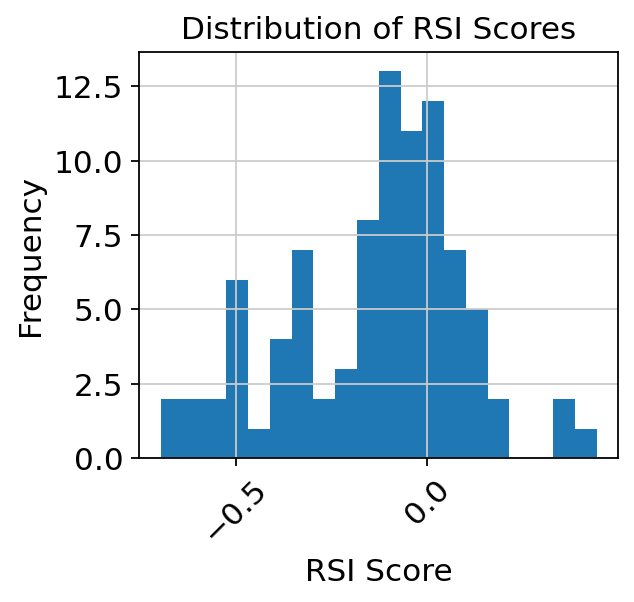

In [26]:
# Plot distribution histogram of RSI scores
adata.obs["RSI"].hist(bins=20)

# Add title and labels
plt.title("Distribution of RSI Scores")
plt.xlabel("RSI Score")
plt.ylabel("Frequency")

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

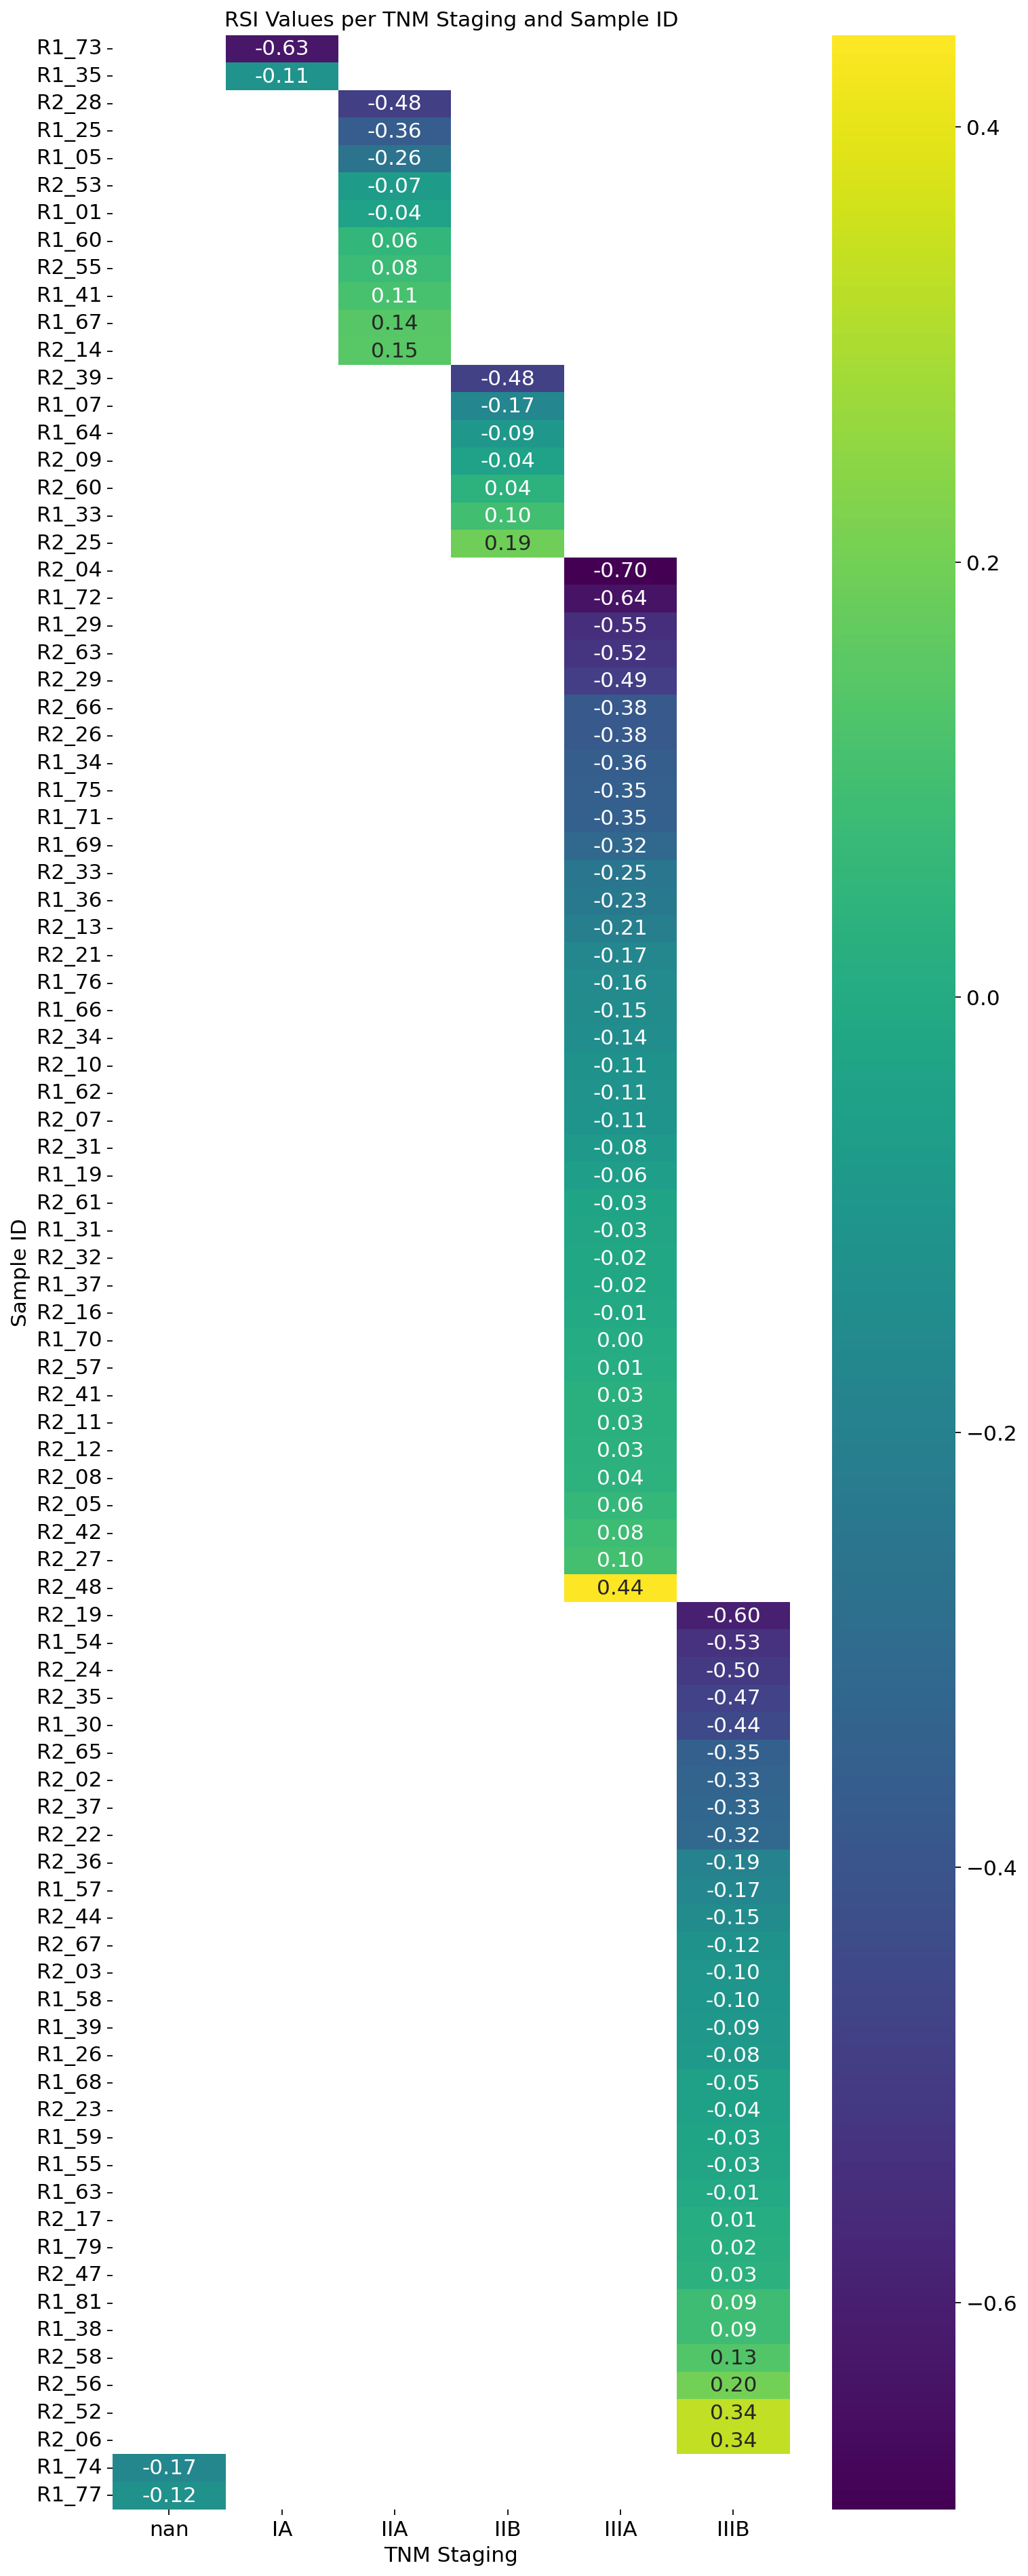

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract relevant columns from adata.obs
data = adata.obs[['tnm_staging', 'sample_id', 'RSI']]

# Sort the data first by 'tnm_staging', then by 'RSI' within each 'tnm_staging' group
data_sorted = data.sort_values(by=['tnm_staging', 'RSI'])

# Pivot the data to create a matrix with 'sample_id' as rows and 'tnm_staging' as columns
matrix_data = data_sorted.pivot(index='sample_id', columns='tnm_staging', values='RSI')

# Reindex sample_ids to preserve the sorting in the heatmap
matrix_data = matrix_data.reindex(data_sorted['sample_id'].unique())

# Create the heatmap using seaborn
plt.figure(figsize=(10, 30))  # Adjust the figure size as needed

# Add fmt='.2f' to round the numbers to 2 decimal places
sns.heatmap(matrix_data, annot=True, cmap='viridis', fmt='.2f')

plt.title('RSI Values per TNM Staging and Sample ID')
plt.xlabel('TNM Staging')
plt.ylabel('Sample ID')
plt.show()


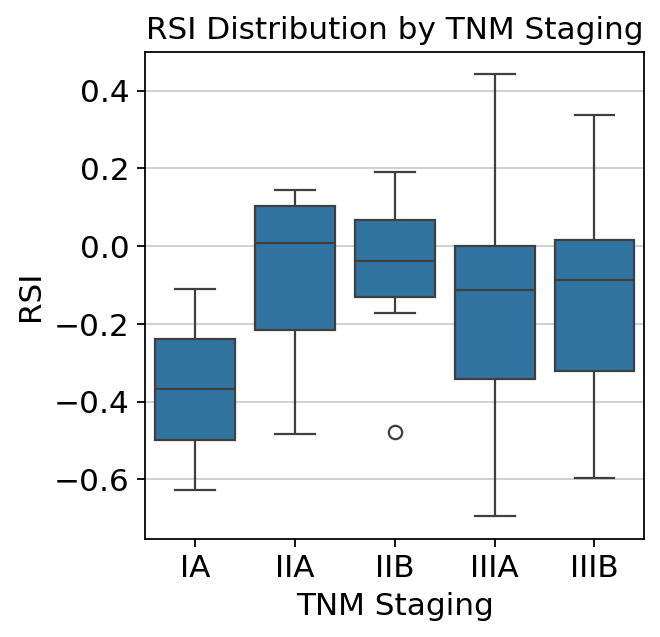

In [52]:
sns.boxplot(x='tnm_staging', y='RSI', data=data_sorted)
plt.title('RSI Distribution by TNM Staging')
plt.xlabel('TNM Staging')
plt.ylabel('RSI')
plt.show()


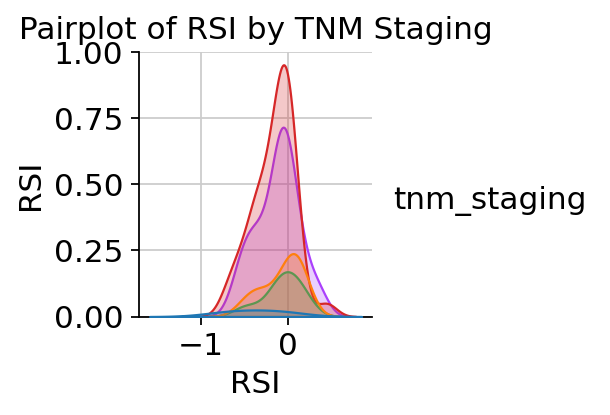

In [56]:
sns.pairplot(data_sorted, hue='tnm_staging', vars=['RSI'])
plt.title('Pairplot of RSI by TNM Staging')
plt.show()


In [41]:
adata.obs

ID_Sample StudyID External_ID       Organ  SampleType Diagnosis Stage  \
R1_79    SFH31/22   TH093       TB-49  Lymph Node  Metastasis      SCLC    LD   
R2_07   SFH182/20   TH157       TB-32  Lymph Node  Metastasis       NaN    LD   
R2_22    SFH62/21   TH041       TB-75        Lung     Primary      SCLC    LD   
R1_74    SFH61/21   TH028       TB-74        Lung         NaN      SCLC    LD   
R1_19   SFH263/19   TH165       TB-46        Lung     Primary       NaN    LD   
...           ...     ...         ...         ...         ...       ...   ...   
R2_56   SFH257/19   TH130       TB-40  Lymph Node  Metastasis       NaN    LD   
R2_12    SFH78/21   TH115       TB-93        Lung     Primary      SCLC    LD   
R2_33  SFH26/23.1   TH006       TB-43        Lung     Primary      SCLC    LD   
R2_36    SFH33/23   TH088       TB-53        Lung     Primary      SCLC    LD   
R1_62    SFH51/21   TH097       TB-66        Lung     Primary       NaN    LD   

       AnyPlasma                  Arm    Project_ID  ... time_since_t0  \
R1_79       True  45 Gy/30 fraksjoner  GCF-2024-926  ...           0.0   
R2_07      False  60 Gy/40 fraksjoner  GCF-2024-926  ...           0.0   
R2_22      False  60 Gy/40 fraksjoner  GCF-2024-926  ...           0.0   
R1_74      False                  NaN  GCF-2024-926  ...           NaN   
R1_19       True  60 Gy/40 fraksjoner  GCF-2024-926  ...           0.0   
...          ...                  ...           ...  ...           ...   
R2_56       True  45 Gy/30 fraksjoner  GCF-2024-926  ...           0.0   
R2_12      False  45 Gy/30 fraksjoner  GCF-2024-926  ...           0.0   
R2_33      False  60 Gy/40 fraksjoner  GCF-2024-926  ...           0.0   
R2_36      False  60 Gy/40 fraksjoner  GCF-2024-926  ...           0.0   
R1_62       True  45 Gy/30 fraksjoner  GCF-2024-926  ...           0.0   

      rt_dosage  chemo_dosage  chemo_radiotherapy after_progression  \
R1_79       0.0           0.0            Baseline         -4.566360   
R2_07       0.0           0.0            Baseline        -10.512484   
R2_22       0.0           0.0            Baseline               NaN   
R1_74       NaN           NaN                 NaN               NaN   
R1_19       0.0           0.0            Baseline               NaN   
...         ...           ...                 ...               ...   
R2_56       0.0           0.0            Baseline        -18.659658   
R2_12       0.0           0.0            Baseline               NaN   
R2_33       0.0           0.0            Baseline        -14.717477   
R2_36       0.0           0.0            Baseline        -30.584757   
R1_62       0.0           0.0            Baseline               NaN   

      age_at_sample before_after_progression batch       RSI sample_id  
R1_79          68.0                      0.0  mRNA  0.023215     R1_79  
R2_07          72.0                      0.0  mRNA -0.105104     R2_07  
R2_22          71.0                      0.0  mRNA -0.315649     R2_22  
R1_74           NaN                      NaN  mRNA -0.168574     R1_74  
R1_19          71.0                      0.0  mRNA -0.063718     R1_19  
...             ...                      ...   ...       ...       ...  
R2_56          77.0                      0.0  mRNA  0.198436     R2_56  
R2_12          66.0                      0.0  mRNA  0.029177     R2_12  
R2_33          71.0                      0.0  mRNA -0.247772     R2_33  
R2_36          64.0                      0.0  mRNA -0.191496     R2_36  
R1_62          60.0                      0.0  mRNA -0.109341     R1_62  

[90 rows x 94 columns]

computing PCA
    with n_comps=50


    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Organ']`


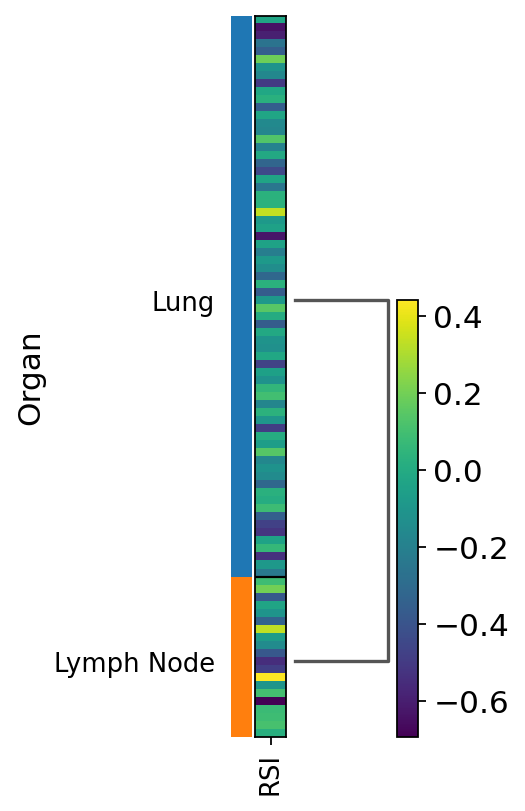

In [40]:
ax = sc.pl.heatmap(
    adata, "RSI", groupby="Organ", cmap="viridis", dendrogram=True
)

In [63]:
# Save adata for ggplot2 visualizations
adata.obs.to_excel("/mnt/work/RO_src/Pipelines/DataEngineering/adata_obs_for_ggplot2.xlsx")